In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os.path import join
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
cambodia_file = r'Game Data\joinedDataCambodia.csv'
vietnam_file = r'Game Data\joinedDataVietnam.csv'
merged_file = r'Game Data\mergedData.csv'


clusters_folder="Clusters"

cambodia_csv = pd.read_csv(os.path.join(directory, cambodia_file), engine="python")
vietnam_csv = pd.read_csv(os.path.join(directory, vietnam_file), engine='python')
merged_csv = pd.read_csv(os.path.join(directory, merged_file), engine='python')

rgb_colors = [
    (215, 50, 41),     # Base
    (44, 209, 59),    # NCH
    (237, 237, 49),
    (45, 141, 190),     # Base
]
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def to_percentage(x, pos):
    return f'{x * 100:.0f}%'


In [2]:
# 4 clusters based on cell type
# # labels_full=labels
labels_full_vietnam=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_vietnam.csv")))
labels_full_vietnam=np.array([arr[0] for arr in labels_full_vietnam])
centers_vietnam=np.array(pd.read_csv(join(directory, clusters_folder, "centers_4_cell_type_vietnam.csv")))


labels_full_cambodia=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_cambodia.csv")))
labels_full_cambodia=np.array([arr[0] for arr in labels_full_cambodia])
centers_cambodia=np.array(pd.read_csv(join (directory, clusters_folder, "centers_4_cell_type_cambodia.csv")))


labels_full_merged=np.array(pd.read_csv(join(directory, clusters_folder, "labels_4_cell_type_merged.csv")))
labels_full_merged=np.array([arr[0] for arr in labels_full_merged])
centers_merged=np.array(pd.read_csv(join (directory, clusters_folder, "centers_4_cell_type_merged.csv")))

labels_2_merged=np.array(pd.read_csv(join(directory, clusters_folder, "labels_2_cell_type_merged.csv")))
labels_2_merged=np.array([arr[0] for arr in labels_2_merged])
centers_2_merged=np.array(pd.read_csv(join (directory, clusters_folder, "centers_2_cell_type_merged.csv")))

hs_labels={"Vietnam": [3], "Cambodia": [1], "Merged": [1]}
nch_labels={"Vietnam":  [1, 2], "Cambodia": [2, 3], "Merged": [2, 3]}
base_labels={"Vietnam":  [0], "Cambodia": [0], "Merged": [0]}
strategy_labels={"Vietnam":  ['Neutral', 'NCH (Moderate)', 'NCH (High)', 'Heavy Spray'], 
                 "Cambodia": ['Neutral', 'Heavy Spray', 'NCH (Moderate)', 'NCH (High)'],
                 "Merged": ['Neutral', 'Heavy Spray', 'NCH (High)', 'NCH (Moderate)']}

def set_country(curr_str):
    global curr_csv
    global hs_label
    hs_label=hs_labels[curr_str]
    global nch_label
    nch_label=nch_labels[curr_str]
    global base_label
    base_label=base_labels[curr_str]
    global strategy_label
    strategy_label=strategy_labels[curr_str]
    global labels_full
    global centers
    # for 2 clusters
    global labels_2, centers_2, nch_2, hs_2

    nch_2=0
    hs_2=1

    if curr_str == "Merged":
        labels_full= labels_full_merged
        centers = centers_merged
        curr_csv = merged_csv
        labels_2=labels_2_merged
        centers_2=centers_2_merged
        nch_2=0
        hs_2=1

    elif curr_str == "Vietnam":
        labels_full= labels_full_vietnam
        centers = centers_vietnam
        curr_csv = vietnam_csv
        labels_2=labels_2_merged[:4480*4]
        centers_2=centers_2_merged[:4480*4]
        # labels_2=labels_2_vietnam
        # centers_2=centers_2_vietnam
        # nch_2=1
        # hs_2=0
    elif curr_str == "Cambodia":
        labels_full= labels_full_cambodia
        centers = centers_cambodia
        curr_csv = cambodia_csv
        labels_2=labels_2_merged[4480*4:]
        centers_2=centers_2_merged[4480*4:]
        # labels_2=labels_2_cambodia
        # centers_2=centers_2_cambodia
        # nch_2=1
        # hs_2=0

def calculate_score_csv(row_num, curr_csv):
    plot=np.array(curr_csv.iloc[row_num, 40:76]).reshape(6,6)
    cell_yield=[5, 0, 6, 10]
    
    scores=np.zeros((6, 6))
    if curr_csv['numNCH'][row_num] == 0:
        subsidy = 0
    else:
        subsidy = curr_csv['sumSubsidies'][row_num]/curr_csv['numNCH'][row_num]

    cell_yield[1]=subsidy

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield

def calculate_score(board, subsidy):
    plot=np.array(board).reshape(6,6)
    cell_yield=[5, 0, 6, 10]
    # print(plot)
    scores=np.zeros((6, 6))

    cell_yield[1]=subsidy

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield


def calculate_net_yield(board):
    # plot=np.array(curr_csv.iloc[row_num, 40:76]).reshape(6,6)
    plot = np.array(board).reshape(6, 6)
    cell_yield=[5, 0, 6, 10]
    # print(plot)
    scores=np.zeros((6, 6))

    for row in range(6):
        for col in range(6):
            if plot[row, col]==1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz]==1:
                            continue
                        scores[vert, horiz]+=2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=0

    for row in range(6):
        for col in range(6):
            scores[row, col] += cell_yield[plot[row, col]]
    
    # print(scores)

    for row in range(6):
        for col in range(6):
            if scores[row, col]>15:
                scores[row, col]=15

    full_yield=[0]*4
    for i in range(4):
        plot_temp= np.rot90(scores, i+1)
        corner=plot_temp[:3, :3]
        full_yield[i]=int(np.sum(corner))
    return full_yield


def calculate_nch(board):
    # plot = np.array(curr_csv.iloc[row_num, 40:76]).reshape(6, 6)
    plot = np.array(board).reshape(6, 6)
    # cell_yield = [5, 0, 6, 10]
    nch_nums = [0, 0, 0]
    # print(plot)
    scores = np.zeros((6, 6))

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 1:
                for vert in range(max(0, row-2), min(6, row+3)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-2), min(6, col+3)):
                        if plot[vert, horiz] == 1 or plot[vert, horiz] == 3:
                            continue
                        scores[vert, horiz] += 2

    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        nch_nums[0]+=scores[vert, horiz]
                        scores[vert, horiz] = 0

    for row in range(6):
        for col in range(6):
            nch_nums[1] += scores[row, col]
            if plot[row, col] == 1:
                nch_nums[2]+=1

    #[cancelled, bonus, num cells]
    return nch_nums
    
cells_map=np.zeros((6, 6)).tolist()
for i in range(6):
    for j in range(6):
        if i<3 and j<3:
            cells_map[i][j]=1
        elif i>=3 and j<3:
            cells_map[i][j]=4
        elif i<3 and j>=3:
            cells_map[i][j]=2
        else:
            cells_map[i][j]=3

# predicting increased 'similarity' between farmers using landscape characteristics

In [45]:
def calculate_similarity(corner, corner2):
    corner_adj = []
    for row in range(3):
        for col in range(3):
            # if row<col:
            #     continue
            if row == col:
                corner_adj.append(corner[row][col])
            # has mirror
            elif row < col:
                temp = max(corner[col][row], corner[row][col])
                corner_adj.append(temp)
            elif row > col:
                temp = min(corner[col][row], corner[row][col])
                corner_adj.append(temp)

    corner_adj2 = []
    for row in range(3):
        for col in range(3):
            if row == col:
                corner_adj2.append(corner2[row][col])
            # has mirror
            elif row < col:
                temp = max(corner2[col][row], corner2[row][col])
                corner_adj2.append(temp)
            elif row > col:
                temp = min(corner2[col][row], corner2[row][col])
                corner_adj2.append(temp)

    similarity = 0

    for a in range(9):
        if corner_adj[a] == corner_adj2[a]:
            similarity += 1

    return similarity


In [13]:
#average num cells changed
curr_csv = vietnam_csv
total_similarity=0
total_rounds=0

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue
    if curr_csv['Round'][i] == 1:
        prev_plot=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
        continue

    total_rounds+=1
    curr_plot=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        corner = np.rot90(
            np.array(prev_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
        corner2 = np.rot90(
            np.array(curr_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            
        corner_adj=[]
        for row in range(3):
            for col in range(3):
                # if row<col:
                #     continue
                if row==col:
                    corner_adj.append(corner[row][col])
                # has mirror
                elif row<col:
                    temp=max(corner[col][row], corner[row][col])
                    corner_adj.append(temp)
                elif row>col:
                    temp=min(corner[col][row], corner[row][col])
                    corner_adj.append(temp)
                    
        corner_adj2=[]   
        for row in range(3):
            for col in range(3):
                if row==col:
                    corner_adj2.append(corner2[row][col])
                # has mirror
                elif row<col:
                    temp=max(corner2[col][row], corner2[row][col])
                    corner_adj2.append(temp)
                elif row>col:
                    temp=min(corner2[col][row], corner2[row][col])
                    corner_adj2.append(temp)

        similarity=0

        for a in range(9):
            if corner_adj[a]==corner_adj2[a]:
                similarity += 1

        total_similarity+=similarity

    prev_plot=curr_plot


print(1-total_similarity/total_rounds/36)

0.36206597222222225


In [15]:
#average num cells changed
curr_csv = vietnam_csv
total_similarity=0
total_rounds=0

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue
    if curr_csv['Round'][i] == 1:
        prev_plot=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
        continue

    total_rounds+=1
    curr_plot=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        corner = np.rot90(
            np.array(prev_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j).flatten()
        corner2 = np.rot90(
            np.array(curr_plot[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j).flatten()
            

        similarity=0

        for a in range(9):
            if corner[a]==corner2[a]:
                similarity += 1

        total_similarity+=similarity

    prev_plot=curr_plot


print(1-total_similarity/total_rounds/36)

0.3862774884259259


In [ ]:
curr_csv = merged_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X=[]
Y = []

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            
            x_add=[int(abs(k-j)==1 or abs(k-j)==3)]
            x_add.append(curr_csv['roundsPlayed'][i])
            temp=calculate_score(i, curr_csv)
            x_add.append(temp[j])
            x_add.append(temp[k])

            total_cells=[0]*4
            for cell in corner.flatten():
                total_cells[cell]+=1
            for cell in corner2.flatten():
                total_cells[cell]+=1

            x_add.extend(total_cells)
            # adjacent is 1, opposite is 0
            

            player_str="p"+str(j+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            player_str="p"+str(k+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            corner_adj=[]
            for row in range(3):
                for col in range(3):
                    # if row<col:
                    #     continue
                    if row==col:
                        corner_adj.append(corner[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                    elif row>col:
                        temp=min(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                     
            corner_adj2=[]   
            for row in range(3):
                for col in range(3):
                    if row==col:
                        corner_adj2.append(corner2[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)
                    elif row>col:
                        temp=min(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)

            similarity=0

            for a in range(9):
                if corner_adj[a]==corner_adj2[a]:
                    similarity += 1

            # x_add=np.array(x_add).flatten()
            X.append(x_add)
            Y.append(similarity)

X = np.array(X)
Y = np.array(Y)


In [80]:
indices_arr=["diagonal", "roundsPlayed", "score1", "score2", "base", "nch", "light", "heavy"]
for i in characteristics_arr:
    temp=i+"_1"
    indices_arr.append(temp)
for i in characteristics_arr:
    temp=i+"_2"
    indices_arr.append(temp)

In [39]:
X.shape

(26880, 80)

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

accuracy:  0.767854933712696


# similarity prediction with categorical vars

In [349]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area",
                       "district_1", "district_2", "district_3", "district_4", "district_5", "district_6", "commune_101", "commune_102", "commune_103", "commune_201", "commune_202", "commune_301", "commune_302", 
                        "commune_303", "commune_304", "commune_305", "commune_306", "commune_401", "commune_501", "commune_601", "commune_602", "village_1", "village_2", "village_4", "village_7", "village_9", 
                        "village_10", "village_12", "village_14", "village_15", "village_16", "village_19", "village_20", "village_21", "village_22", "village_24"]

X=[]
Y = []

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            
            x_add=[int(abs(k-j)==1 or abs(k-j)==3)]
            x_add.append(curr_csv['roundsPlayed'][i])
            
            temp=calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])
            x_add.append(temp[k])

            total_cells=[0]*4
            for cell in corner.flatten():
                total_cells[cell]+=1
            for cell in corner2.flatten():
                total_cells[cell]+=1

            x_add.extend(total_cells)
            # adjacent is 1, opposite is 0
            

            player_str="p"+str(j+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            player_str="p"+str(k+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            corner_adj=[]
            for row in range(3):
                for col in range(3):
                    # if row<col:
                    #     continue
                    if row==col:
                        corner_adj.append(corner[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                    elif row>col:
                        temp=min(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                     
            corner_adj2=[]   
            for row in range(3):
                for col in range(3):
                    if row==col:
                        corner_adj2.append(corner2[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)
                    elif row>col:
                        temp=min(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)

            similarity=0

            for a in range(9):
                if corner_adj[a]==corner_adj2[a]:
                    similarity += 1

            # x_add=np.array(x_add).flatten()
            X.append(x_add)
            Y.append(similarity)

X = np.array(X)
Y = np.array(Y)

In [350]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.7712650115705058


In [41]:
freq=[0]*9
total=0
for i in Y:
    freq[i-1]+=1
    total+=1
for i in freq:
    print(i/total)

0.07109375
0.10398065476190477
0.1288690476190476
0.14427083333333332
0.1474702380952381
0.13470982142857144
0.11454613095238095
0.0537202380952381
0.10133928571428572


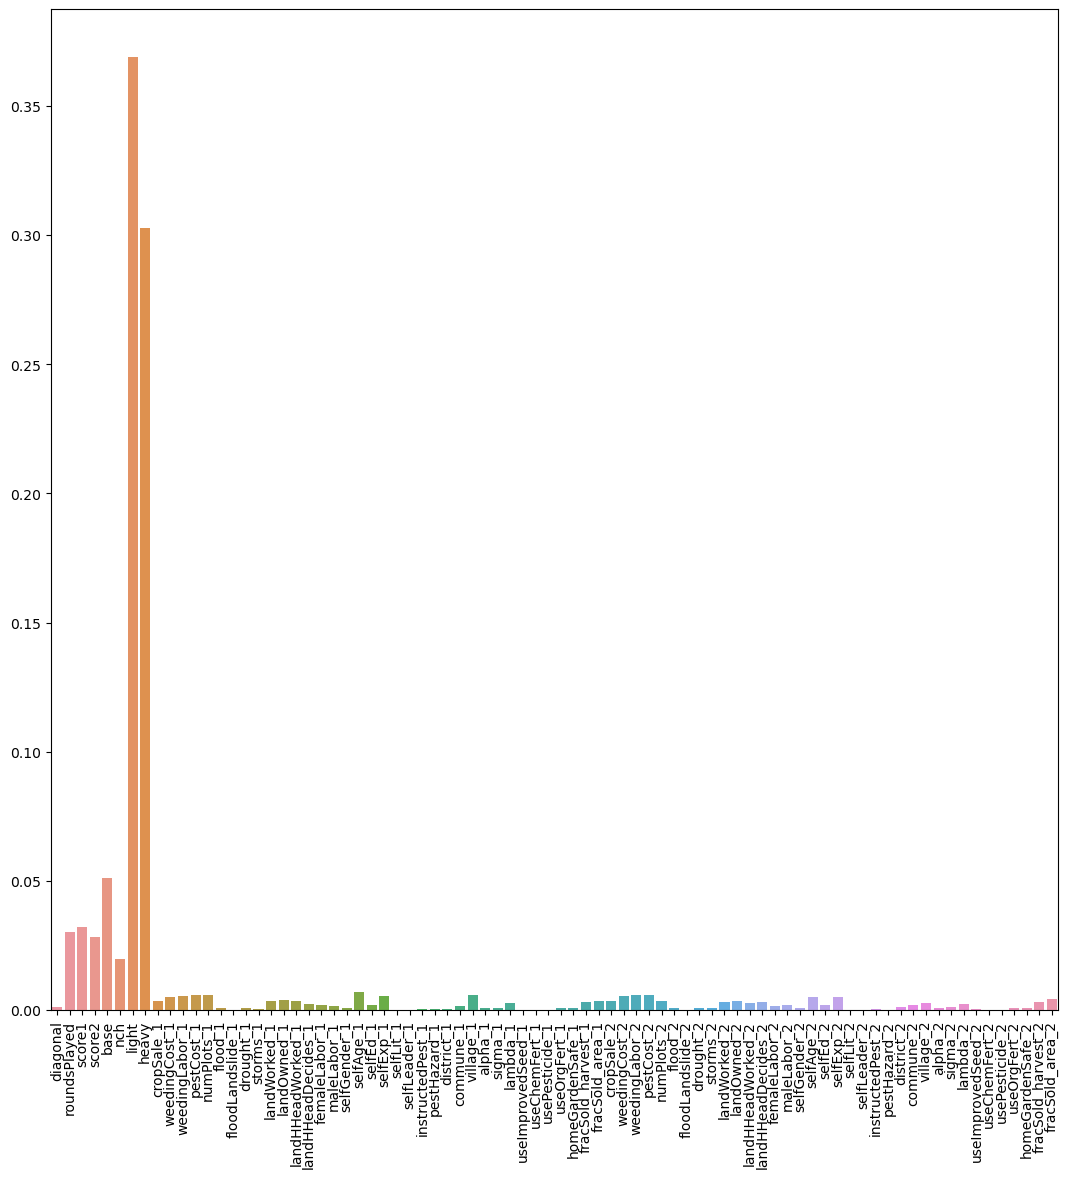

In [63]:
plt.figure(figsize=(13, 13))
sns.barplot(x=indices_arr, y=model.feature_importances_)

plt.xticks(rotation=90)
plt.show()


In [95]:
# correlations
from scipy.stats import pearsonr

correlations1=[]

for i in range(8):
    print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations1.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations1.sort(reverse=True)
correlations1 = np.array(correlations1)


diagonal (-0.0021097055631822143, 0.7294380973245337)
roundsPlayed (0.13860850898894547, 2.094519959067775e-115)
score1 (0.17486833629873896, 1.5306089280087974e-183)
score2 (0.1508040124651556, 1.7503626506628026e-136)
base (-0.4071641864194103, 0.0)
nch (-0.270339152862144, 0.0)
light (0.2724082597856296, 0.0)
heavy (0.12546306540588278, 9.66019170626079e-95)


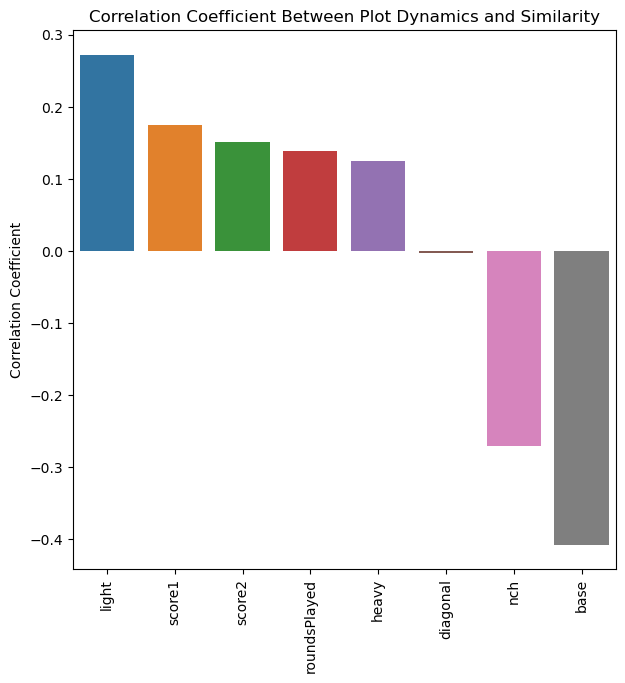

In [102]:
plt.figure(figsize=(7, 7))

categories = list(np.array(correlations1)[:, 1])
values = list(np.array(correlations1)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Plot Dynamics and Similarity")
plt.ylabel("Correlation Coefficient")
plt.show()

In [105]:
# correlations

correlations=[]

for i in range(8, X.shape[1]):
    print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)


cropSale_1 (0.011286424052136222, 0.0642565263451181)
weedingCost_1 (0.029938971405756194, 9.135416242237717e-07)
weedingLabor_1 (-0.031767896014100294, 1.893934933776507e-07)
pestCost_1 (0.010587896134100373, 0.08258747223790322)
numPlots_1 (0.011485373961002014, 0.059698265160538805)
flood_1 (0.0008817627967141309, 0.8850587666516073)
floodLandslide_1 (-0.019726210223766527, 0.001219411431611226)
drought_1 (-0.04407737751457422, 4.840018522173245e-13)
storms_1 (0.026496184709155345, 1.3950280176811697e-05)
landWorked_1 (0.05004113040785017, 2.2291689629689e-16)
landOwned_1 (0.045005580849996354, 1.5579248787734919e-13)
landHHeadWorked_1 (0.031320166133854944, 2.8064718443968106e-07)
landHHeadDecides_1 (0.008945348488600345, 0.14249528034165562)
femaleLabor_1 (0.053738356098644406, 1.18167717313127e-18)
maleLabor_1 (-0.05874031022347667, 5.502852666019225e-22)
selfGender_1 (0.032190101131273186, 1.300833435365709e-07)
selfAge_1 (-0.02967309912936902, 1.140030023897526e-06)
selfEd_1 (0

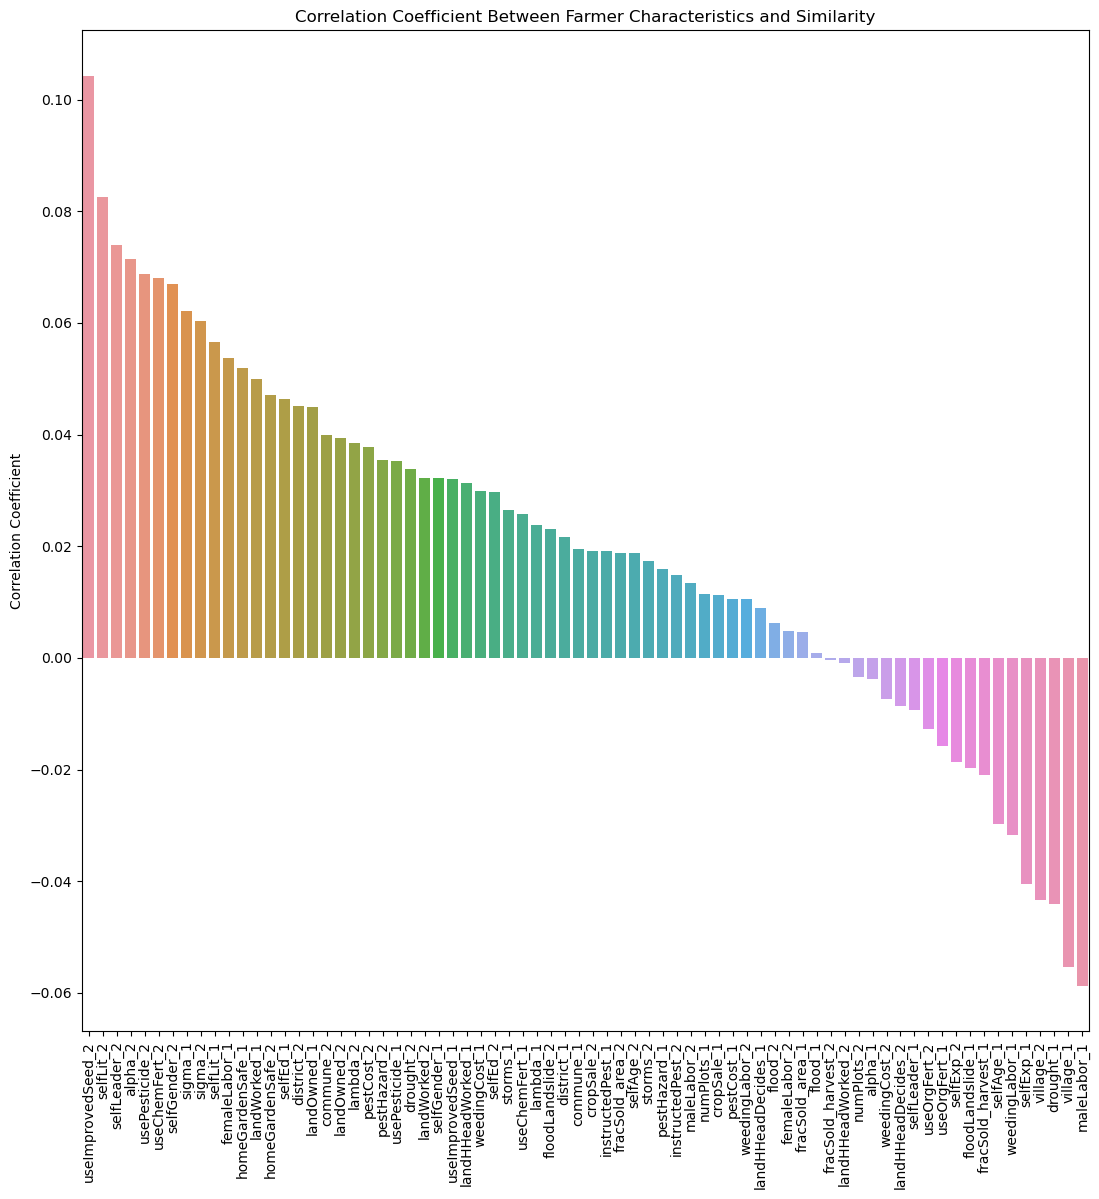

In [107]:
plt.figure(figsize=(13, 13))

categories = list(np.array(correlations)[:, 1])
values = list(np.array(correlations)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Similarity")
plt.ylabel("Correlation Coefficient")
plt.show()

In [65]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X=[]
Y = []

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            
            x_add=[]
            

            player_str="p"+str(j+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            player_str="p"+str(k+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            corner_adj=[]
            for row in range(3):
                for col in range(3):
                    # if row<col:
                    #     continue
                    if row==col:
                        corner_adj.append(corner[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                    elif row>col:
                        temp=min(corner[col][row], corner[row][col])
                        corner_adj.append(temp)
                     
            corner_adj2=[]   
            for row in range(3):
                for col in range(3):
                    if row==col:
                        corner_adj2.append(corner2[row][col])
                    # has mirror
                    elif row<col:
                        temp=max(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)
                    elif row>col:
                        temp=min(corner2[col][row], corner2[row][col])
                        corner_adj2.append(temp)

            similarity=0

            for a in range(9):
                if corner_adj[a]==corner_adj2[a]:
                    similarity += 1

            # x_add=np.array(x_add).flatten()
            X.append(x_add)
            Y.append(similarity)

X = np.array(X)
Y = np.array(Y)


In [66]:
# indices_arr=["diagonal", "roundsPlayed", "score1", "score2", "base", "nch", "light", "heavy"]
indices_arr=[]
for i in characteristics_arr:
    temp=i+"_1"
    indices_arr.append(temp)
for i in characteristics_arr:
    temp=i+"_2"
    indices_arr.append(temp)

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.38708726224237266


In [ ]:
scaler=StandardScaler()
pipe = Pipeline([('scaler', scaler), ('model', model)])
cvs = cross_val_score(pipe, X, Y, cv=10, scoring='r2')
print('R2 cross-validated: ', cvs, cvs.mean())

R2 cross-validated:  [0.68159554 0.57448094 0.55887513 0.77238964 0.42109235 0.77818719
 0.68479291 0.69303385 0.78711305 0.61834569] 0.6569906298066963


In [78]:
comb=[]
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)
comb

[[0.04836484005523036, 'weedingLabor_1'],
 [0.04406770931794012, 'weedingLabor_2'],
 [0.04030166860644206, 'pestCost_1'],
 [0.03934313673140884, 'selfExp_1'],
 [0.037681500038960876, 'commune_1'],
 [0.03697604419623598, 'pestCost_2'],
 [0.03578535650975707, 'commune_2'],
 [0.03474764391025011, 'selfExp_2'],
 [0.03462501388451572, 'fracSold_area_1'],
 [0.031050726252004234, 'landOwned_1'],
 [0.029300470370551543, 'selfAge_2'],
 [0.02802635669710585, 'landHHeadWorked_1'],
 [0.027402247349696054, 'selfAge_1'],
 [0.026390967871320097, 'cropSale_1'],
 [0.025956131803103192, 'weedingCost_1'],
 [0.02523707439832592, 'fracSold_harvest_2'],
 [0.02503462187005983, 'village_1'],
 [0.024474349006284108, 'weedingCost_2'],
 [0.02424338270606858, 'fracSold_harvest_1'],
 [0.018961289055879495, 'selfLeader_2'],
 [0.018435528927038754, 'numPlots_1'],
 [0.0180082832220415, 'landHHeadDecides_1'],
 [0.01781489763999028, 'numPlots_2'],
 [0.01768485637919967, 'landWorked_2'],
 [0.017662903950440876, 'landWor

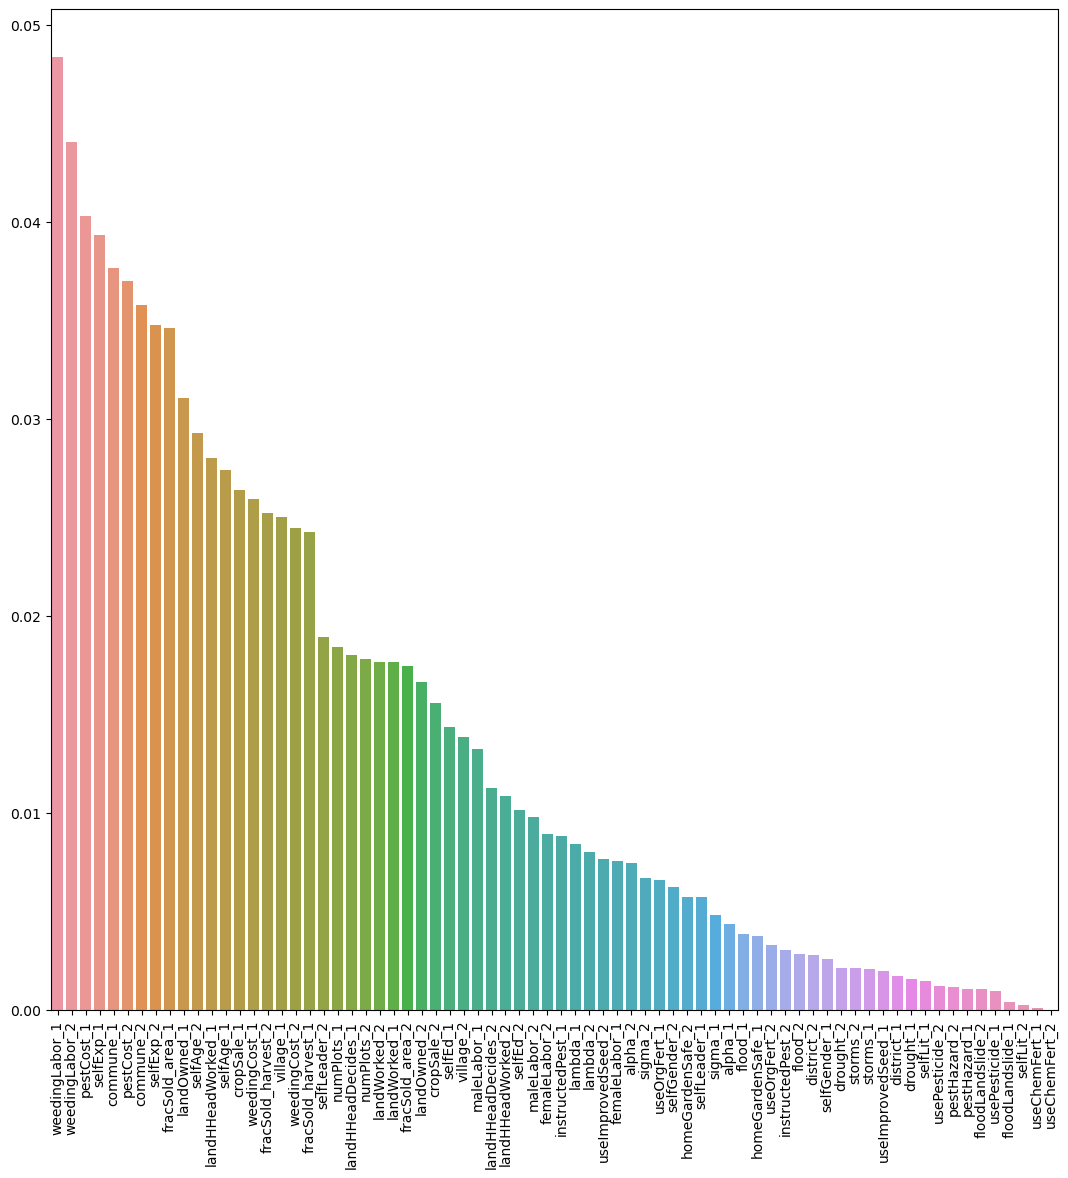

In [79]:
# weedinglabor
plt.figure(figsize=(13, 13))
categories = list(np.array(comb)[:, 1])
values = list(np.array(comb)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


# measuring trust

In [108]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X = []
Y = []

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corner = np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
        
        x_add=[]
        x_add.append(curr_csv['roundsPlayed'][i])
        temp=calculate_score(i, curr_csv)
        x_add.append(temp[j])

        total_cells=[0]*4
        for cell in corner.flatten():
            total_cells[cell]+=1
        for cell in corner2.flatten():
            total_cells[cell]+=1

        x_add.extend(total_cells)
        
        player_str="p"+str(j+1)+"_"
        chars=[]
        for char in characteristics_arr:
            col_ind=player_str+char
            val = curr_csv[col_ind][i]
            if pd.isna(val):
                chars.append(-1)
            else:
                chars.append(val)
        x_add.extend(chars)
        
        edge_cells=[]
        for row in range(3):
            for col in range(3):
                if row==2 or col==2:
                    edge_cells.append(corner[row, col])

        scores=np.zeros((6, 6))
        for row in range(6):
            for col in range(6):
                if curr_np[row, col] == 1:
                    for vert in range(max(0, row-2), min(6, row+3)):
                        # print(row, max(0, row-2), min(6, row+3))
                        for horiz in range(max(0, col-2), min(6, col+3)):
                            if curr_np[vert, horiz] == 1 or curr_np[vert, horiz] == 3:
                                continue
                            scores[vert, horiz] += 2

        for row in range(6):
            for col in range(6):
                if curr_np[row, col] == 3:
                    for vert in range(max(0, row-1), min(6, row+2)):
                        for horiz in range(max(0, col-1), min(6, col+2)):
                            scores[vert, horiz] = 0

        nch_edge=0
        for row in range(6):
            for col in range(6):
                if row==2 or col==2:
                    if scores[row, col]:
                        nch_edge += 1

        X.append(x_add)
        Y.append(nch_edge)

X = np.array(X)
Y = np.array(Y)

In [117]:
indices_arr=["roundsPlayed", "score", "base", "nch", "light", "heavy"]
for i in characteristics_arr:
    temp=i
    indices_arr.append(temp)

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.778879374936098


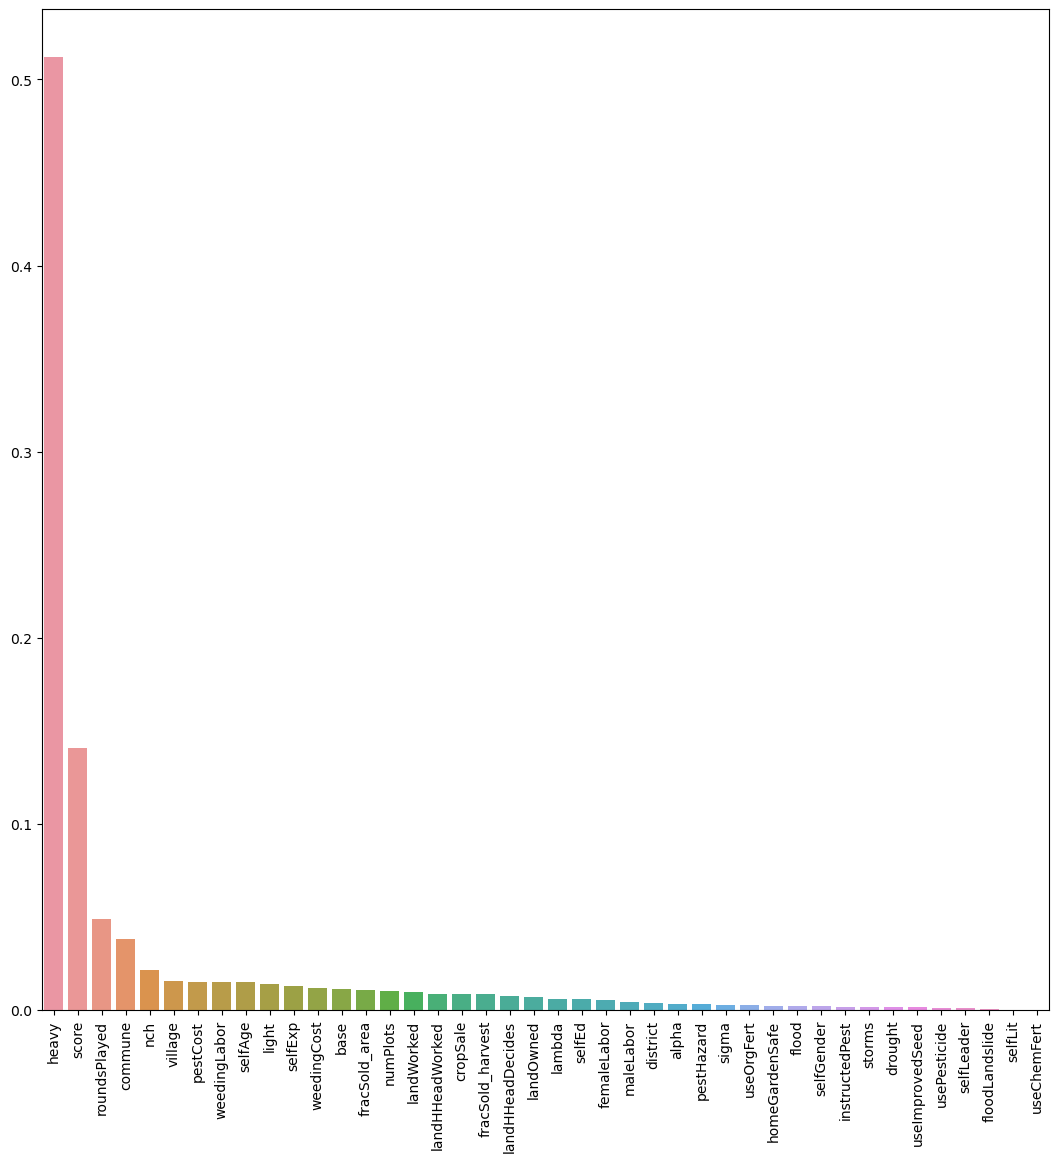

In [118]:
comb=[]
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
categories = list(np.array(comb)[:, 1])
values = list(np.array(comb)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [156]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X = []
Y = []

for i in range(len(curr_csv)):
    # if curr_csv['Round'].iloc[i]==1:
    #     continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corners=[]
        corners.append(np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j))
        rot=(j+1)%4
        corners.append(np.rot90(
            np.array(curr_np[rot//2*3:rot//2*3+3, rot % 2*3:rot % 2*3+3]), rot))
        rot2=(j+3)%4
        corners.append(np.rot90(
            np.array(curr_np[rot2//2*3:rot2//2*3+3, rot2 % 2*3:rot2 % 2*3+3]), rot2))
        
        corner_ind=[j, rot, rot2]
        
        x_add=[]
        x_add.append(curr_csv['roundsPlayed'][i])
        score_arr=calculate_score(i, curr_csv)
        
        it=0    
        for ind in corner_ind:
            x_add.append(score_arr[ind])

            total_cells=[0]*4
            for cell in corners[it].flatten():
                total_cells[cell]+=1

            x_add.extend(total_cells[:3])
            
            player_str="p"+str(ind+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)
            it+=1
            
        edge_cells=[]
        for row in range(3):
            for col in range(3):
                if row==2 or col==2:
                    edge_cells.append(corner[row, col])

        scores=np.zeros((6, 6))
        for row in range(6):
            for col in range(6):
                if curr_np[row, col] == 1:
                    for vert in range(max(0, row-2), min(6, row+3)):
                        # print(row, max(0, row-2), min(6, row+3))
                        for horiz in range(max(0, col-2), min(6, col+3)):
                            if curr_np[vert, horiz] == 1 or curr_np[vert, horiz] == 3:
                                continue
                            scores[vert, horiz] += 2

        for row in range(6):
            for col in range(6):
                if curr_np[row, col] == 3:
                    for vert in range(max(0, row-1), min(6, row+2)):
                        for horiz in range(max(0, col-1), min(6, col+2)):
                            scores[vert, horiz] = 0

        nch_edge=0
        for row in range(6):
            for col in range(6):
                if row==2 or col==2:
                    if scores[row, col]:
                        nch_edge += 1

        X.append(x_add)
        Y.append(nch_edge)
X = np.array(X)
Y = np.array(Y)


In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.8305605687079809


In [160]:
indices_arr=["roundsPlayed"]
# temp=["score", "base", "nch", "light", "heavy"]
temp=["score", "base", "nch", "light"]
temp.extend(characteristics_arr)

for ind in range(1, 4):
    for i in temp:
        indices_arr.append(i+"_"+str(ind))

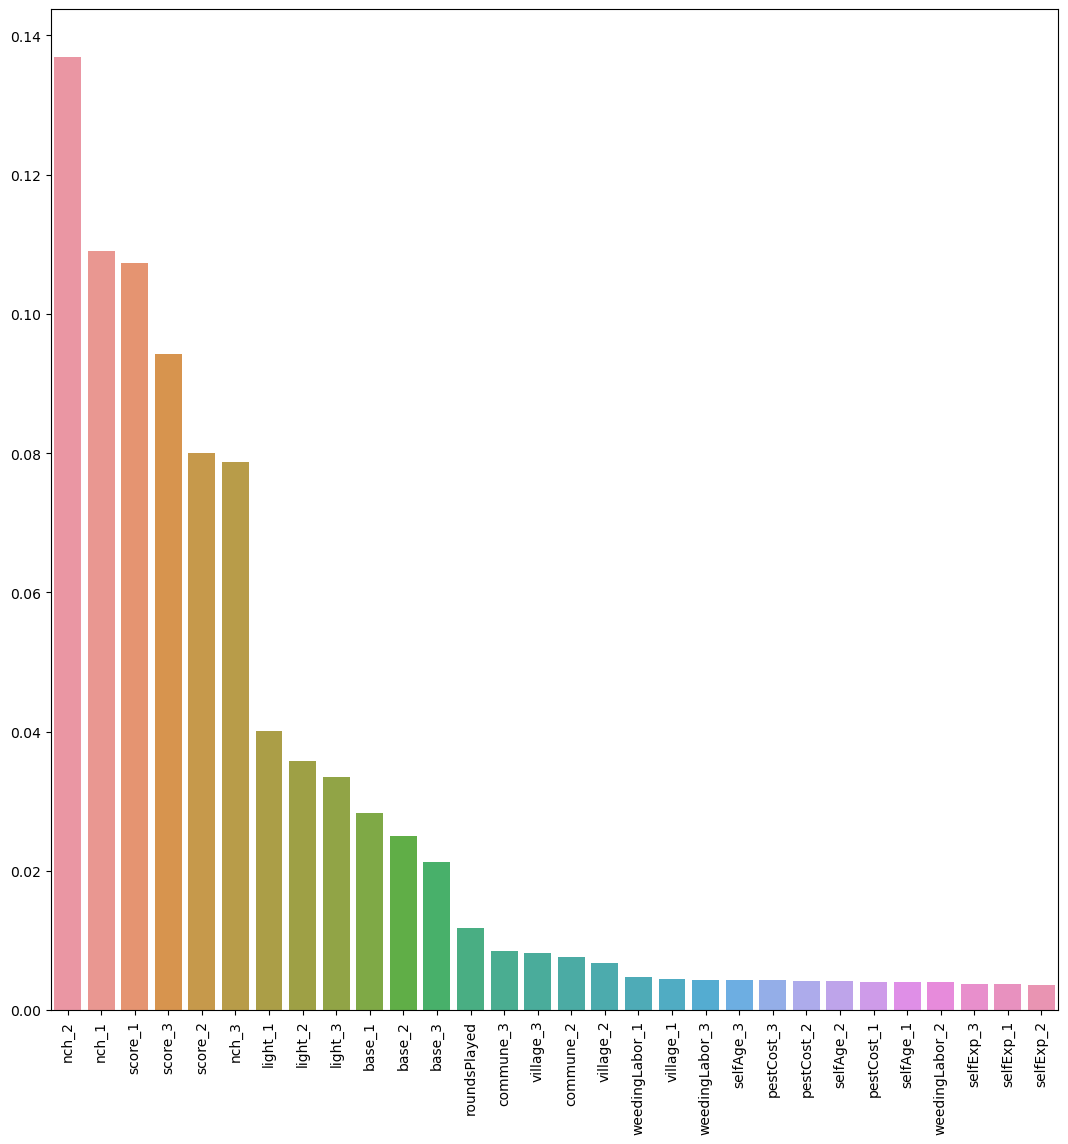

In [161]:
comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:30, 1])
values = list(np.array(comb)[:30, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


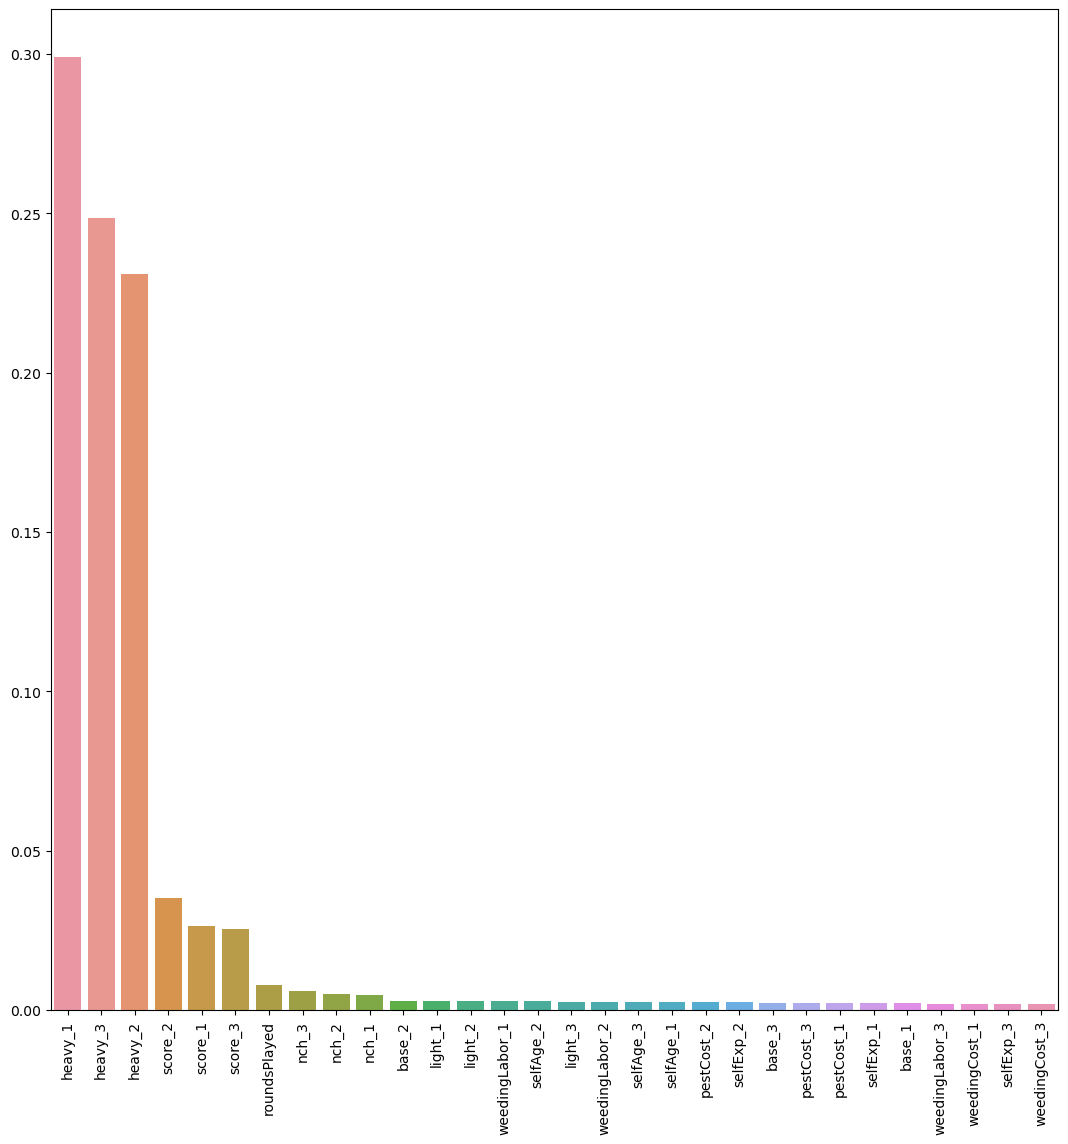

In [ ]:
# heavy spray from self or neighbors heavily decreases "trust"

comb=[]
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:30, 1])
values = list(np.array(comb)[:30, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [179]:
# correlations

correlations=[]
for i in range(X.shape[1]):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)

correlations_filtered=[]
for i in correlations:
    if i[1]=='roundsPlayed' or i[1][-2:]=='_1':
        correlations_filtered.append(i)
        
correlations_filtered=np.array(correlations_filtered


In [180]:
correlations_filtered


array([['0.3668909658043435', 'light_1'],
       ['0.3626358063219669', 'score_1'],
       ['0.2592968890279579', 'nch_1'],
       ['0.15534009432041895', 'base_1'],
       ['0.13770440202315715', 'selfAge_1'],
       ['0.13738953764461168', 'sigma_1'],
       ['0.13202469494649113', 'useImprovedSeed_1'],
       ['0.11513978218379972', 'alpha_1'],
       ['0.11164039748659535', 'selfLit_1'],
       ['0.10541782789076642', 'homeGardenSafe_1'],
       ['0.09637900762675286', 'selfExp_1'],
       ['0.09375267590934946', 'roundsPlayed'],
       ['0.08652183348048663', 'lambda_1'],
       ['0.08145299518402609', 'femaleLabor_1'],
       ['0.07546555776176786', 'selfLeader_1'],
       ['0.07418508675182184', 'maleLabor_1'],
       ['0.06943780849037214', 'pestHazard_1'],
       ['0.06575878531129803', 'useChemFert_1'],
       ['0.060203870086108086', 'pestCost_1'],
       ['0.05538407505545469', 'selfGender_1'],
       ['0.03541026367332179', 'fracSold_area_1'],
       ['0.025071386306707993

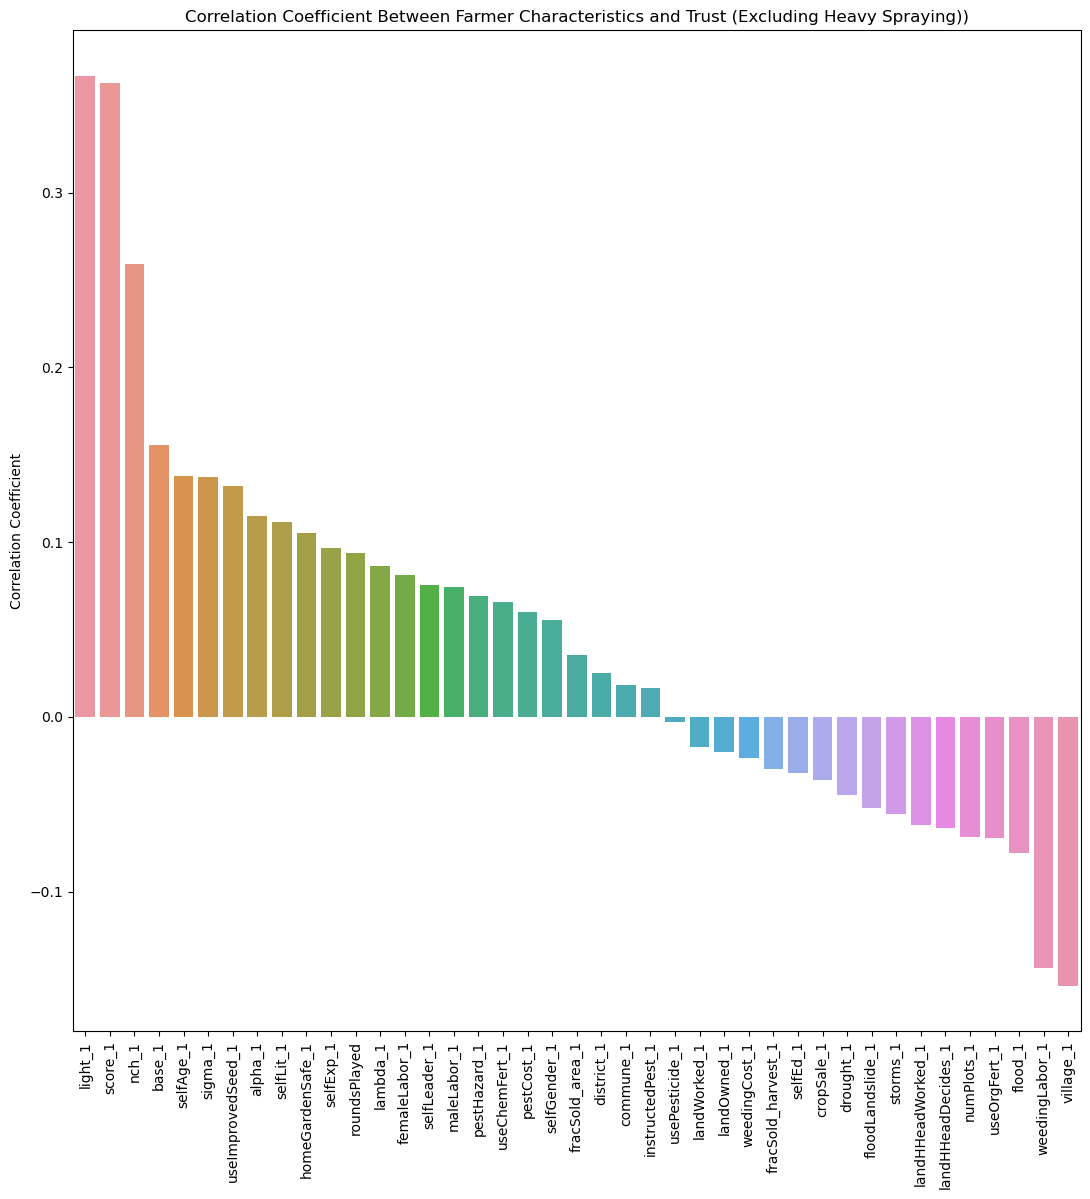

In [181]:

plt.figure(figsize=(13, 13))

categories = list(np.array(correlations_filtered)[:, 1])
values = list(np.array(correlations_filtered)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Trust (Excluding Heavy Spraying))")
plt.ylabel("Correlation Coefficient")
plt.show()

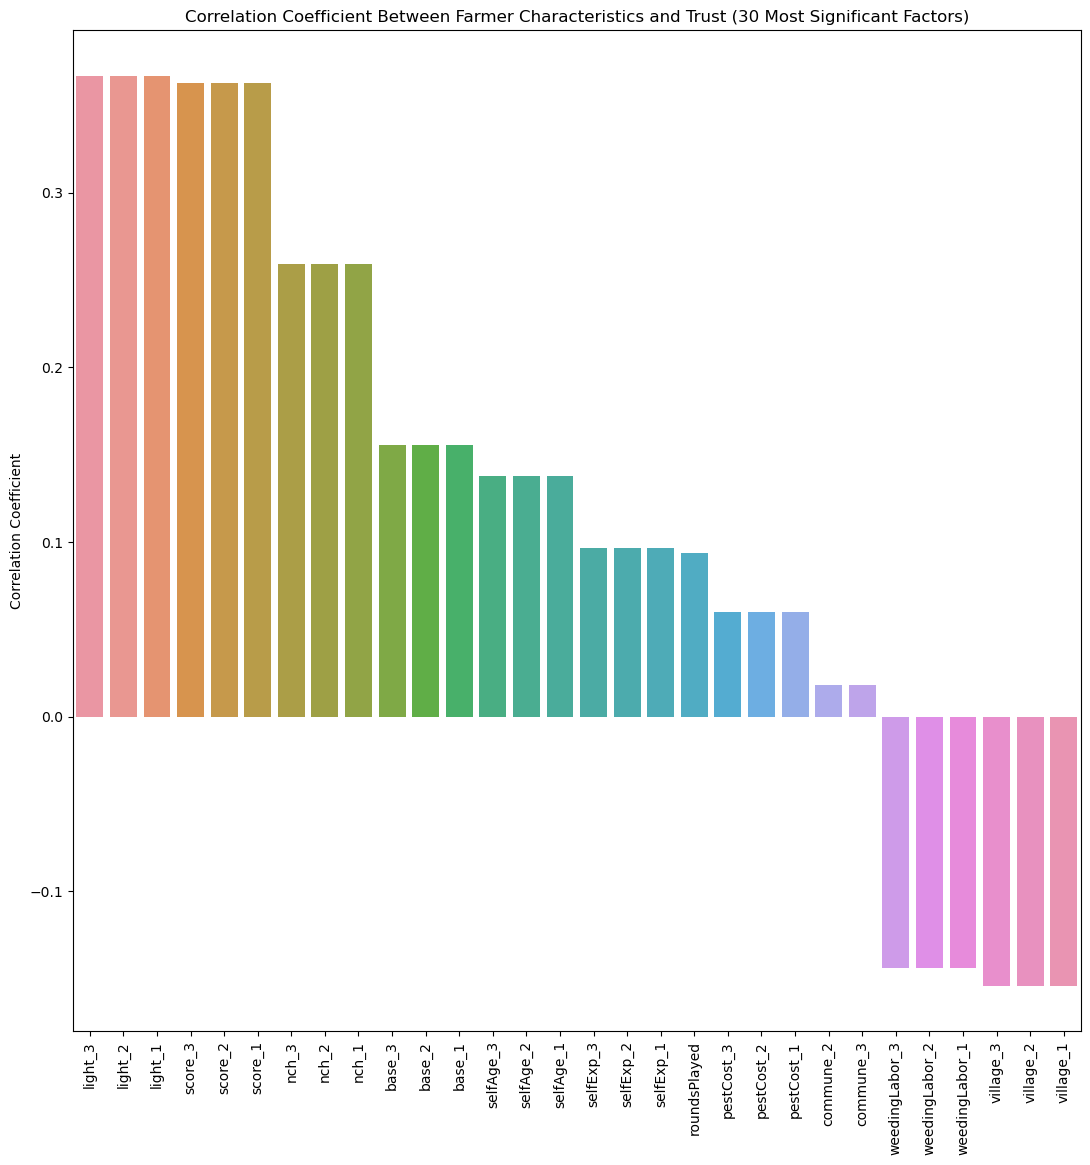

In [172]:

plt.figure(figsize=(13, 13))

categories = list(np.array(correlations_filtered)[:, 1])
values = list(np.array(correlations_filtered)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Trust (30 Most Significant Factors)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [196]:
x=[1,2,3,4]
np.rot90(np.array(x).reshape(2,2), 1).flatten()
# np.array(x).reshape(2, 2)


array([2, 4, 1, 3])

# measuring leadership

In [197]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X = []
Y = []

for i in range(len(curr_csv)):

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corners=[]
        corners.append(np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j))
        
        x_add=[]
        x_add.append(curr_csv['roundsPlayed'][i])
        score_arr=np.array(calculate_score(i, curr_csv)).reshape(2,2)
        score_arr=np.rot90(score_arr, 1).flatten().tolist()

        x_add.extend(score_arr)
        total_cells=[0]*4
        for cell in corners[0].flatten():
            total_cells[cell]+=1
        x_add.extend(total_cells)
        
        player_str="p"+str(j+1)+"_"
        chars=[]
        for char in characteristics_arr:
            col_ind=player_str+char
            val = curr_csv[col_ind][i]
            if pd.isna(val):
                chars.append(-1)
            else:
                chars.append(val)
        x_add.extend(chars)
        
        share_label=0
        curr_label=labels_full[i*4+j]
        for k in range(4):
            if k!=j:
                share_label+= curr_label==labels_full[i*4+k]
                
        X.append(x_add)
        Y.append(share_label)



X = np.array(X)
Y = np.array(Y)

In [198]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.6963548266532601


In [205]:
indices_arr = ["roundsPlayed", "score_1", "score_2", "score_3", "score_4", "base", "nch", "light", "heavy"]
# temp=["score", "base", "nch", "light", "heavy"]
# temp=["score", "base", "nch", "light"]
indices_arr.extend(characteristics_arr)


In [204]:
len(model.feature_importances_)

45

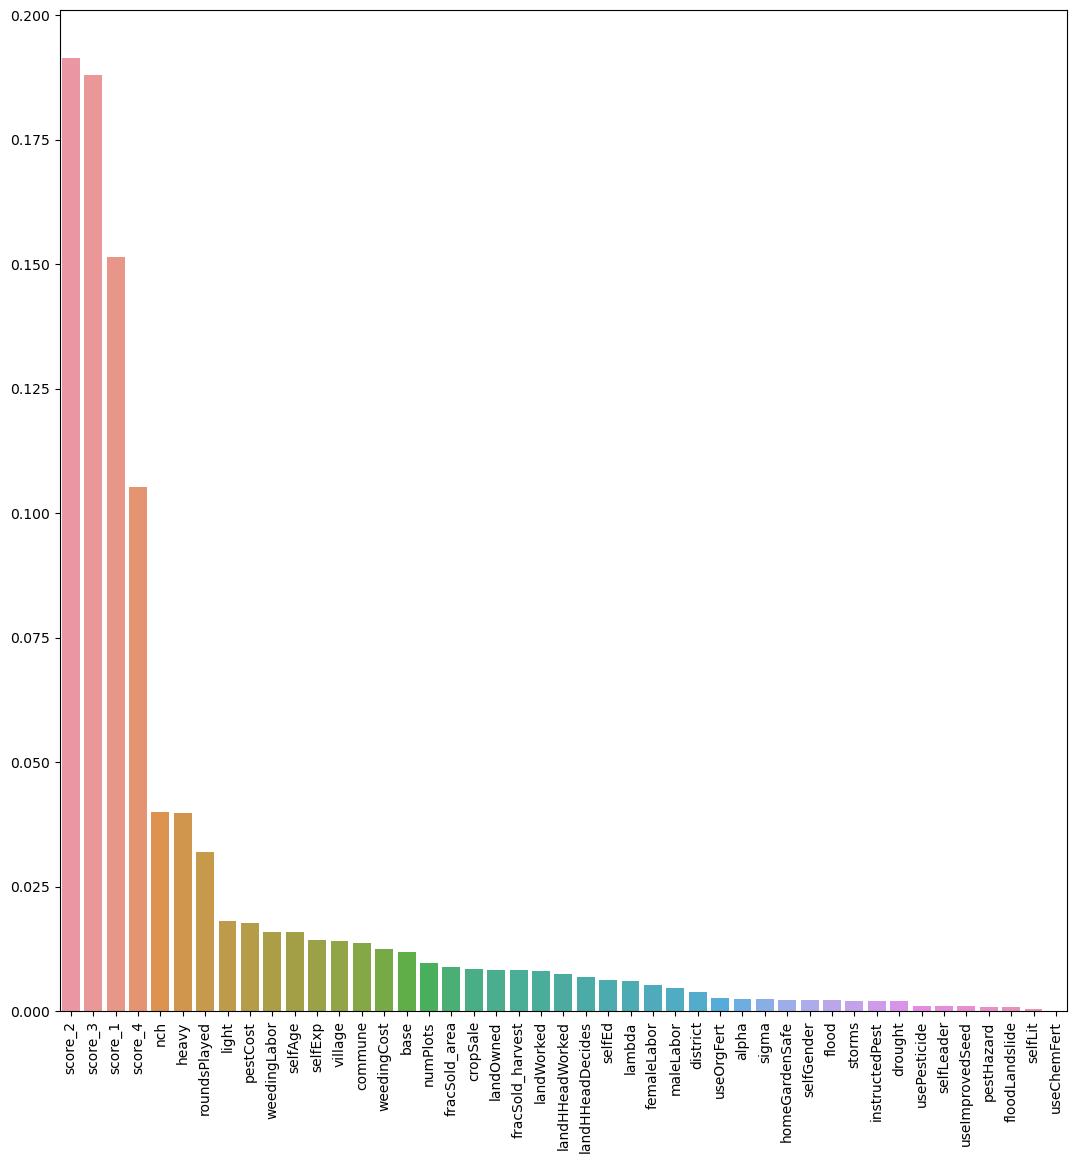

In [206]:
comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:, 1])
values = list(np.array(comb)[:, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [207]:
# correlations

correlations=[]
for i in range(X.shape[1]):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)

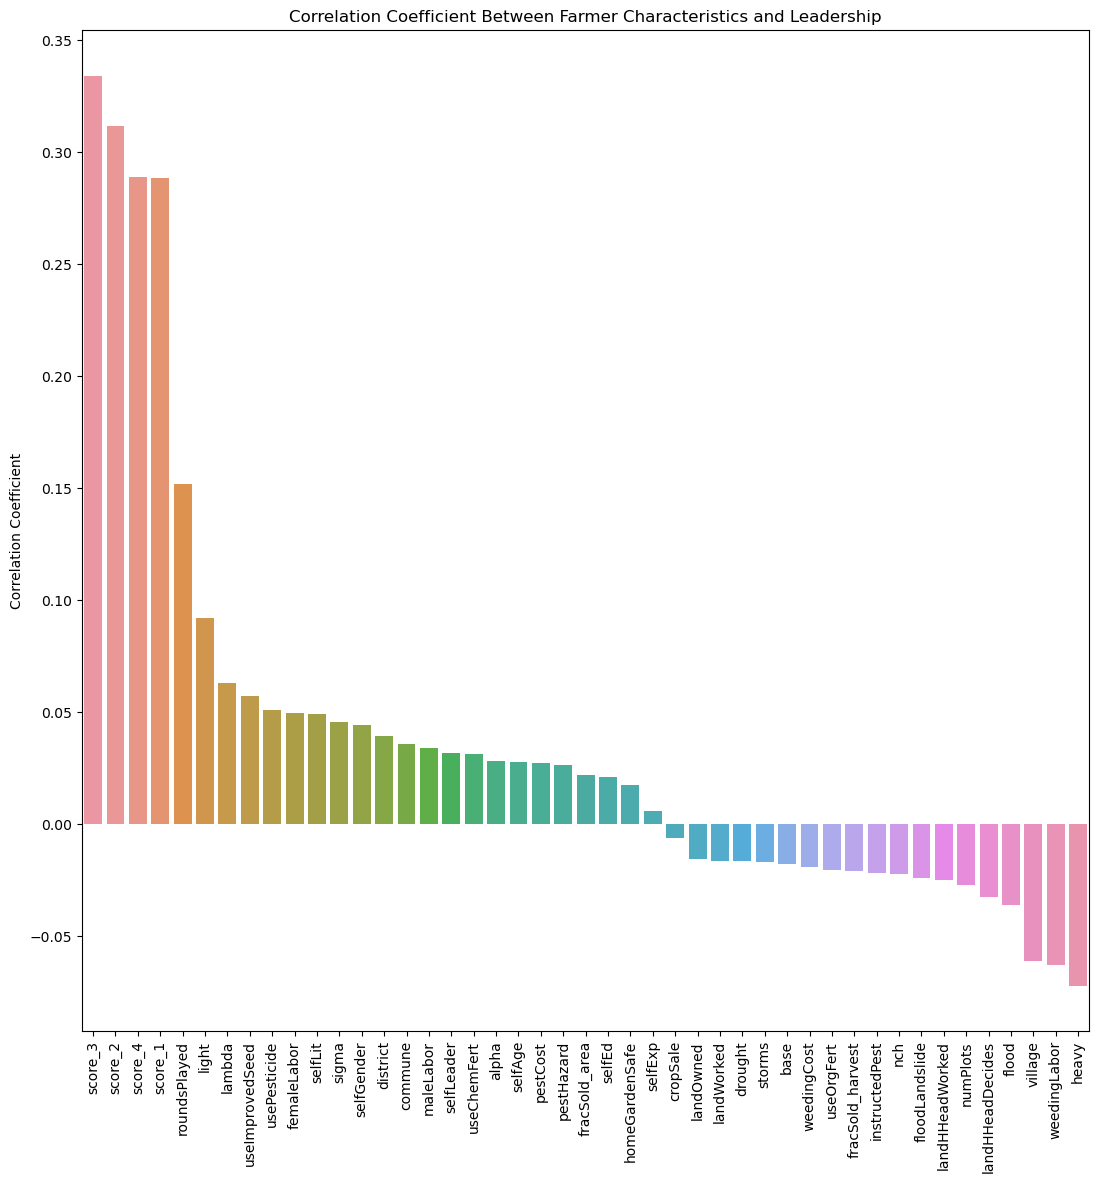

In [209]:

plt.figure(figsize=(13, 13))

categories = list(np.array(correlations)[:, 1])
values = list(np.array(correlations)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Leadership")
plt.ylabel("Correlation Coefficient")
plt.show()

In [236]:

curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X = []
Y = []

curr_shares=[0]*4

for i in range(len(curr_csv)-1):
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corners=[]
        corners.append(np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j))
        # rot=(j+1)%4
        # corners.append(np.rot90(
        #     np.array(curr_np[rot//2*3:rot//2*3+3, rot % 2*3:rot % 2*3+3]), rot))
        # rot2=(j+3)%4
        # corners.append(np.rot90(
        #     np.array(curr_np[rot2//2*3:rot2//2*3+3, rot2 % 2*3:rot2 % 2*3+3]), rot2))
        
        # corner_ind=[j, rot, rot2]

        share_label=0
        curr_label=labels_full[i*4+j]

        # if curr_label!=next_label:
        #     continue

        for k in range(4):
            if k!=j:
                share_label+= curr_label==labels_full[i*4+k]

        curr_shares[j]+=share_label

        # if share_label>0:
        #     share_label=1
        # elif share_label<=0:
        #     share_label=0
        
    if curr_csv['roundsPlayed'][i+1]==1:
        for j in range(4):
            x_add=[]
            player_str="p"+str(j+1)+"_"
            chars=[]
            for char in characteristics_arr:
                col_ind=player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            X.append(x_add)
            Y.append(curr_shares[j]/(curr_csv['roundsPlayed'][i]*3))


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)

r2:  0.1121265537403141


In [234]:
increase=0
decrease=0

for i in y_pred:
    increase+=i==1
    decrease+=i==0

print(increase/len(y_pred))
print(decrease/len(y_pred))

0.14129810453762207
0.858701895462378


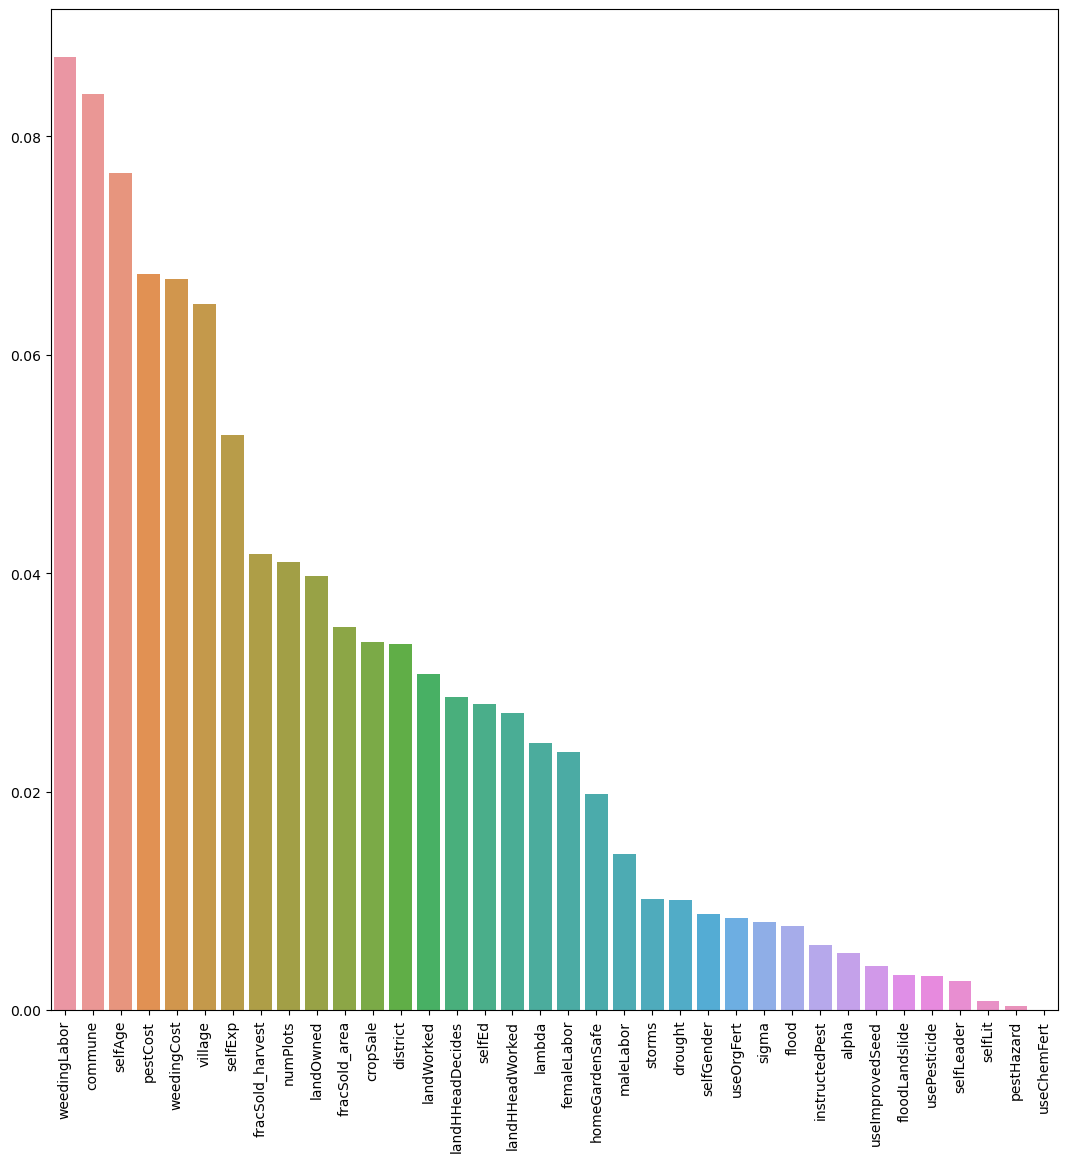

In [240]:
comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:, 1])
values = list(np.array(comb)[:, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [249]:
# predicting whether they will change labels next round
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X = []
Y = []

for i in range(len(curr_csv)-1):
    if curr_csv['roundsPlayed'][i+1]==1:
        continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
        # print(prev_round)
        # print(curr_round)

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corners = []
        corners.append(np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j))

        x_add = []
        x_add.append(curr_csv['roundsPlayed'][i])
        score_arr = np.array(calculate_score(i, curr_csv)).reshape(2, 2)
        score_arr = np.rot90(score_arr, j).flatten().tolist()

        x_add.extend(score_arr)
        total_cells = [0]*4
        for cell in corners[0].flatten():
            total_cells[cell] += 1
        x_add.extend(total_cells)

        player_str = "p"+str(j+1)+"_"
        chars = []
        for char in characteristics_arr:
            col_ind = player_str+char
            val = curr_csv[col_ind][i]
            if pd.isna(val):
                chars.append(-1)
            else:
                chars.append(val)
        x_add.extend(chars)

        share_label = 0
        curr_label = labels_full[i*4+j]
        next_label = labels_full[(i+1)*4+j]
        
        change=curr_label!=next_label

        X.append(x_add)
        Y.append(change)

X = np.array(X)
Y = np.array(Y)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)


In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = accuracy_score(Y_test, y_pred)
print('accuracy: ', r2)

accuracy:  0.686674325100517


In [ ]:
increase=0
decrease=0

for i in y_pred:
    increase+=i==1
    decrease+=i==0

print(increase/len(y_pred))
print(decrease/len(y_pred))

0.14129810453762207
0.858701895462378


In [251]:
indices_arr = ["roundsPlayed", "score_1", "score_2", "score_3", "score_4", "base", "nch", "light", "heavy"]
# temp=["score", "base", "nch", "light", "heavy"]
# temp=["score", "base", "nch", "light"]
indices_arr.extend(characteristics_arr)


In [ ]:
len(model.feature_importances_)

45

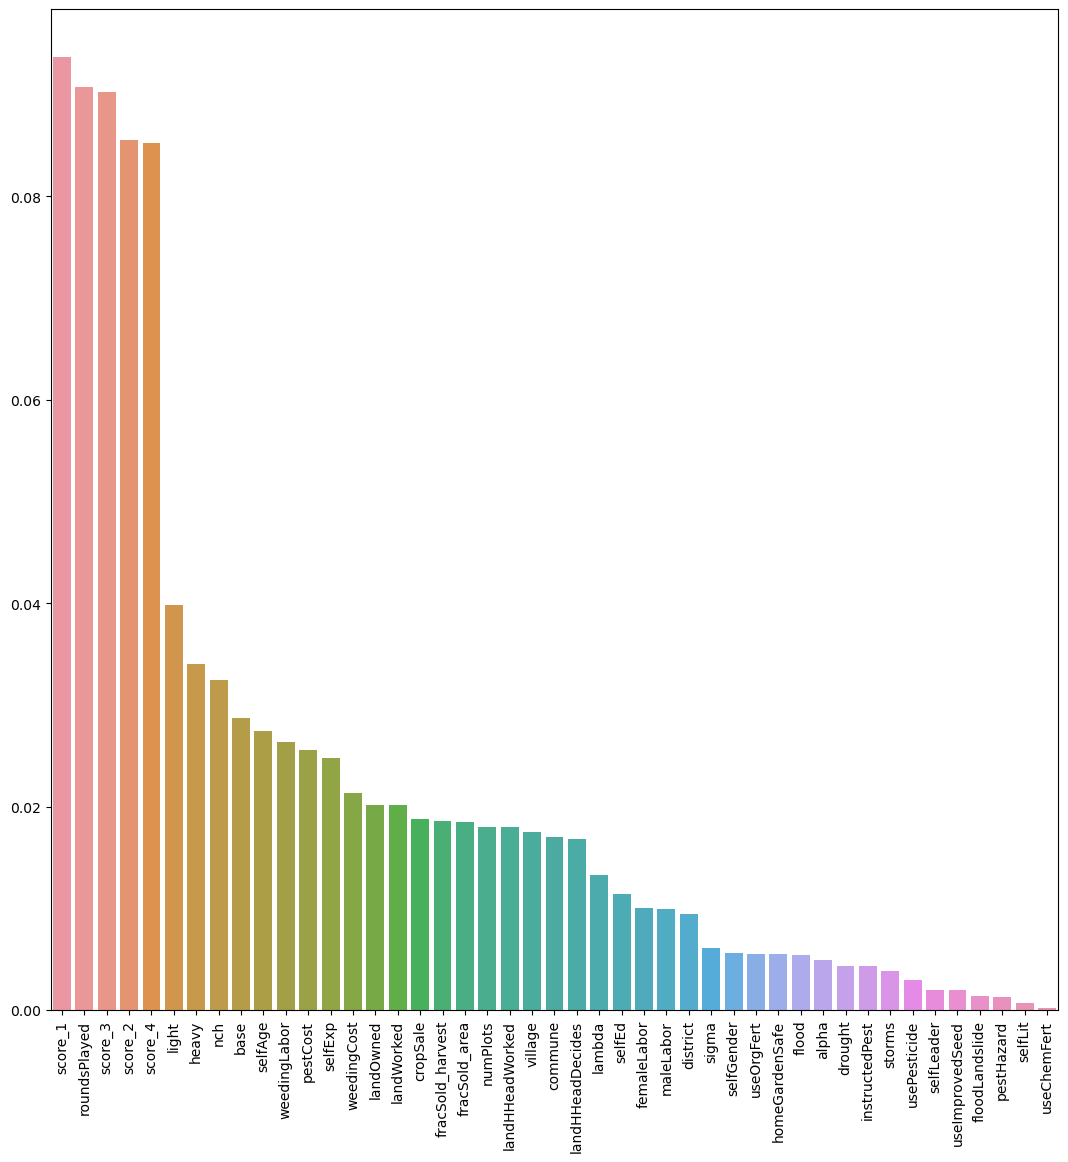

In [252]:
comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:, 1])
values = list(np.array(comb)[:, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [253]:
# correlations

correlations=[]
for i in range(X.shape[1]):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)

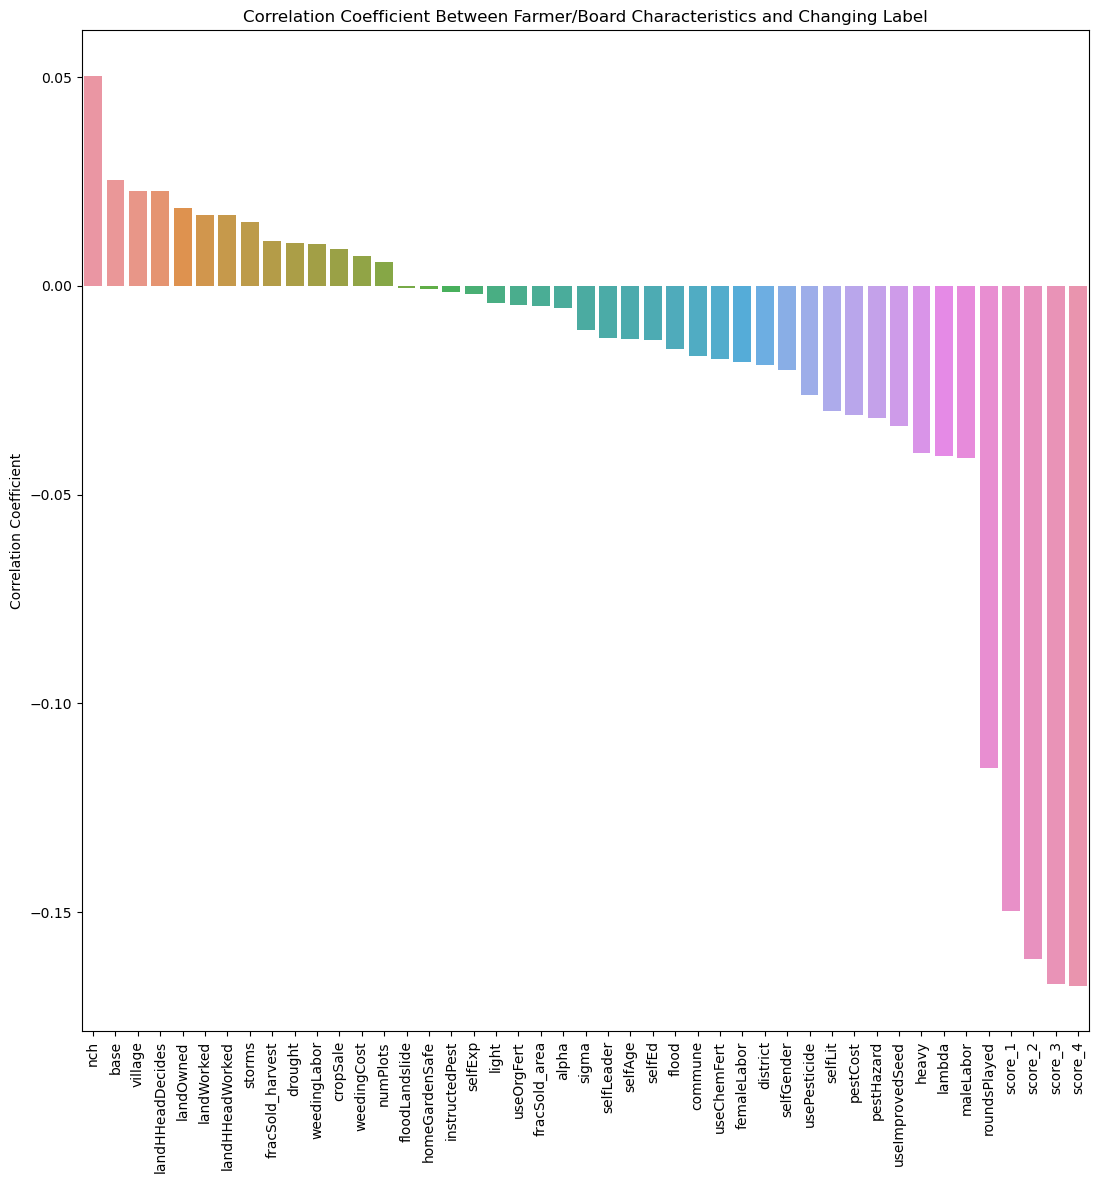

In [254]:

plt.figure(figsize=(13, 13))

categories = list(np.array(correlations)[:, 1])
values = list(np.array(correlations)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer/Board Characteristics and Changing Label")
plt.ylabel("Correlation Coefficient")
plt.show()

# what affects trust/change in similarity

In [367]:
# predicting an increase in similarity
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
next_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area",
                       "district_1", "district_2", "district_3", "district_4", "district_5", "district_6", "commune_101", "commune_102", "commune_103", "commune_201", "commune_202", "commune_301", "commune_302",
                       "commune_303", "commune_304", "commune_305", "commune_306", "commune_401", "commune_501", "commune_601", "commune_602", "village_1", "village_2", "village_4", "village_7", "village_9",
                       "village_10", "village_12", "village_14", "village_15", "village_16", "village_19", "village_20", "village_21", "village_22", "village_24"]

X = []
Y = []

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    for j in range(40, 76):
        next_round[j-40] = curr_csv.iloc[i+1, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    next_np = np.array(next_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner_next = np.rot90(
                np.array(next_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            corner2_next = np.rot90(
                np.array(next_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)

            curr_similarity = calculate_similarity(corner, corner2)
            next_similarity = calculate_similarity(corner_next, corner2_next)
            # if(next_similarity <= curr_similarity):
            #     continue

            # similarity1 = calculate_similarity(corner, corner_next)
            # similarity2 = calculate_similarity(corner2, corner2_next)

            Y.append(next_similarity > curr_similarity)

            x_add = [int(abs(k-j) == 1 or abs(k-j) == 3)]
            x_add.append(curr_csv['roundsPlayed'][i])

            temp = calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])
            x_add.append(temp[k])

            total_cells = [0]*4
            for cell in corner.flatten():
                total_cells[cell] += 1
            for cell in corner2.flatten():
                total_cells[cell] += 1

            x_add.extend(total_cells)
            # adjacent is 1, opposite is 0

            player_str = "p"+str(j+1)+"_"
            chars = []
            for char in characteristics_arr:
                col_ind = player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            player_str = "p"+str(k+1)+"_"
            chars = []
            for char in characteristics_arr:
                col_ind = player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            # x_add=np.array(x_add).flatten()
            X.append(x_add)


X = np.array(X)
Y = np.array(Y)

In [368]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = accuracy_score(Y_test, y_pred)
print('accuracy: ', r2)

accuracy:  0.5696614583333334


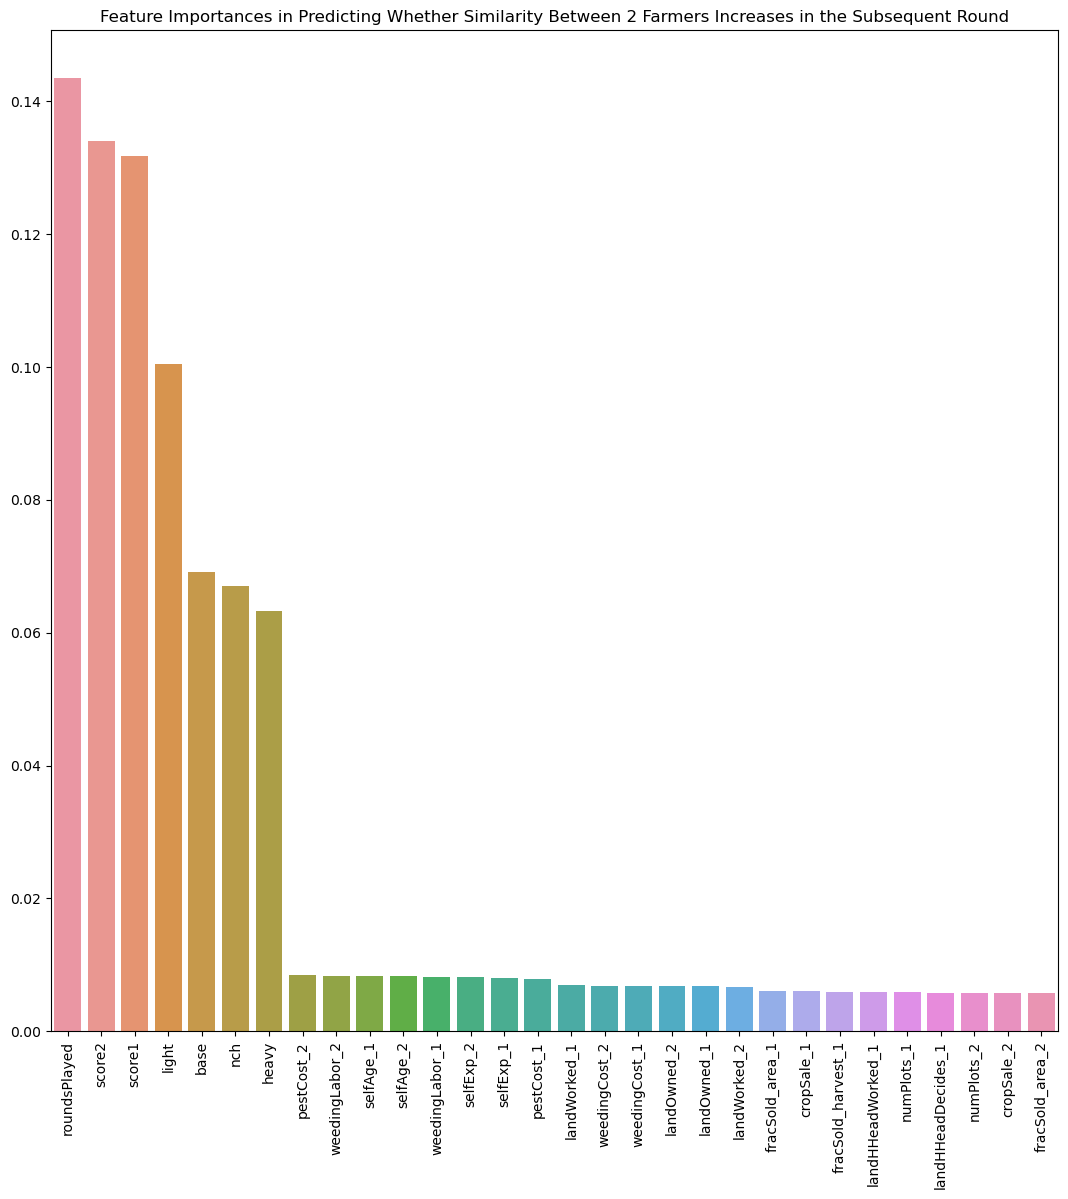

In [371]:
indices_arr = ["diagonal", "roundsPlayed", "score1",
               "score2", "base", "nch", "light", "heavy"]
for i in characteristics_arr:
    temp = i+"_1"
    indices_arr.append(temp)
for i in characteristics_arr:
    temp = i+"_2"
    indices_arr.append(temp)

comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:30, 1])
values = list(np.array(comb)[:30, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.title("Feature Importances in Predicting Whether Similarity Between 2 Farmers Increases in the Subsequent Round")
plt.xticks(rotation=90)
plt.show()


In [383]:
# correlations

correlations=[]

for i in range(8, X.shape[1]):
    print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)

cropSale_1 (-0.008169658561397898, 0.21496785171822552)
weedingCost_1 (-0.0033144176374184575, 0.6149169482978866)
weedingLabor_1 (0.011001598065013659, 0.09494209827383467)
pestCost_1 (-0.009627850460005484, 0.14391680175801858)
numPlots_1 (0.0001729073673667125, 0.979062665733507)
flood_1 (-0.001913996469828716, 0.771427064562108)
floodLandslide_1 (0.004019099094454698, 0.5418447736874306)
drought_1 (0.007173827086042316, 0.2762132809027645)
storms_1 (0.007995715295822528, 0.22489370682116017)
landWorked_1 (-0.00014143394042628312, 0.9828731290819247)
landOwned_1 (-0.0008207568474839404, 0.9008597110253308)
landHHeadWorked_1 (-0.0007301100531564414, 0.9117615307664312)
landHHeadDecides_1 (0.000151510854480648, 0.981653078238356)
femaleLabor_1 (-0.009234616430156124, 0.16101379717836317)
maleLabor_1 (0.0036424563336599504, 0.5803607619706633)
selfGender_1 (-0.0026525984049424133, 0.6872314791361005)
selfAge_1 (-0.014639416082445816, 0.02627616795980107)
selfEd_1 (0.014281479149601341,

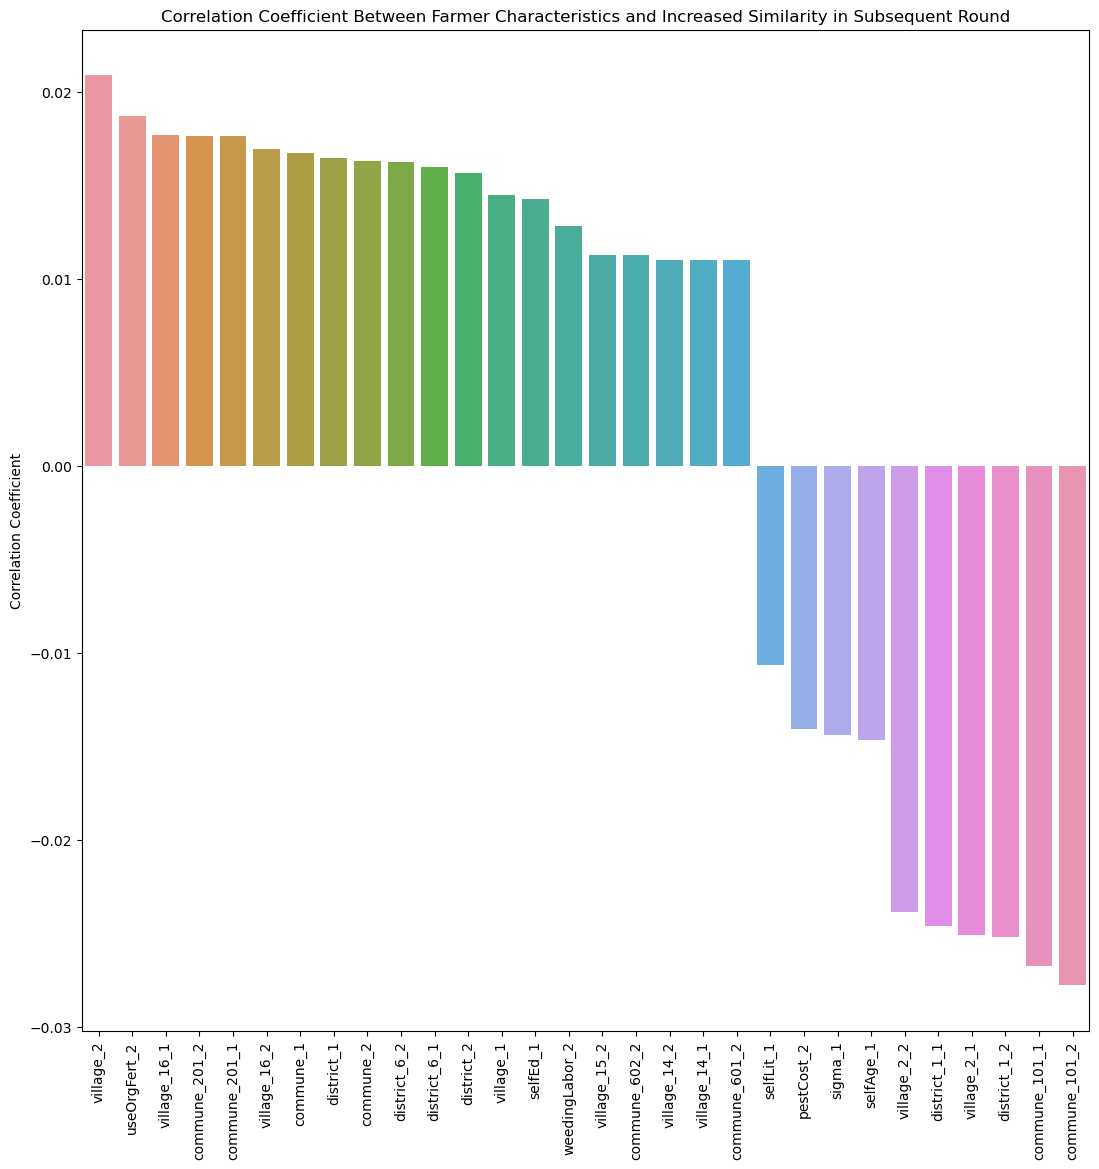

In [384]:
plt.figure(figsize=(13, 13))

categories = list(np.append(np.array(correlations)[:20, 1], np.array(correlations)[-10:, 1]))
values = list(np.append(np.array(correlations)[:20, 0], np.array(correlations)[-10:, 0]))

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Increased Similarity in Subsequent Round")
plt.ylabel("Correlation Coefficient")
plt.show()

In [385]:
# correlations

correlations = []

for i in range(8):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)


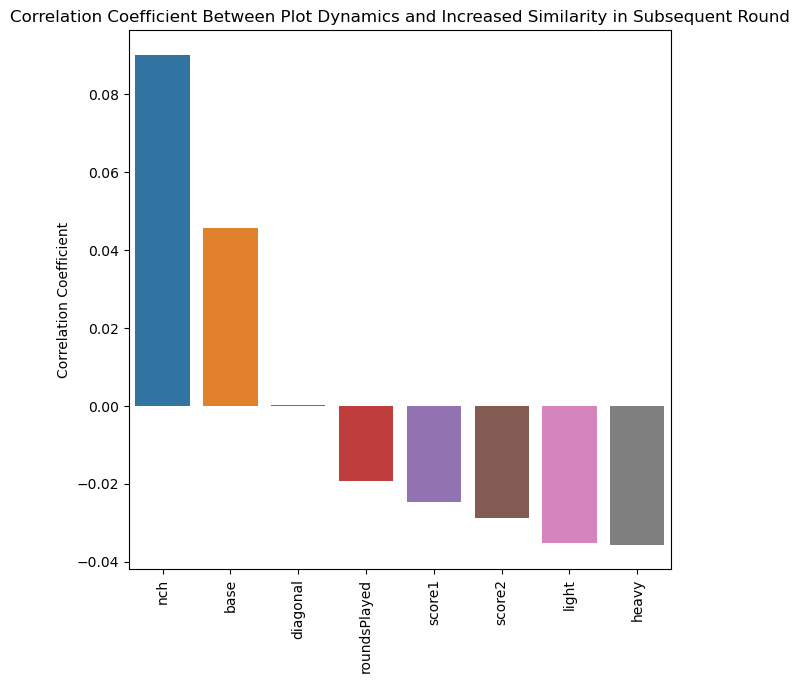

In [387]:
plt.figure(figsize=(7, 7))

categories = list(np.array(correlations)[:, 1])
values = list(np.array(correlations)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Plot Dynamics and Increased Similarity in Subsequent Round")
plt.ylabel("Correlation Coefficient")
plt.show()

In [46]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
next_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area",
                       "district_1", "district_2", "district_3", "district_4", "district_5", "district_6", "commune_101", "commune_102", "commune_103", "commune_201", "commune_202", "commune_301", "commune_302",
                       "commune_303", "commune_304", "commune_305", "commune_306", "commune_401", "commune_501", "commune_601", "commune_602", "village_1", "village_2", "village_4", "village_7", "village_9",
                       "village_10", "village_12", "village_14", "village_15", "village_16", "village_19", "village_20", "village_21", "village_22", "village_24"]

X = []
Y = []

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1]==1:
        continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    for j in range(40, 76):
        next_round[j-40] = curr_csv.iloc[i+1, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    next_np= np.array(next_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner_next = np.rot90(
                np.array(next_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            corner2_next = np.rot90(
                np.array(next_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            
            curr_similarity=calculate_similarity(corner, corner2)
            next_similarity=calculate_similarity(corner_next, corner2_next)
            if(next_similarity<=curr_similarity):
                continue

            similarity1=calculate_similarity(corner, corner_next)
            similarity2=calculate_similarity(corner2, corner2_next)

            Y.append(abs(similarity1-similarity2))

            x_add = [int(abs(k-j) == 1 or abs(k-j) == 3)]
            x_add.append(curr_csv['roundsPlayed'][i])

            temp = calculate_score_csv(i, curr_csv)
            x_add.append(abs(temp[j]-temp[k]))

            total_cells = [0]*4
            for cell in corner.flatten():
                total_cells[cell] += 1
            for cell in corner2.flatten():
                total_cells[cell] += 1

            x_add.extend(total_cells)
            # adjacent is 1, opposite is 0

            player_str = "p"+str(j+1)+"_"
            player_str2 = "p"+str(k+1)+"_"
            chars = []
            for char in characteristics_arr:
                col_ind = player_str+char
                val = curr_csv[col_ind][i]
                col_ind2 = player_str2+char
                val2 = curr_csv[col_ind2][i]
                if pd.isna(val) or pd.isna(val2):
                    chars.append(-1)
                else:
                    chars.append(abs(val-val2))
            x_add.extend(chars)

            X.append(x_add)


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestRegressor()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print('r2: ', r2)


r2:  0.10795992832518297


In [49]:
model.feature_importances_

array([5.50477842e-03, 1.07206331e-01, 1.15580146e-01, 5.20128523e-02,
       4.94386300e-02, 9.90892157e-02, 8.19365991e-02, 3.64122026e-02,
       3.33369415e-02, 3.42359423e-02, 3.94453075e-02, 1.93144129e-02,
       5.14759738e-03, 1.81759529e-03, 4.66454010e-03, 5.84075955e-03,
       1.85633480e-02, 2.37277586e-02, 1.94667279e-02, 1.89898750e-02,
       9.22444221e-03, 1.09526067e-02, 5.97963427e-03, 3.27983455e-02,
       1.24236100e-02, 3.16496381e-02, 1.04423703e-03, 3.03496607e-03,
       4.85607196e-03, 1.77268242e-03, 3.99184960e-05, 4.67942226e-05,
       7.03386192e-04, 5.54271130e-03, 5.76750575e-03, 1.60439430e-02,
       3.28756123e-03, 1.94145831e-03, 3.87564901e-03, 5.65913141e-03,
       5.06140280e-03, 2.68863372e-02, 3.38332957e-02, 1.31411253e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.87776282e-04, 2.84020717e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

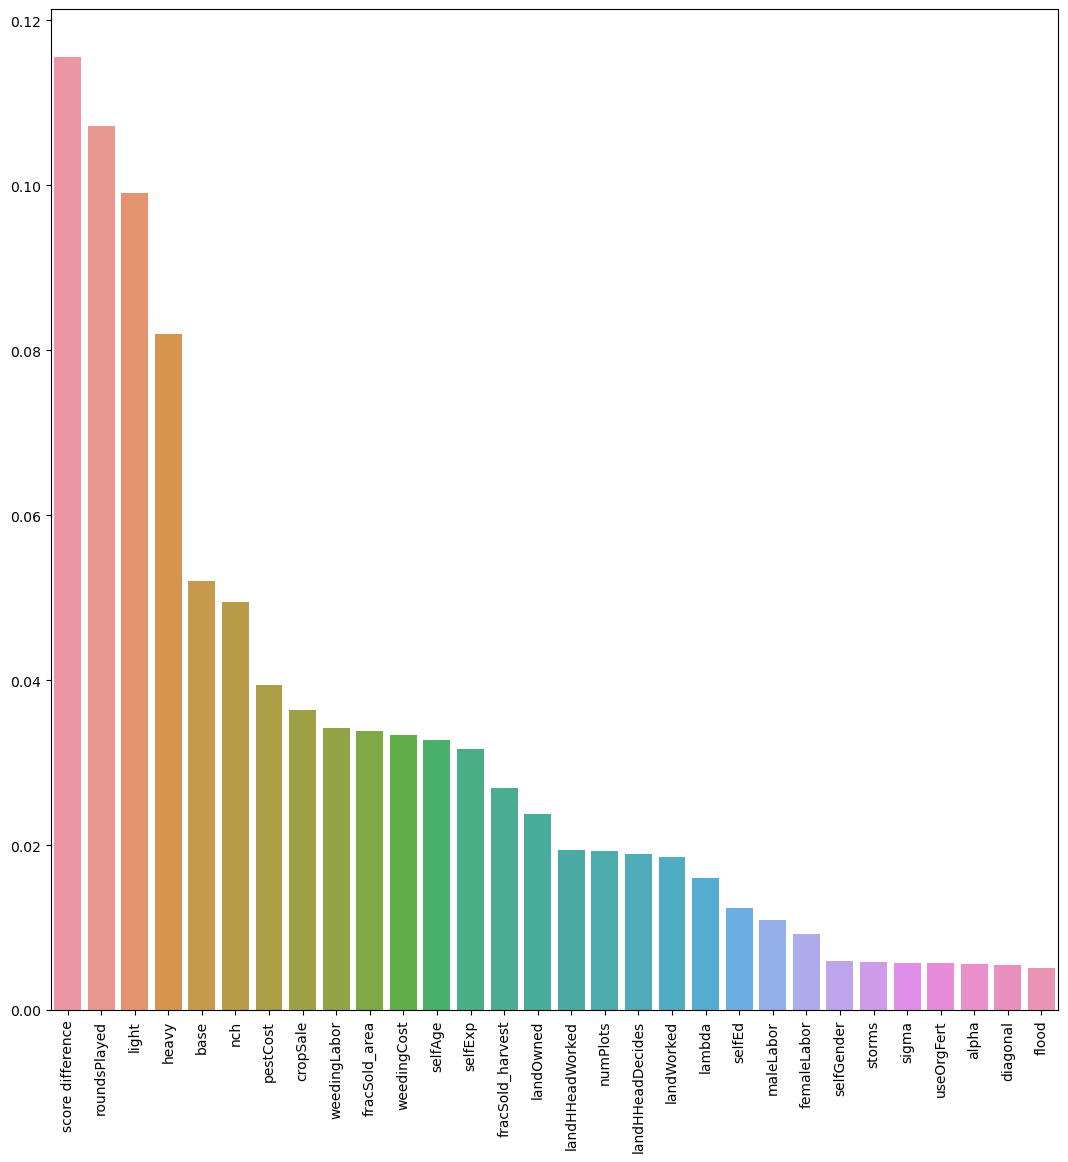

In [50]:
# heavy spray from self or neighbors heavily decreases "trust"

indices_arr=["diagonal", "roundsPlayed", "score difference", "base", "nch", "light", "heavy"]
for i in characteristics_arr:
    temp=i
    indices_arr.append(temp)
# for i in characteristics_arr:
#     temp=i+"_2"
#     indices_arr.append(temp)

comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:30, 1])
values = list(np.array(comb)[:30, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [396]:
# correlations

correlations=[]

for i in range(8, X.shape[1]):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)

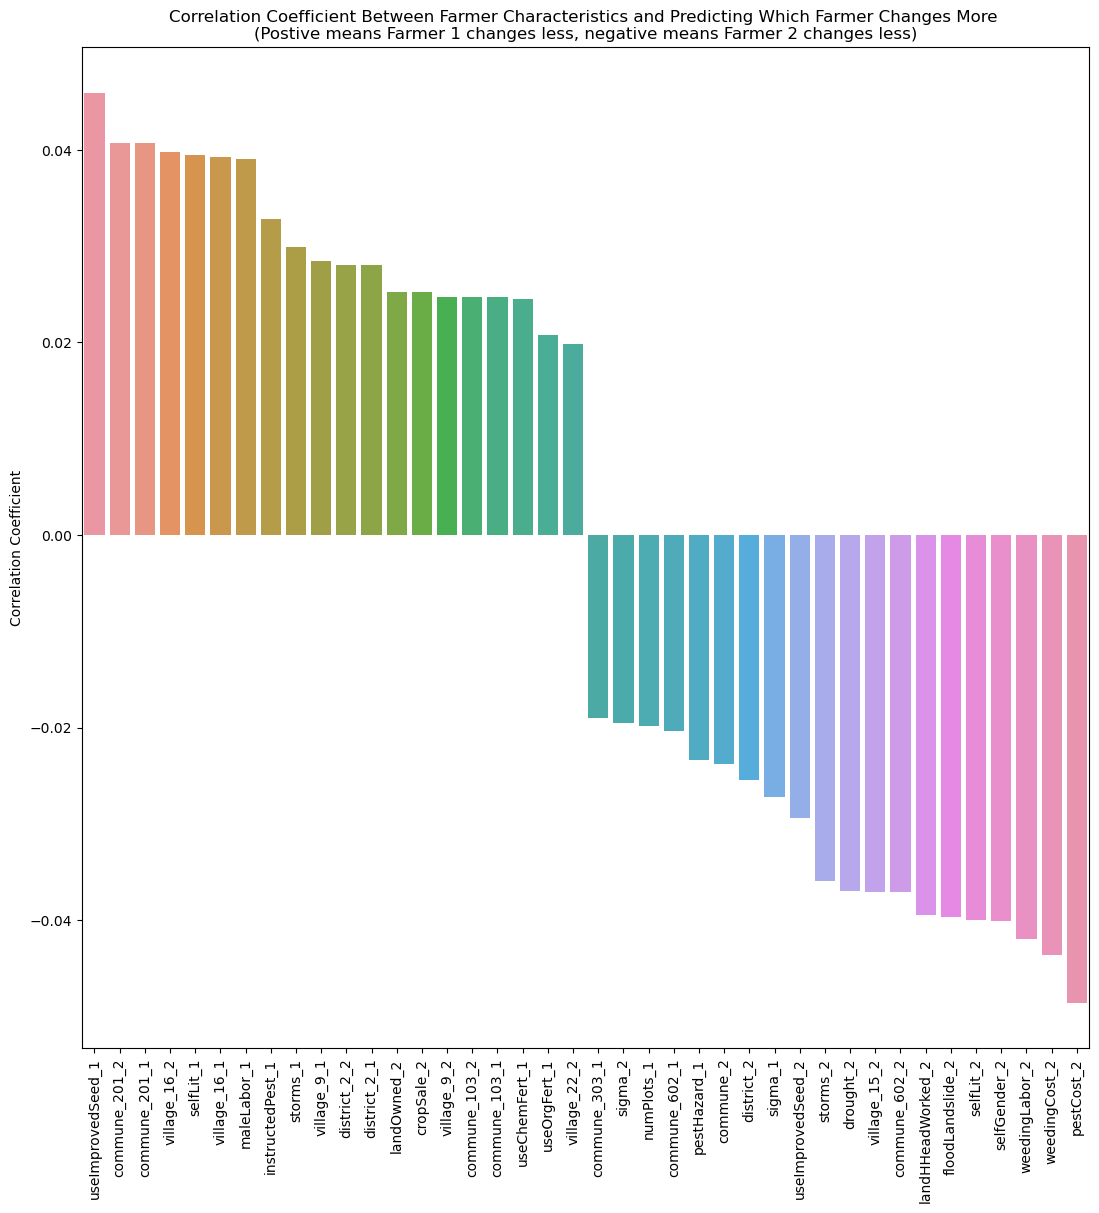

In [399]:
plt.figure(figsize=(13, 13))

categories = list(np.append(np.array(correlations)[:20, 1], np.array(correlations)[-20:, 1]))
values = list(np.append(np.array(correlations)[:20, 0], np.array(correlations)[-20:, 0]))

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Farmer Characteristics and Predicting Which Farmer Changes More \n(Postive means Farmer 1 changes less, negative means Farmer 2 changes less)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [393]:
# correlations

correlations = []

for i in range(8):
    # print(indices_arr[i], pearsonr(X[:, i], Y))
    correlations.append([pearsonr(X[:, i], Y)[0], indices_arr[i]])
correlations.sort(reverse=True)
correlations = np.array(correlations)


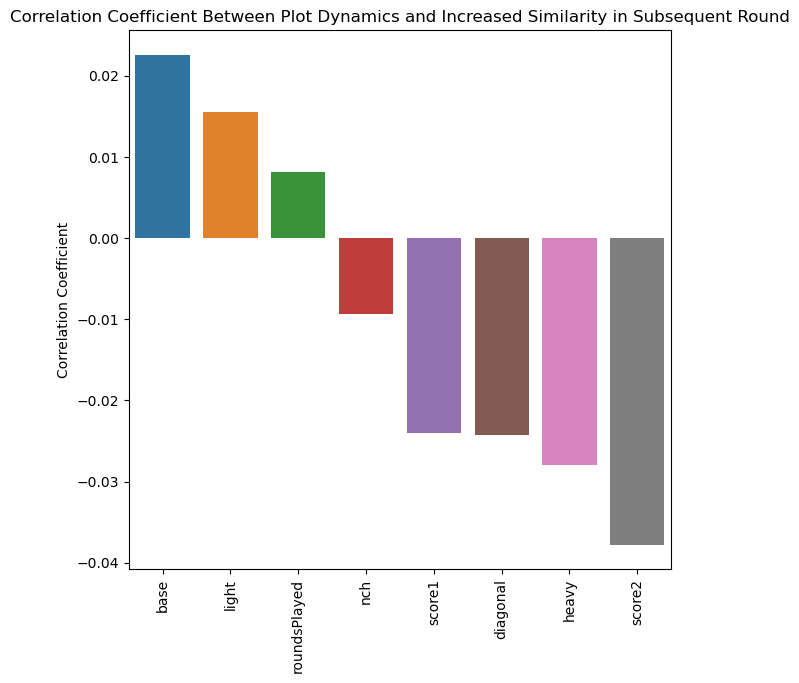

In [394]:
plt.figure(figsize=(7, 7))

categories = list(np.array(correlations)[:, 1])
values = list(np.array(correlations)[:, 0])

values=[float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.title("Correlation Coefficient Between Plot Dynamics and Increased Similarity in Subsequent Round")
plt.ylabel("Correlation Coefficient")
plt.show()

# Does someone switching off of nch often lead to other farmers also switching off?

In [ ]:
curr_csv = vietnam_csv

curr_round = [0 for i in range(36)]
next_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area",
                       "district_1", "district_2", "district_3", "district_4", "district_5", "district_6", "commune_101", "commune_102", "commune_103", "commune_201", "commune_202", "commune_301", "commune_302",
                       "commune_303", "commune_304", "commune_305", "commune_306", "commune_401", "commune_501", "commune_601", "commune_602", "village_1", "village_2", "village_4", "village_7", "village_9",
                       "village_10", "village_12", "village_14", "village_15", "village_16", "village_19", "village_20", "village_21", "village_22", "village_24"]

X = []
Y = []

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1]==1:
        continue

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    for j in range(40, 76):
        next_round[j-40] = curr_csv.iloc[i+1, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    next_np= np.array(next_round).reshape(6, 6)
    for j in range(4):
        for k in range(j+1, 4):
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner_next = np.rot90(
                np.array(next_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            corner2 = np.rot90(
                np.array(curr_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            corner2_next = np.rot90(
                np.array(next_np[k//2*3:k//2*3+3, k % 2*3:k % 2*3+3]), k)
            
            curr_similarity=calculate_similarity(corner, corner2)
            next_similarity=calculate_similarity(corner_next, corner2_next)
            if(next_similarity<=curr_similarity):
                continue

            similarity1=calculate_similarity(corner, corner_next)
            similarity2=calculate_similarity(corner2, corner2_next)

            if(similarity1-similarity2!=0):
                Y.append((similarity1-similarity2)/abs(similarity1-similarity2))
            else:
                Y.append((similarity1-similarity2))

            x_add = [int(abs(k-j) == 1 or abs(k-j) == 3)]
            x_add.append(curr_csv['roundsPlayed'][i])

            temp = calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])
            x_add.append(temp[k])

            total_cells = [0]*4
            for cell in corner.flatten():
                total_cells[cell] += 1
            for cell in corner2.flatten():
                total_cells[cell] += 1

            x_add.extend(total_cells)
            # adjacent is 1, opposite is 0

            player_str = "p"+str(j+1)+"_"
            chars = []
            for char in characteristics_arr:
                col_ind = player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)

            player_str = "p"+str(k+1)+"_"
            chars = []
            for char in characteristics_arr:
                col_ind = player_str+char
                val = curr_csv[col_ind][i]
                if pd.isna(val):
                    chars.append(-1)
                else:
                    chars.append(val)
            x_add.extend(chars)


            # x_add=np.array(x_add).flatten()
            X.append(x_add)
            # Y.append(similarity)


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = accuracy_score(Y_test, y_pred)
print('accuracy: ', r2)


accuracy:  0.5752961082910322


In [424]:
curr_csv = cambodia_csv

X = []

curr_round = [0 for i in range(36)]

for i in range(len(curr_csv)):

    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]

    curr_np = np.array(curr_round).reshape(6, 6)
    for j in range(4):
        corner = np.rot90(
            np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)

        cell_types = [0 for i in range(4)]
        for k in corner.flatten():
            cell_types[k] += 1

        addon = np.array([[0 for k in range(3)] for l in range(3)])
        for row in range(3):
            for col in range(3):
                if corner[row][col] == 1:
                    for a in range(3):
                        for b in range(3):
                            if corner[a, b] != 1:
                                addon[a, b] += 2

        self_canceled = 0
        for row in range(3):
            for col in range(3):
                if corner[row][col] == 3:
                    for a in range(max(0, row-1), min(3, row+2)):
                        for b in range(max(0, col-1), min(3, col+2)):
                            self_canceled += addon[a, b]
                            addon[a, b] = 0

        self_benefit = 0
        for row in range(3):
            for col in range(3):
                self_benefit += addon[row, col]

        if curr_csv['numNCH'][i] == 0:
            subsidy = 0
        else:
            subsidy = curr_csv['sumSubsidies'][i]/curr_csv['numNCH'][i]

        # header_str = "Player"+str(j+1)+"_Score"
        header_str = "Player"+str(j+1)+"_Net_Yield"
        X.append([cell_types[1], cell_types[3], cell_types[0]+cell_types[2]])


X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Predict whether farmer will change from hs to base
X=[]
Y=[]
set_country("Merged")
prev=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'].iloc[i]==1:
        prev=0
        for j in range(4):
            prev+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    scores=np.array([[0]*6]*6)
    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=1
    hs_canceled=[0]*4
    for row in range(6):
        for col in range(6):
            hs_canceled[cells_map[row][col]-1]+=scores[row][col]

    switches=0
    num_nch=0
    for j in range(4):
        switches+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        num_nch+=labels_2[i*4+j]==nch_2

    x_add=[]
    x_add.append(prev)
    x_add.append(num_nch)
    x_add.append(sum(calculate_score_csv(i, curr_csv)))
    x_add.append(sum(hs_canceled))
    x_add.append(curr_csv['Round'][i])
    x_add.append(curr_csv['roundsPlayed'][i])

    X.append(x_add)
    Y.append(switches)
X = np.array(X)
Y = np.array(Y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print('acc: ', acc)

acc:  0.7659863945578231


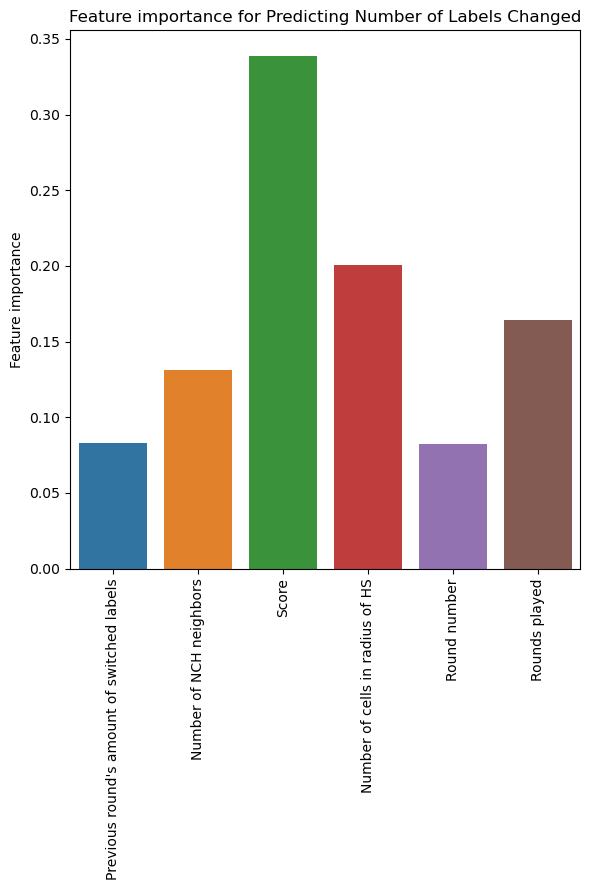

In [ ]:
fig, ax = plt.subplots(figsize=(6,9))
features=["Previous round's amount of switched labels", "Number of NCH neighbors", "Score", "Number of cells in radius of HS", "Round number", "Rounds played"]
sns.barplot(x=features, 
            y=model.feature_importances_)
plt.xticks(rotation=90)
ax.set_title("Feature importance for Predicting Number of Labels Changed")
ax.set_ylabel("Feature importance")
fig.tight_layout()

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X_test, Y_test, n_repeats=10, random_state=0, n_jobs=2
)

with_sub=(pd.Series(result.importances_mean, index=features))
# pfi_importances.append(pd.Series(result.importances_mean, index=[i for i in range(len(model.feature_importances_))]))
# pfi_std.append(pd.Series(result.importances_std, index=[i for i in range(len(model.feature_importances_))]))

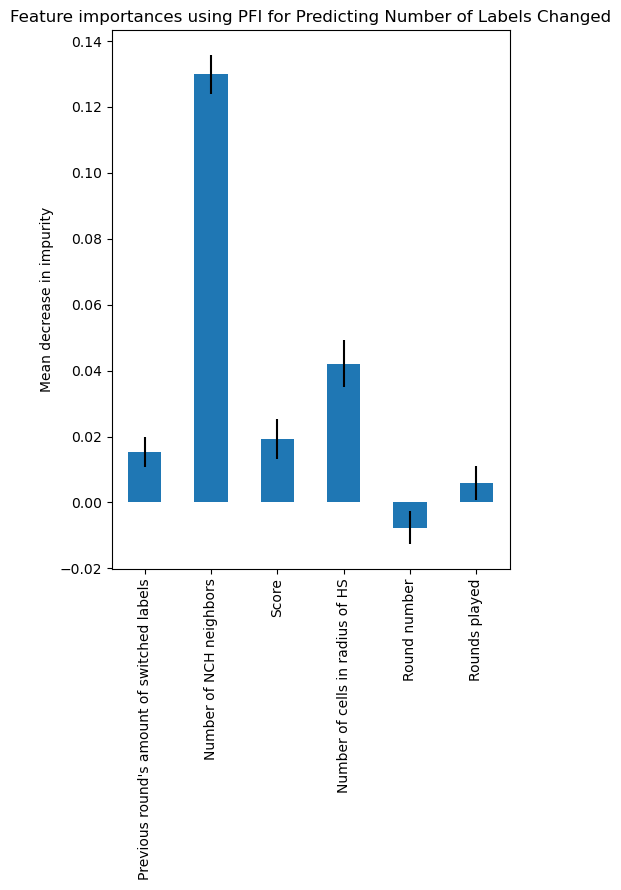

In [ ]:
fig, ax = plt.subplots(figsize=(5,9))
with_sub.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using PFI for Predicting Number of Labels Changed")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation=70)
fig.tight_layout()


In [19]:
centers_temp

array([[0.35020169, 7.18995233, 1.45984598],
       [1.61330876, 0.40623972, 6.98045152]])

In [15]:
centers_merged

array([[0.54663487, 0.84856916, 7.60479597],
       [0.17933786, 8.03601855, 0.78464359],
       [5.12115839, 0.5786052 , 3.30023641],
       [2.28826314, 0.391431  , 6.32030586]])

In [ ]:
nch_

In [48]:
set_country("Merged")

total=0
not_nch = [0]*2
switch_nch = [0]*2

stay_hs=[0]*2
switch_non_hs=[0]*2

hs = [0]*3
nch = [0]*3

nch_subsequent = 0
nch_subsequent_switch = 0

for i in range(len(curr_csv)-2):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Round'][i+2] == 1:
        continue

    for j in range(4):
        if(labels_full[i*4+j] not in nch_labels and labels_full[(i+1)*4+j] in nch_labels):
            total += 3
            for k in range(4):
                if k == j:
                    continue
                # if labels_full[i*4+k] not in nch_labels and labels_full[(i+1)*4+k] not in nch_labels:
                #     not_nch[1] += 1
                #     if labels_full[(i+2)*4+k] in nch_labels:
                #         switch_nch[1] += 1
                if labels_full[i*4+k] not in nch_labels:
                    not_nch[0]+=1
                    if labels_full[(i+1)*4+k] in nch_labels:
                        switch_nch[0] += 1
                    elif labels_full[(i+2)*4+k] in nch_labels:
                        switch_nch[1] += 1

                # if labels_full[i*4+k]==hs_label and labels_full[(i+1)*4+k]==hs_label:
                #     stay_hs[1] += 1
                #     if labels_full[(i+2)*4+k]!=hs_label:
                #         switch_non_hs[1] += 1
                if labels_full[i*4+k]==hs_label:
                    stay_hs[0]+=1
                    if labels_full[(i+1)*4+k]!=hs_label:
                        switch_non_hs[0] += 1
                    elif labels_full[(i+1)*4+k]==hs_label and labels_full[(i+2)*4+k]!=hs_label:
                        switch_non_hs[1] += 1

                for a in range(3):
                    if labels_full[(i+a)*4+k] == hs_label:
                        hs[a] += 1
                    if labels_full[(i+a)*4+k] in nch_labels:
                        nch[a] += 1

        # normal proportion
        if labels_full[i*4+j] not in nch_labels:
            nch_subsequent += 1
            if labels_full[(i+1)*4+j] in nch_labels:
                nch_subsequent_switch += 1

# at time t, farmer is non-nch, at time t+1, farmer is nch, at time t+2, what are their neighbors doing
print("Proportion of neighbors of switching neighbor who stay with non-nch strategy for 2 rounds:",
      not_nch[1]/total)
print("Proportion of neighbors who are non-nch (time t) and become nch (time t+1):",
      switch_nch[0]/not_nch[0])
print("Proportion of neighbors who are non-nch (time t), stay non-nch (time t+1), and become nch (time t+2):",
      switch_nch[1]/not_nch[0])
print("Proportion of neighbors who are hs (time t) and become non-hs (time t+1):",
      switch_non_hs[0]/stay_hs[0])
print("Proportion of neighbors who are hs (times t), stay hs for a turn (time t+1), and become non-hs (time t+2):",
      switch_non_hs[1]/stay_hs[0])
print("Proportion of farmers who have non-nch then switch to nch:",
      nch_subsequent_switch/nch_subsequent)

for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are HS: ", hs[i]/total, sep="")
for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are NCH: ", nch[i]/total, sep="")


ZeroDivisionError: division by zero

In [466]:
print(total, stay_hs, switch_non_hs)

3636 [92, 198] [92, 35]


In [471]:
# ([[0.39871758, 1.07082483, 7.53045759],
#        [0.13286004, 8.15024631, 0.71689365],
#        [2.59991019, 0.90166143, 5.49842838],
#        [6.48843188, 0.37017995, 2.14138817]])

curr_csv = cambodia_csv
nch_labels = [2, 3]
hs_label = 1
labels_full = labels_full_cambodia
centers = centers_cambodia

total = 0
not_nch = [0]*2
switch_nch = [0]*2

stay_hs = [0]*2
switch_non_hs = [0]*2

hs = [0]*3
nch = [0]*3

nch_subsequent = 0
nch_subsequent_switch = 0

for i in range(len(curr_csv)-2):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Round'][i+2] == 1:
        continue

    for j in range(4):
        if(labels_full[i*4+j] not in nch_labels and labels_full[(i+1)*4+j] in nch_labels):
            total += 3
            for k in range(4):
                if k == j:
                    continue
                if labels_full[i*4+k] not in nch_labels and labels_full[(i+1)*4+k] not in nch_labels:
                    not_nch[1] += 1
                    if labels_full[(i+2)*4+k] in nch_labels:
                        switch_nch[1] += 1
                if labels_full[i*4+k] not in nch_labels:
                    not_nch[0] += 1
                    if labels_full[(i+1)*4+k] in nch_labels:
                        switch_nch[0] += 1

                if labels_full[i*4+k] == hs_label and labels_full[(i+1)*4+k] == hs_label:
                    stay_hs[1] += 1
                    if labels_full[(i+2)*4+k] != hs_label:
                        switch_non_hs[1] += 1
                if labels_full[i*4+k] == hs_label:
                    stay_hs[0] += 1
                    if labels_full[(i+1)*4+k] != hs_label:
                        switch_non_hs[0] += 1

                for a in range(3):
                    if labels_full[(i+a)*4+k] == hs_label:
                        hs[a] += 1
                    if labels_full[(i+a)*4+k] in nch_labels:
                        nch[a] += 1

        # normal proportion
        if labels_full[i*4+j] not in nch_labels:
            nch_subsequent += 1
            if labels_full[(i+1)*4+j] in nch_labels:
                nch_subsequent_switch += 1

# at time t, farmer is non-hs, at time t+1, farmer is hs, at time t+2, what are their neighbors doing
print("Proportion of neighbors of switching neighbor who stay with non-nch strategy for 2 rounds:",
      not_nch[1]/total)
print("Proportion of neighbors who are non-nch (time t) and become nch (time t+1):",
      switch_nch[0]/not_nch[0])
print("Proportion of neighbors who are non-nch (times t and t+1) and become nch (time t+2):",
      switch_nch[1]/not_nch[1])
print("Proportion of neighbors who are hs (time t) and become non-hs (time t+1):",
      switch_non_hs[0]/stay_hs[0])
print("Proportion of neighbors who are hs (times t and t+1) and become non-hs (time t+2):",
      switch_non_hs[1]/stay_hs[1])
print("Proportion of farmers who have non-nch then switch to nch:",
      nch_subsequent_switch/nch_subsequent)

for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are HS: ", hs[i]/total, sep="")
for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are NCH: ", nch[i]/total, sep="")


Proportion of neighbors of switching neighbor who stay with non-nch strategy for 2 rounds: 0.6515723270440251
Proportion of neighbors who are non-nch (time t) and become nch (time t+1): 0.12794612794612795
Proportion of neighbors who are non-nch (times t and t+1) and become nch (time t+2): 0.06563706563706563
Proportion of neighbors who are hs (time t) and become non-hs (time t+1): 0.17026378896882494
Proportion of neighbors who are hs (times t and t+1) and become non-hs (time t+2): 0.07225433526011561
Proportion of farmers who have non-nch then switch to nch: 0.05379072363747082
Proportion of neighbors at time t+0 who are HS: 0.2622641509433962
Proportion of neighbors at time t+1 who are HS: 0.2610062893081761
Proportion of neighbors at time t+2 who are HS: 0.2672955974842767
Proportion of neighbors at time t+0 who are NCH: 0.2528301886792453
Proportion of neighbors at time t+1 who are NCH: 0.2893081761006289
Proportion of neighbors at time t+2 who are NCH: 0.2779874213836478


In [486]:
centers_vietnam


array([[0.66477553, 0.61149482, 7.72372965],
       [4.91097923, 0.54896142, 3.54005935],
       [2.25951557, 0.28342246, 6.45706197],
       [0.30495293, 7.55792059, 1.13712648]])

In [499]:
curr_csv = vietnam_csv
hs_label=3
nch_labels=[1, 2]
labels_full = labels_full_vietnam
centers = centers_vietnam

num_hs=[0]*5
num_hs_others_nch=[[0 for _ in range(5)] for _ in range(5)]

for i in range(len(curr_csv)):
    hs=0
    nch=0
    for j in range(4):
        if labels_full[i*4+j] == hs_label:
            hs+=1
        if labels_full[i*4+j] in nch_labels:
            nch+=1
    num_hs[hs]+=1
    num_hs_others_nch[hs][nch]+=1
            
for i in range(5):
    print(i, "HS squares")
    print("Proportion of all boards:", num_hs[i]/len(curr_csv))
    print("Proportion of such boards with each number of NCH cells (0-4 in order): ")
    for j in range(5):
        print(num_hs_others_nch[i][j]/num_hs[i])
    print()


0 HS squares
Proportion of all boards: 0.7595982142857143
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.16896855715545106
0.22156920364384367
0.227740229209521
0.21980605348222157
0.16191595650896268

1 HS squares
Proportion of all boards: 0.08415178571428572
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.38992042440318303
0.29442970822281167
0.21485411140583555
0.10079575596816977
0.0

2 HS squares
Proportion of all boards: 0.05758928571428571
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.5193798449612403
0.313953488372093
0.16666666666666666
0.0
0.0

3 HS squares
Proportion of all boards: 0.048660714285714286
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.7110091743119266
0.2889908256880734
0.0
0.0
0.0

4 HS squares
Proportion of all boards: 0.05
Proportion of such boards with each number of NCH cells (0-4 in order): 
1.0
0.0
0.0
0.0
0.0



In [498]:
curr_csv = cambodia_csv
hs_label=1
nch_labels=[2, 3]
labels_full = labels_full_cambodia
centers = centers_cambodia

num_hs=[0]*5
num_hs_others_nch=[[0 for _ in range(5)] for _ in range(5)]

for i in range(len(curr_csv)):
    hs=0
    nch=0
    for j in range(4):
        if labels_full[i*4+j] == hs_label:
            hs+=1
        if labels_full[i*4+j] in nch_labels:
            nch+=1
    num_hs[hs]+=1
    num_hs_others_nch[hs][nch]+=1
            
for i in range(5):
    print(i, "HS squares")
    print("Proportion of all boards:", num_hs[i]/len(curr_csv))
    print("Proportion of such boards with each number of NCH cells (0-4 in order): ")
    for j in range(5):
        print(num_hs_others_nch[i][j]/num_hs[i])
    print()


0 HS squares
Proportion of all boards: 0.3167277167277167
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.39244410177332306
0.24826522744795682
0.16268311488049345
0.1141094834232845
0.08249807247494217

1 HS squares
Proportion of all boards: 0.168986568986569
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.5187861271676301
0.2875722543352601
0.13872832369942195
0.05491329479768786
0.0

2 HS squares
Proportion of all boards: 0.18876678876678876
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.6015523932729625
0.3260025873221216
0.0724450194049159
0.0
0.0

3 HS squares
Proportion of all boards: 0.16312576312576313
Proportion of such boards with each number of NCH cells (0-4 in order): 
0.8038922155688623
0.19610778443113772
0.0
0.0
0.0

4 HS squares
Proportion of all boards: 0.1623931623931624
Proportion of such boards with each number of NCH cells (0-4 in order): 
1.0
0.0
0.0
0.0
0.0



# Predicting if a farmer will defect from non-HS

In [ ]:
curr_csv = vietnam_csv
hs_label=3
labels_full = labels_full_vietnam
centers = centers_vietnam

defections=0
stay_nch_total=0
stay_nch=0
switch_hs=0
non_hs=0

nch_subsequent=0
nch_subsequent_switch=0

for i in range(len(curr_csv)-2):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Round'][i+2] == 1:
        continue

    for j in range(4):
        if(labels_full[i*4+j] != hs_label and labels_full[(i+1)*4+j] == hs_label):
            defections += 1
            stay_nch_total += 3
            for k in range(4):
                if k == j:
                    continue
                if labels_full[i*4+k] != hs_label:
                    non_hs += 1
                if labels_full[i*4+k] != hs_label and labels_full[(i+1)*4+k] != hs_label:
                    stay_nch += 1
                    if labels_full[(i+2)*4+k] == hs_label:
                        switch_hs += 1

        # normal proportion
        if labels_full[i*4+j] != hs_label and labels_full[(i+1)*4+j] != hs_label:
            nch_subsequent += 1
            if labels_full[(i+2)*4+j] == hs_label:
                nch_subsequent_switch += 1

# at time t, farmer is non-hs, at time t+1, farmer is hs, at time t+2, what are their neighbors doing
print("Proportion of all farmer boards that are defections:",
      defections/((len(curr_csv)-2)*4))
print("Proportion of neighbors who are non-hs:", non_hs/stay_nch_total)
print("Proportion of neighbors of defecting neighbor who stay with non-hs strategy for 2 rounds:",
      stay_nch/stay_nch_total)
print("Proportion of neighbors of defecting neighbor who defect after neighbor defects:", switch_hs/stay_nch)
print("Proportion of farmers who stay with non-hs strategy for 2 rounds then defect to hs:",
      nch_subsequent_switch/nch_subsequent)


In [12]:
# predicting if they defect in the next round
curr_csv = vietnam_csv
hs_label=3
labels_full = labels_full_vietnam
centers = centers_vietnam

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X=[]
Y = []
switch_round=[1]*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
        else:
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            
            x_add=[]

                
            x_add.append(curr_csv['roundsPlayed'][i])
            temp=calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])

            num_non_hs=0
            for k in range(4):
                if k==j: continue
                if labels_full[i*4+k]!=hs_label:
                    num_non_hs+=1
            x_add.append(num_non_hs)
            x_add.append(curr_csv['Round'][i+1]-switch_round[j])
            temp = calculate_nch(curr_round)
            for k in temp:
                x_add.append(k)

            X.append(x_add)
            Y.append(labels_full[(i+1)*4+j]==hs_label)


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2 = accuracy_score(Y_test, y_pred)
print('accuracy: ', r2)

accuracy:  0.963130173062453


In [15]:
Y.shape

(13290, 1)

In [23]:
total=0
defections=0
for i in Y:
    defections+=int(i)
    total+=1

print(defections/total)
print(1-defections/total)

0.03175319789315274
0.9682468021068472


In [29]:
total=0
defections=0
for i in range(len(Y_test)):
    if Y_test[i]:
        if y_pred[i]:
            defections+=1
        total+=1
print(defections/total)


0.11764705882352941


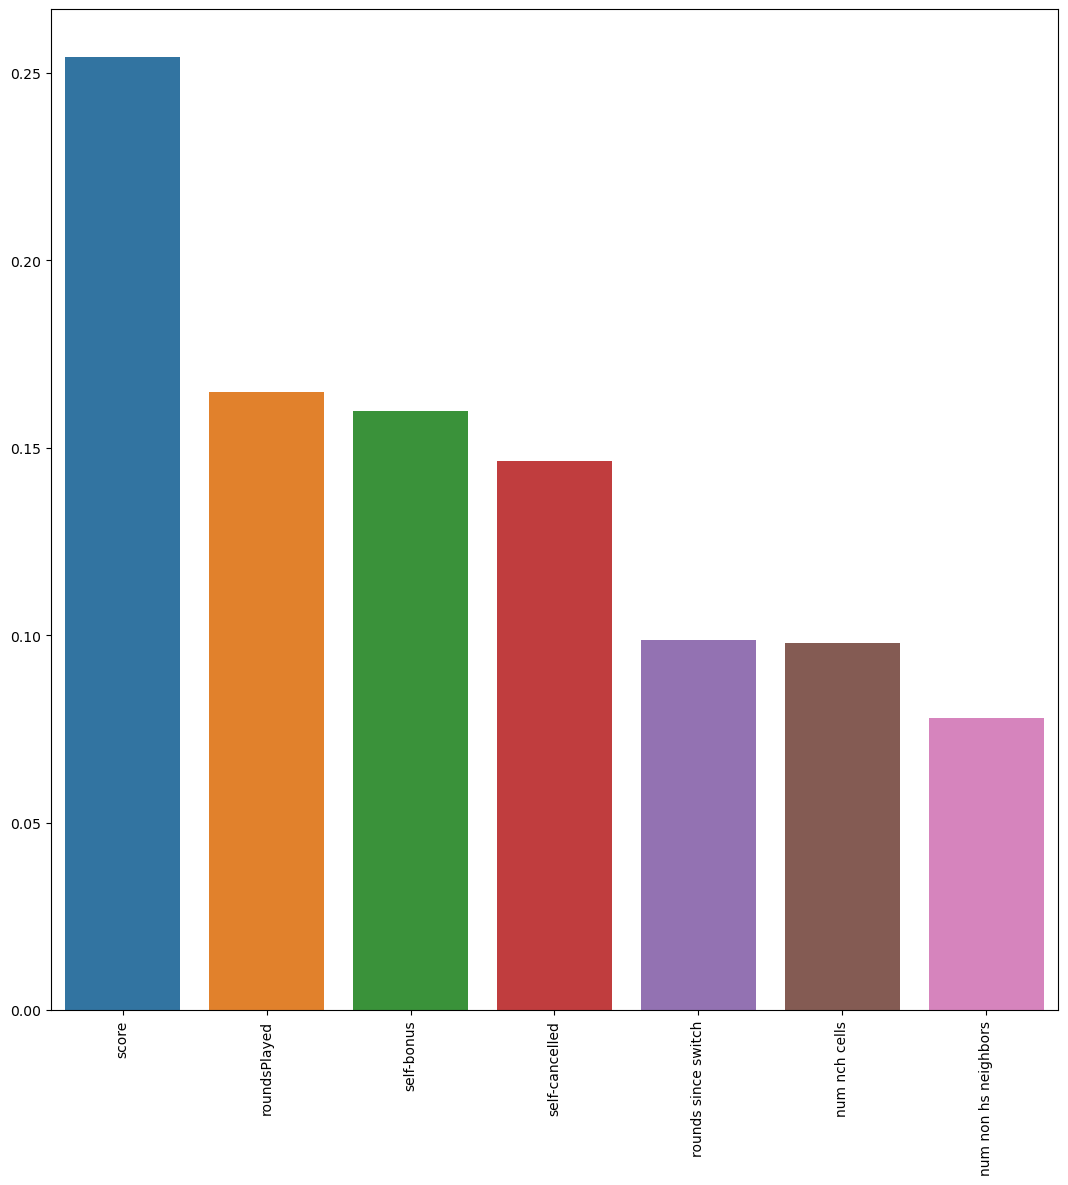

In [24]:
# heavy spray from self or neighbors heavily decreases "trust"

indices_arr=["roundsPlayed", "score", "num non hs neighbors", "rounds since switch", "self-cancelled", "self-bonus", "num nch cells"]

comb = []
for i in range(len(model.feature_importances_)):
    comb.append([model.feature_importances_[i], indices_arr[i]])

comb.sort(reverse=True)

plt.figure(figsize=(13, 13))
# 30 most important
categories = list(np.array(comb)[:30, 1])
values = list(np.array(comb)[:30, 0])

values = [float(x) for x in values]

sns.barplot(x=categories, y=values)

plt.xticks(rotation=90)
plt.show()


In [39]:

curr_csv = vietnam_csv
hs_label=3
labels_full = labels_full_vietnam
centers = centers_vietnam

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        else:
            if labels_full[(i+1)*4+j]==hs_label:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1


for i in range(1, len(defections_arr)):
    score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

Text(0.5, 1.0, 'Distribution of defections to HS after switching to a non-HS strategy')

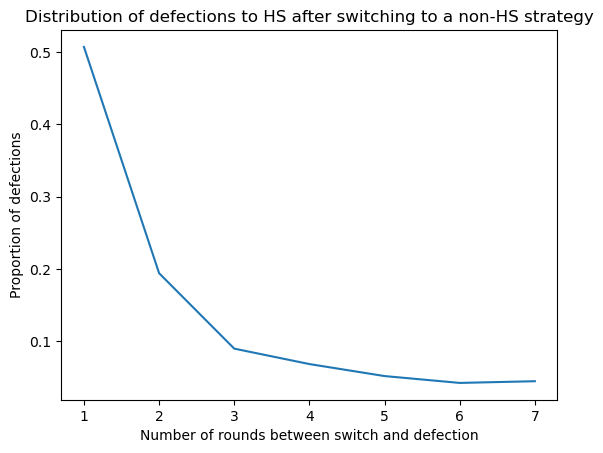

In [37]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to HS after switching to a non-HS strategy")

# Distribution of defections from non-HS/from NCH

percent of time someone defects after switching to non-HS strategy: 0.5757225433526012


Text(0.5, 1.0, 'Distribution of defections to HS after switching to a non-HS strategy')

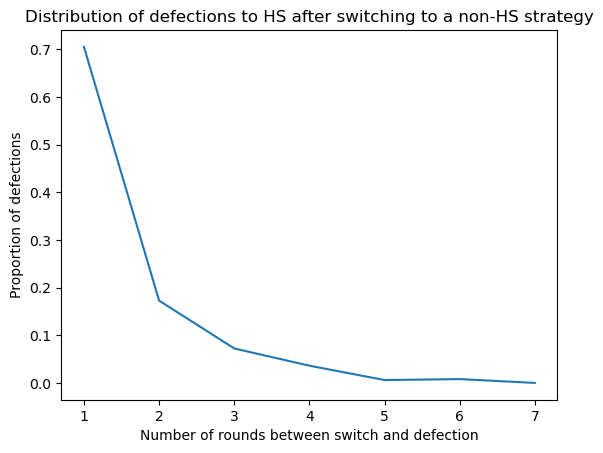

In [12]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
# switch_score=[1]*4
defections=0
total_switches=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue 
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
                total_switches+=1
        else:
            if labels_full[(i+1)*4+j]==hs_label and switch_round[j]!=1:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

print("percent of time someone defects after switching to non-HS strategy:", defections/total_switches)
for i in range(1, len(defections_arr)):
    # score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to HS after switching to a non-HS strategy")

percent of time someone defects after switching to NCH strategy: 0.5888671875


Text(0.5, 1.0, 'Distribution of defections to non-NCH after switching to a NCH strategy')

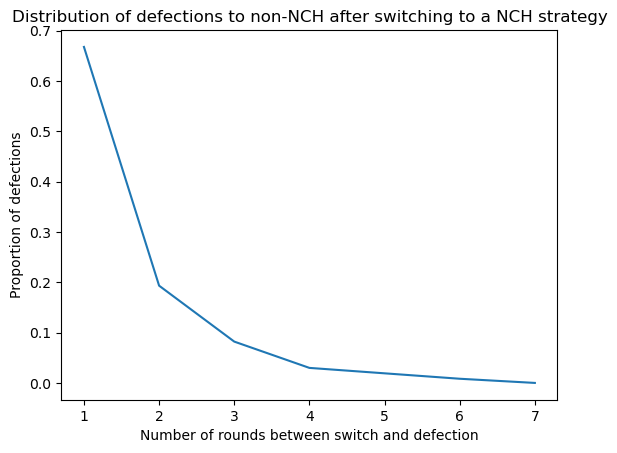

In [19]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str] 
nch_label=nch_labels[curr_str]
base_label=base_labels[curr_str]

labels_full = labels_full_merged
centers = centers_merged

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
# switch_score=[1]*4
defections=0
total_switches=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue 
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_full[(i)*4+j] not in nch_label:
            if labels_full[(i+1)*4+j] in nch_label:
                switch_round[j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
                total_switches+=1
        else:
            if labels_full[(i+1)*4+j] not in nch_label and switch_round[j]!=1:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

print("percent of time someone defects after switching to NCH strategy:", defections/total_switches)
for i in range(1, len(defections_arr)):
    # score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to non-NCH after switching to a NCH strategy")

In [6]:
merged_csv["Subsidy"]

0        0
1        0
2        0
3       10
4       10
        ..
8570     0
8571     0
8572     0
8573     0
8574     0
Name: Subsidy, Length: 8575, dtype: int64

Text(0.5, 1.0, 'Distribution of defections after switching to a strategy')

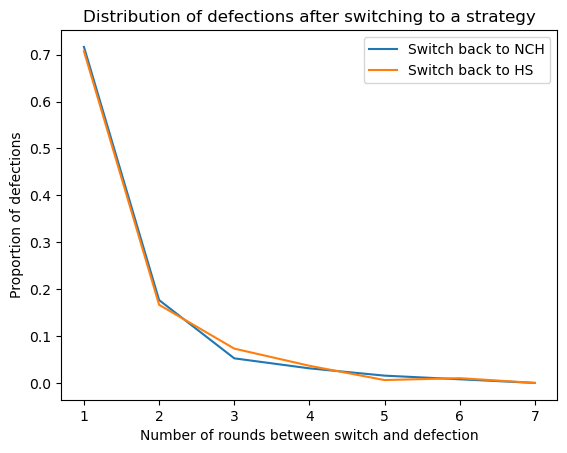

In [77]:
set_country("Merged")

switch_round=[0]*4
total_switches=0
switches=0
plt_arr=[]

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
# switch_score=[1]*4
defections=0
total_switches=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue 
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]==nch_2:
            if labels_2[(i+1)*4+j]!=nch_2:
                switch_round[j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
                total_switches+=1
        else:
            if labels_2[(i+1)*4+j]==nch_2 and switch_round[j]!=1:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                # score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

# print("percent of time someone defects after switching to NCH strategy:", defections/total_switches)
for i in range(1, len(defections_arr)):
    # score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections
plt_arr.append(defections_arr[1:])

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
# switch_score=[1]*4
defections=0
total_switches=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue 
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_2[(i)*4+j]!=nch_2:
            if labels_2[(i+1)*4+j]==nch_2:
                switch_round[j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
                total_switches+=1
        else:
            if labels_2[(i+1)*4+j]!=nch_2 and switch_round[j]!=1:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                # score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

# print("percent of time someone defects after switching to NCH strategy:", defections/total_switches)
for i in range(1, len(defections_arr)):
    # score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections
plt_arr.append(defections_arr[1:])

line_labels=['Switch back to NCH', 'Switch back to HS']
for i in range(2):
    sns.lineplot(x=[_ for _ in range(1, 8)], y=plt_arr[i], label=line_labels[i])

plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections after switching to a strategy")

In [55]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str] 
nch_label=nch_labels[curr_str]
base_label=base_labels[curr_str]

labels_full = labels_full_merged
centers = centers_merged

defections_arr=[0]*8
stay_arr=[0]*8
score_arr_stay=[0]*8
score_arr_switch=[0]*8
switch_round=[1]*4
# switch_score=[1]*4
defections=0
total_switches=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        switch_score=[0]*8
        continue 
    
    curr_np=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    
    for j in range(4):
        if labels_full[(i)*4+j] not in nch_label:
            if labels_full[(i+1)*4+j] in nch_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
                total_switches+=1
        else:
            if switch_round[j]!=1:
                if labels_full[(i+1)*4+j] not in nch_label:
                    defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                    score_arr_switch[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                    defections+=1
                else:
                    stay_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                    score_arr_stay[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i+1, curr_csv)[j]

print("percent of time someone defects after switching to NCH strategy:", defections/total_switches)
for i in range(1, len(defections_arr)-1):
    score_arr_stay[i]/=stay_arr[i]
    score_arr_switch[i]/=defections_arr[i]
    defections_arr[i]/=defections

# sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
# plt.xlabel("Number of rounds between switch and defection")
# plt.ylabel("Proportion of defections")
# plt.title("Distribution of defections to non-NCH after switching to a NCH strategy")

percent of time someone defects after switching to NCH strategy: 0.5888671875


In [49]:
for i in range(1, len(defections_arr)):
    print(defections_arr[i])

0.6674958540630183
0.1932006633499171
0.08208955223880597
0.029850746268656716
0.019071310116086235
0.008291873963515755
0


Text(0.5, 1.0, 'Average Score Difference between final HS round and non-HS round for farmers who stay with non-HS vs. switch back to HS')

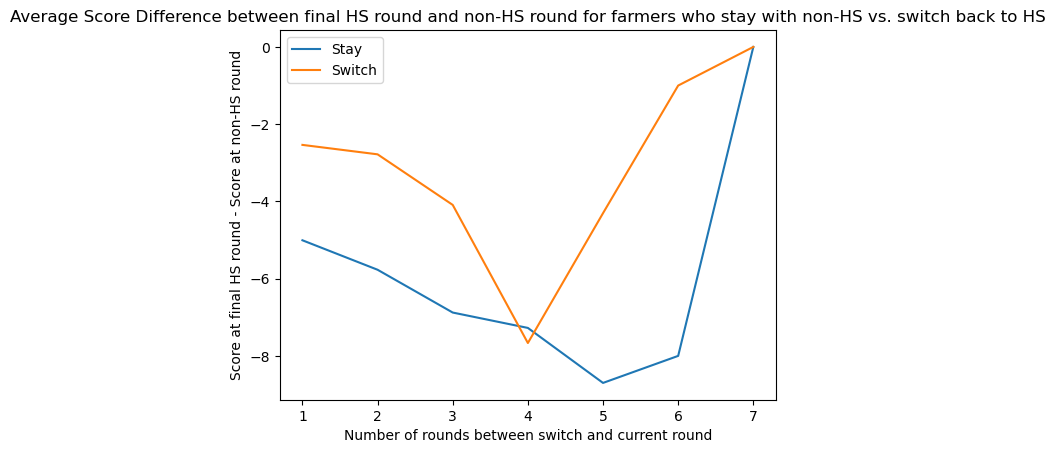

In [58]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr_stay[1:], label="Stay")
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr_switch[1:], label="Switch")
plt.xlabel("Number of rounds between switch and current round")
plt.ylabel("Score at final HS round - Score at non-HS round")
plt.title("Average Score Difference between final HS round and non-HS round for farmers who stay with non-HS vs. switch back to HS")

# changing from non-HS to NCH or vice versa

In [ ]:
# predicting if they defect in the next round
curr_csv = vietnam_csv
hs_label=3
labels_full = labels_full_vietnam
centers = centers_vietnam

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X=[]
Y = []
switch_round=[1]*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
        else:
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            
            x_add=[]

                
            x_add.append(curr_csv['roundsPlayed'][i])
            temp=calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])

            num_non_hs=0
            for k in range(4):
                if k==j: continue
                if labels_full[i*4+k]!=hs_label:
                    num_non_hs+=1
            x_add.append(num_non_hs)
            x_add.append(curr_csv['Round'][i+1]-switch_round[j])
            temp = calculate_nch(curr_round)
            for k in temp:
                x_add.append(k)


            X.append(x_add)
            Y.append(labels_full[(i+1)*4+j]==hs_label)


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [ ]:

curr_csv = vietnam_csv
hs_label=3
labels_full = labels_full_vietnam
centers = centers_vietnam

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        else:
            if labels_full[(i+1)*4+j]==hs_label:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1


for i in range(1, len(defections_arr)):
    score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

Text(0.5, 1.0, 'Distribution of defections to HS after switching to a non-HS strategy')

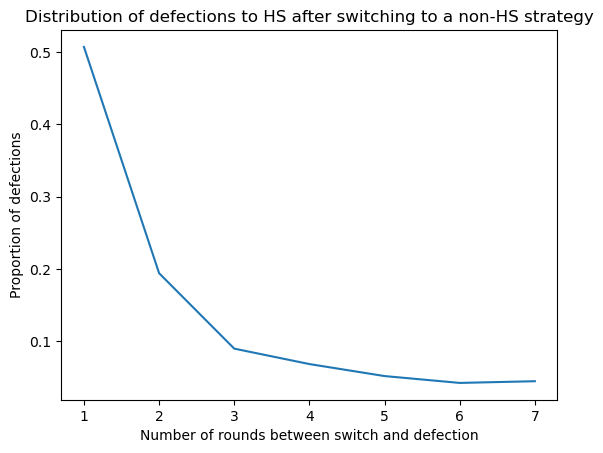

In [ ]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to HS after switching to a non-HS strategy")

Text(0.5, 1.0, 'Distribution in loss in score of defectors from switching to non-HS')

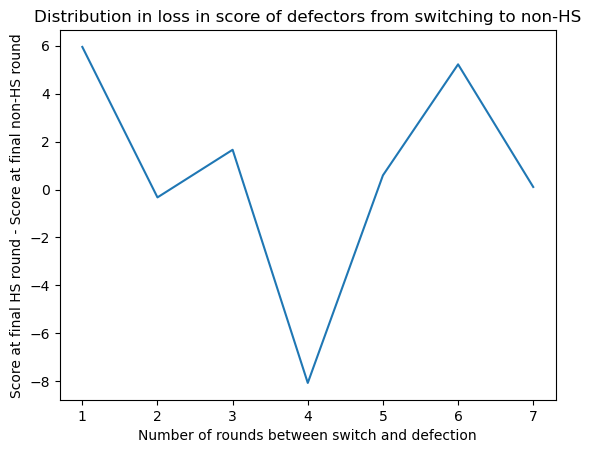

In [ ]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Score at final HS round - Score at final non-HS round")
plt.title("Distribution in loss in score of defectors from switching to non-HS")

In [7]:
# predicting if they defect in the next round
curr_csv = cambodia_csv
hs_label=1
labels_full = labels_full_cambodia
centers = centers_cambodia

curr_round = [0 for i in range(36)]
characteristics_arr = ["cropSale", "weedingCost", "weedingLabor", "pestCost", "numPlots", "flood", "floodLandslide", "drought", "storms", "landWorked", "landOwned", "landHHeadWorked", "landHHeadDecides", "femaleLabor", "maleLabor", "selfGender", "selfAge",
                       "selfEd", "selfExp", "selfLit", "selfLeader", "instructedPest", "pestHazard", "district", "commune", "village", "alpha", "sigma", "lambda", "useImprovedSeed", "useChemFert", "usePesticide", "useOrgFert", "homeGardenSafe", "fracSold_harvest", "fracSold_area"]

X=[]
Y = []
switch_round=[1]*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
        else:
            corner = np.rot90(
                np.array(curr_np[j//2*3:j//2*3+3, j % 2*3:j % 2*3+3]), j)
            
            x_add=[]

                
            x_add.append(curr_csv['roundsPlayed'][i])
            temp=calculate_score_csv(i, curr_csv)
            x_add.append(temp[j])

            num_non_hs=0
            for k in range(4):
                if k==j: continue
                if labels_full[i*4+k]!=hs_label:
                    num_non_hs+=1
            x_add.append(num_non_hs)
            x_add.append(curr_csv['Round'][i+1]-switch_round[j])
            temp = calculate_nch(curr_round)
            for k in temp:
                x_add.append(k)

            # player_str="p"+str(j+1)+"_"
            # chars=[]
            # for char in characteristics_arr:
            #     col_ind=player_str+char
            #     val = curr_csv[col_ind][i]
            #     if pd.isna(val):
            #         chars.append(-1)
            #     else:
            #         chars.append(val)
            # x_add.extend(chars)

    # [cancelled, bonus, num cells]

            X.append(x_add)
            Y.append(labels_full[(i+1)*4+j]==hs_label)


X = np.array(X)
Y = np.array(Y)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [9]:
curr_csv = cambodia_csv
hs_label=1
labels_full = labels_full_cambodia
centers = centers_cambodia

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        else:
            if labels_full[(i+1)*4+j]==hs_label:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1


for i in range(1, len(defections_arr)):
    score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

Text(0.5, 1.0, 'Distribution of defections to HS after switching to a non-HS strategy')

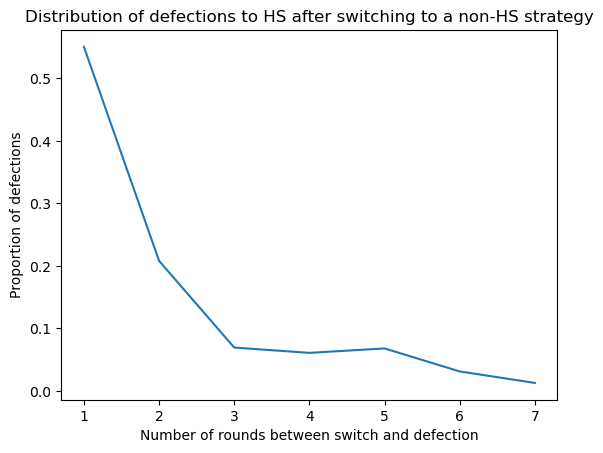

In [10]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to HS after switching to a non-HS strategy")

Text(0.5, 1.0, 'Distribution in loss in score of defectors from switching to non-HS')

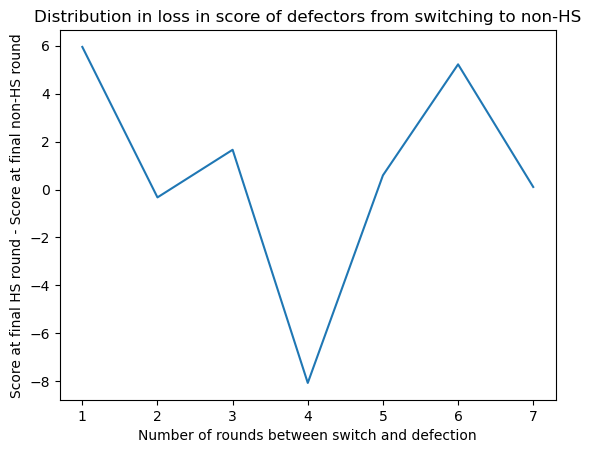

In [ ]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Score at final HS round - Score at final non-HS round")
plt.title("Distribution in loss in score of defectors from switching to non-HS")

In [63]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        switch_score=[0]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)

    if curr_csv['Round'][i] == 1:
        for j in range(4):
            if labels_full[(i)*4+j]!=hs_label:
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label and labels_full[(i+1)*4+j]!=hs_label:
            switch_round[j]=curr_csv['Round'][i+1]
            switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        elif labels_full[(i)*4+j]!=hs_label and labels_full[(i+1)*4+j]==hs_label:
            defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
            score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
            defections+=1


for i in range(1, len(defections_arr)):
    score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

Text(0.5, 1.0, 'Distribution of defections to HS after switching to a non-HS strategy')

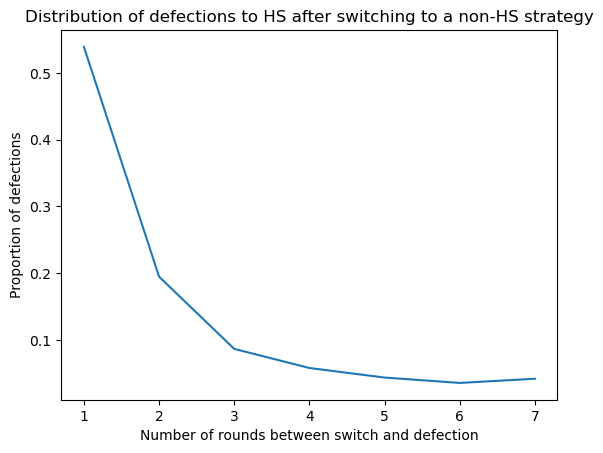

In [64]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections to HS after switching to a non-HS strategy")

Text(0.5, 1.0, 'Distribution in loss in score of defectors from switching to non-HS')

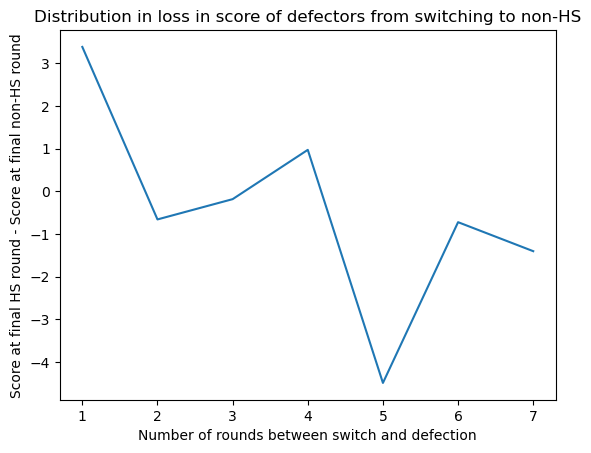

In [65]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Score at final HS round - Score at final non-HS round")
plt.title("Distribution in loss in score of defectors from switching to non-HS")

In [25]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nch_label=nch_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

# defections_arr=[0]*8
# score_arr=[0]*8
# switch_round=[1]*4
# switch_score=[1]*4
# defections=0

hs_start=0
non_hs_start=0
total=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        # switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i+1)*4+j] in nch_label:
            if labels_full[(i)*4+j]==hs_label:
                total+=1
                hs_start+=1
            if labels_full[(i)*4+j]!=hs_label:
                total+=1
                non_hs_start+=1
        # else:
        #     if labels_full[(i+1)*4+j]==hs_label:
        #         defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
        #         score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
        #         defections+=1

print("Percentage of switches to NCH that come from HS:", hs_start/total)
print("Percentage of switches to NCH that come from non-HS:", non_hs_start/total)
# for i in range(1, len(defections_arr)):
#     score_arr[i]/=defections_arr[i]
#     defections_arr[i]/=defections

Percentage of switches to NCH that come from HS: 0.021802836713163756
Percentage of switches to NCH that come from non-HS: 0.9781971632868363


In [ ]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nch_label=nch_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

# defections_arr=[0]*8
# score_arr=[0]*8
# switch_round=[1]*4
# switch_score=[1]*4
# defections=0

hs_start=0
non_hs_start=0
total=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        # switch_round=[1]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i+1)*4+j] in nch_label:
            if labels_full[(i)*4+j]==hs_label:
                total+=1
                hs_start+=1
            if labels_full[(i)*4+j]!=hs_label:
                total+=1
                non_hs_start+=1
        # else:
        #     if labels_full[(i+1)*4+j]==hs_label:
        #         defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
        #         score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
        #         defections+=1

print("Percentage of switches to NCH that come from HS:", hs_start/total)
print("Percentage of switches to NCH that come from non-HS:", non_hs_start/total)
# for i in range(1, len(defections_arr)):
#     score_arr[i]/=defections_arr[i]
#     defections_arr[i]/=defections

In [66]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nch_label=nch_labels[curr_str]
for i in range(4):
    if i not in nch_label and i !=hs_label:
        switch_label=i
        break
    
labels_full = labels_full_merged
centers = centers_merged

defections_arr=[0]*8
score_arr=[0]*8
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        switch_score=[0]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)

    if curr_csv['Round'][i] == 1:
        for j in range(4):
            if labels_full[(i)*4+j] in nch_label:
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
    
    for j in range(4):
        if labels_full[(i)*4+j] not in nch_label:
            if labels_full[(i+1)*4+j] in nch_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        elif labels_full[(i)*4+j] in nch_label and labels_full[(i+1)*4+j] not in nch_label:
                defections_arr[curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

for i in range(1, len(defections_arr)):
    score_arr[i]/=defections_arr[i]
    defections_arr[i]/=defections

Text(0.5, 1.0, 'Distribution of defections from NCH after switching to an NCH strategy')

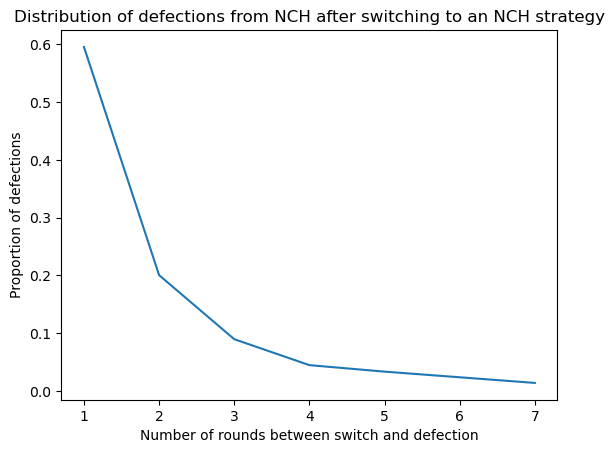

In [67]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Proportion of defections")
plt.title("Distribution of defections from NCH after switching to an NCH strategy")

In [38]:
defections_arr

[0,
 0.5955056179775281,
 0.20029311187103077,
 0.0893991206643869,
 0.044455300439667805,
 0.03321934538348803,
 0.02344894968246214,
 0.013678553981436248]

Text(0.5, 1.0, 'Distribution in loss in score of defectors from switching to NCH')

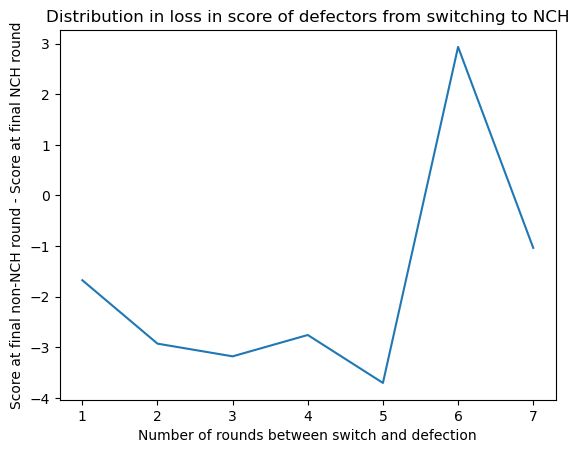

In [68]:
sns.lineplot(x=[_ for _ in range(1, 8)], y=score_arr[1:])
plt.xlabel("Number of rounds between switch and defection")
plt.ylabel("Score at final non-NCH round - Score at final NCH round")
plt.title("Distribution in loss in score of defectors from switching to NCH")

# Is it the case that the same farmers who defect from non-HS to HS quickly are the same farmers who defect from NCH to non-NCH quickly?

In [40]:
x=[[0]*8 for _ in range(2)]

[0, 0, 0, 0, 0, 0, 0, 0]

In [41]:

curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nch_label=nch_labels[curr_str]
for i in range(4):
    if i not in nch_label and i !=hs_label:
        switch_label=i
        break
    
labels_full = labels_full_merged
centers = centers_merged

defections_arr=[[0]*8 for _ in range(2)]
score_arr=[[0]*8 for _ in range(2)]
switch_round=[1]*4
switch_score=[1]*4
defections=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        switch_score=[0]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j] not in nch_label:
            if labels_full[(i+1)*4+j] in nch_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        elif labels_full[(i)*4+j] in nch_label and labels_full[(i+1)*4+j] not in nch_label:
                defections_arr[0][curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[0][curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1

for i in range(1, len(defections_arr)):
    score_arr[0][i]/=defections_arr[0][i]
    defections_arr[0][i]/=defections

defections=0
for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i+1] == 1:
        switch_round=[1]*4
        switch_score=[0]*4
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[j]=curr_csv['Round'][i+1]
                switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        else:
            if labels_full[(i+1)*4+j]==hs_label:
                defections_arr[1][curr_csv['Round'][i+1]-switch_round[j]]+=1
                score_arr[1][curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                defections+=1


for i in range(1, len(defections_arr)):
    score_arr[1][i]/=defections_arr[1][i]
    defections_arr[1][i]/=defections

defections_arr=np.array(defections_arr)

In [78]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

defections_arr=[[[0]*8 for _ in range(4)] for j in range(2)]
# score_arr=[0]*8
switch_round=[[1]*4 for _ in range(2)]
# switch_score=[1]*4
# defections=0
x=[]
y=[]

for i in range(len(curr_csv)-1):
    if curr_csv["roundsPlayed"][i+1]==1:
        for j in range(4):
            ans=[0, 0]
            totals=[0, 0]
            for a in range(2):
                for k in range(8):
                    totals[a]+=defections_arr[a][j][k]
                    ans[a]+=defections_arr[a][j][k]*k


            if totals[0]>0 and totals[1]>0:
                x.append(float(ans[0]/totals[0]))
                y.append(float(ans[1]/totals[1]))

        defections_arr=[[[0]*8 for _ in range(4)] for j in range(2)]

    if curr_csv['Round'][i+1] == 1:
        switch_round=[[1]*4 for _ in range(2)]
        continue
    
    for j in range(40, 76):
        curr_round[j-40] = curr_csv.iloc[i, j]
    curr_np = np.array(curr_round).reshape(6, 6)
    
    for j in range(4):
        if labels_full[(i)*4+j]==hs_label:
            if labels_full[(i+1)*4+j]!=hs_label:
                switch_round[0][j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        else:
            if labels_full[(i+1)*4+j]==hs_label:
                defections_arr[0][j][curr_csv['Round'][i+1]-switch_round[0][j]]+=1
                # score_arr[curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                # defections+=1
                
        if labels_full[(i)*4+j] not in nch_label:
            if labels_full[(i+1)*4+j] in nch_label:
                switch_round[1][j]=curr_csv['Round'][i+1]
                # switch_score[j]=calculate_score_csv(i, curr_csv)[j]
        elif labels_full[(i)*4+j] in nch_label and labels_full[(i+1)*4+j] not in nch_label:
                defections_arr[1][j][curr_csv['Round'][i+1]-switch_round[1][j]]+=1
                # score_arr[0][curr_csv['Round'][i+1]-switch_round[j]]+=switch_score[j]-calculate_score_csv(i, curr_csv)[j]
                # defections+=1

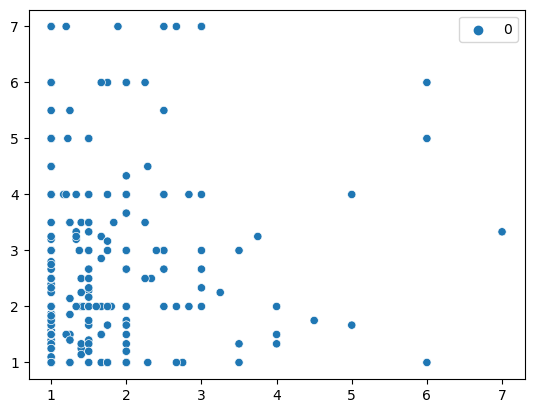

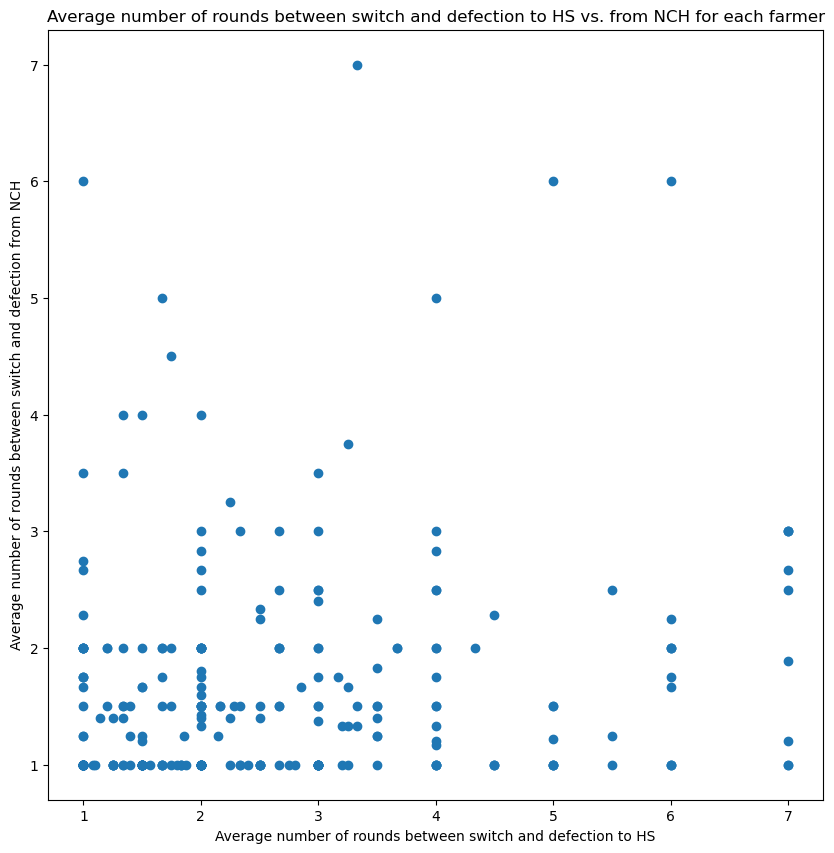

In [87]:
sns.scatterplot(pd.DataFrame(x, y))
plt.figure(figsize=(10, 10))
plt.xlabel("Average number of rounds between switch and defection to HS")
plt.ylabel("Average number of rounds between switch and defection from NCH")
plt.title("Average number of rounds between switch and defection to HS vs. from NCH for each farmer")
plt.scatter(x, y, )
plt.show()


In [82]:
pearsonr(x, y)

PearsonRResult(statistic=0.18362704415846165, pvalue=0.0023626241883483944)

In [71]:
hhids=[]
for i in range(1,5):
    hhids.append(merged_csv['Player'+str(i)+'HHID'].tolist())

len(np.unique(np.array(hhids)))

763

In [99]:
nums=[0]*4
for i in labels_full_merged:
    nums[int(i)]+=1

for i in range(4):
    print(nums[i]/len(labels_full_merged))

0.44011661807580177
0.27034985422740526
0.04932944606413994
0.24020408163265305


In [104]:
# ([[0.39871758, 1.07082483, 7.53045759],
#        [0.13286004, 8.15024631, 0.71689365],
#        [2.59991019, 0.90166143, 5.49842838],
#        [6.48843188, 0.37017995, 2.14138817]])

curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nhc_label=nch_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

total = 0
not_nch = [0]*2
switch_nch = [0]*2

stay_hs = [0]*2
switch_non_hs = [0]*2

hs = [0]*3
nch = [0]*3

nch_subsequent = 0
nch_subsequent_switch = 0

for i in range(len(curr_csv)-2):
    if curr_csv['Round'][i+1] == 1 or curr_csv['Round'][i+2] == 1:
        continue

    for j in range(4):
        if(labels_full[i*4+j] not in nch_label and labels_full[(i+1)*4+j] in nch_label):
            total += 3
            for k in range(4):
                if k == j:
                    continue
                if labels_full[i*4+k] not in nch_label and labels_full[(i+1)*4+k] not in nch_label:
                    not_nch[1] += 1
                    if labels_full[(i+2)*4+k] in nch_label:
                        switch_nch[1] += 1
                if labels_full[i*4+k] not in nch_label:
                    not_nch[0] += 1
                    if labels_full[(i+1)*4+k] in nch_label:
                        switch_nch[0] += 1

                if labels_full[i*4+k] == hs_label and labels_full[(i+1)*4+k] == hs_label:
                    stay_hs[1] += 1
                    if labels_full[(i+2)*4+k] != hs_label:
                        switch_non_hs[1] += 1
                if labels_full[i*4+k] == hs_label:
                    stay_hs[0] += 1
                    if labels_full[(i+1)*4+k] != hs_label:
                        switch_non_hs[0] += 1

                for a in range(3):
                    if labels_full[(i+a)*4+k] == hs_label:
                        hs[a] += 1
                    if labels_full[(i+a)*4+k] in nch_label:
                        nch[a] += 1

        # normal proportion
        if labels_full[i*4+j] not in nch_label:
            nch_subsequent += 1
            if labels_full[(i+1)*4+j] in nch_label:
                nch_subsequent_switch += 1

# at time t, farmer is non-hs, at time t+1, farmer is hs, at time t+2, what are their neighbors doing
print("Proportion of neighbors of switching neighbor who stay with non-nch strategy for 2 rounds:",
      not_nch[1]/total)
print("Proportion of neighbors who are non-nch (time t) and become nch (time t+1):",
      switch_nch[0]/not_nch[0])
print("Proportion of neighbors who are non-nch (times t and t+1) and become nch (time t+2):",
      switch_nch[1]/not_nch[1])
print("Proportion of neighbors who are hs (time t) and become non-hs (time t+1):",
      switch_non_hs[0]/stay_hs[0])
print("Proportion of neighbors who are hs (times t and t+1) and become non-hs (time t+2):",
      switch_non_hs[1]/stay_hs[1])
print("Proportion of farmers who have non-nch then switch to nch:",
      nch_subsequent_switch/nch_subsequent)

for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are HS: ", hs[i]/total, sep="")
for i in range(3):
    print("Proportion of neighbors at time t+",
          i, " who are NCH: ", nch[i]/total, sep="")


Proportion of neighbors of switching neighbor who stay with non-nch strategy for 2 rounds: 0.48645533141210373
Proportion of neighbors who are non-nch (time t) and become nch (time t+1): 0.21464019851116625
Proportion of neighbors who are non-nch (times t and t+1) and become nch (time t+2): 0.10742496050552923
Proportion of neighbors who are hs (time t) and become non-hs (time t+1): 0.22693997071742314
Proportion of neighbors who are hs (times t and t+1) and become non-hs (time t+2): 0.10606060606060606
Proportion of farmers who have non-nch then switch to nch: 0.09960388081979447
Proportion of neighbors at time t+0 who are HS: 0.13121998078770414
Proportion of neighbors at time t+1 who are HS: 0.12987512007684918
Proportion of neighbors at time t+2 who are HS: 0.12987512007684918
Proportion of neighbors at time t+0 who are NCH: 0.38059558117195
Proportion of neighbors at time t+1 who are NCH: 0.4315081652257445
Proportion of neighbors at time t+2 who are NCH: 0.4174831892411143


In [ ]:
sessions = np.array(curr_csv["Session"])

prev_session = 0
prev_labels = np.array([0]*4)
label_ind = 0
labels_sorted = labels.reshape(-1, 4)

changed = 0
total = 0
different_changes=[0]*5
num_changes=[0]*5

for session in sessions:
    if session != prev_session:
        prev_session = session
        prev_labels = labels_sorted[label_ind]
        label_ind += 1
    else:
        curr_labels = labels_sorted[label_ind]
        changed_to=[0]*4
        num_changed=0

        for i in range(4):
            total += 1
            if curr_labels[i] != prev_labels[i]:
                changed += 1
                changed_to[curr_labels[i]]+=1
                num_changed +=1

        num_changes[num_changed]+=1

        label_ind += 1
        prev_labels = curr_labels

        num_diff_changes=0
        for i in changed_to:
            if i>0:
                num_diff_changes+=1
        different_changes[num_diff_changes]+=1

print("Proportion of farmers who change labels in a round:", changed/total)
print("Number of different labels changed to")
for i in range(5):
    print(i, ":", different_changes[i]/(total/4))
print("Number of farmers change")
for i in range(5):
    print(i, ":", num_changes[i]/(total/4))


In [ ]:
# average number of cells changed round to round
curr_csv = merged_csv
cells_changed = 0
total = 0

prev_plot = np.array([0]*36)

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1:
        prev_plot=np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
        continue

    curr_plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    

        if(labels_full[i*4+j] not in nch_label and labels_full[(i+1)*4+j] in nch_label):
            total += 3
            for k in range(4):
                if k == j:
                    continue
                if labels_full[i*4+k] not in nch_label and labels_full[(i+1)*4+k] not in nch_label:
                    not_nch[1] += 1
                    if labels_full[(i+2)*4+k] in nch_label:
                        switch_nch[1] += 1
                if labels_full[i*4+k] not in nch_label:
                    not_nch[0] += 1
                    if labels_full[(i+1)*4+k] in nch_label:
                        switch_nch[0] += 1

                if labels_full[i*4+k] == hs_label and labels_full[(i+1)*4+k] == hs_label:
                    stay_hs[1] += 1
                    if labels_full[(i+2)*4+k] != hs_label:
                        switch_non_hs[1] += 1
                if labels_full[i*4+k] == hs_label:
                    stay_hs[0] += 1
                    if labels_full[(i+1)*4+k] != hs_label:
                        switch_non_hs[0] += 1

                for a in range(3):
                    if labels_full[(i+a)*4+k] == hs_label:
                        hs[a] += 1
                    if labels_full[(i+a)*4+k] in nch_label:
                        nch[a] += 1

        # normal proportion
        if labels_full[i*4+j] not in nch_label:
            nch_subsequent += 1
            if labels_full[(i+1)*4+j] in nch_label:
                nch_subsequent_switch += 1

# Predict whether farmer will change from non-nch to nch strategy

In [62]:
# Predict whether farmer will change from non-nch to nch strategy
X=[]
Y=[]

curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
nch_label=nch_labels[curr_str]
for i in range(4):
    if i not in nch_label and i !=hs_label:
        switch_label=i
        break
    
labels_full = labels_full_merged
centers = centers_merged

# defections_arr=[0]*8
# score_arr=[0]*8
# switch_round=[1]*4
# switch_score=[1]*4
# defections=0

prev_labels=[0]*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'][i+1] == 1:
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)

    #total nch and hs in whole plot
    num_nch=0
    num_hs=0
    for j in range(4):
        num_nch+=labels_full[(i)*4+j] in nch_label
        num_hs+=labels_full[(i)*4+j] in hs_label

    #all cells in plot covered by hs
    scores=np.array([[0]*6]*6)
    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=1

    hs_canceled=[0]*4
    for row in range(6):
        for col in range(6):
            hs_canceled[cells_map[row][col]-1]+=scores[row][col]

    for j in range(4):
        if labels_full[(i)*4+j] in nch_label:
            continue

        x_add=[]
        x_add.append(num_nch-int(labels_full[(i)*4+j] in nch_label))
        x_add.append(num_hs-int(labels_full[(i)*4+j] in hs_label))
        x_add.append(calculate_score_csv(i, curr_csv)[j])
        x_add.append(hs_canceled[j])
        x_add.append(curr_csv['Round'][i])
        x_add.append(curr_csv['roundsPlayed'][i])

        if(len(x_add)!=6):
            print("ERROR")
            break

        X.append(x_add)
        Y.append(labels_full[(i+1)*4+j] in nch_label)
X = np.array(X)
Y = np.array(Y)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print('acc: ', acc)

acc:  0.8827190043082814


In [64]:
np.count_nonzero(Y_test==False)/len(Y_test)

0.9040210627094304

In [85]:
np.count_nonzero(y_pred==False)/len(y_pred)

0.9485399712781235

In [65]:
model.feature_importances_

array([0.06829565, 0.04086507, 0.51328802, 0.1183779 , 0.08219195,
       0.17698141])

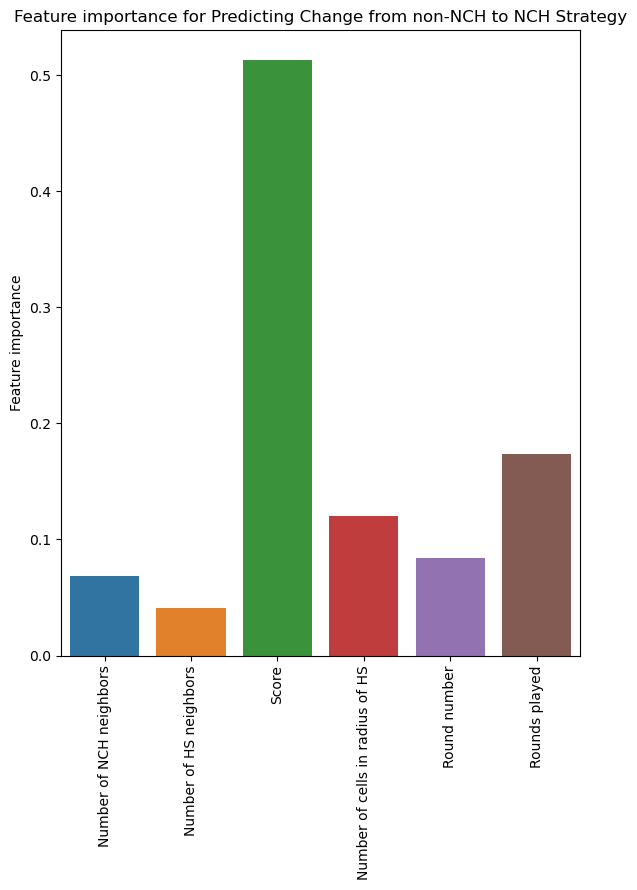

In [84]:
fig, ax = plt.subplots(figsize=(6,9))

sns.barplot(x=["Number of NCH neighbors", "Number of HS neighbors", "Score", "Number of cells in radius of HS", "Round number", "Rounds played"], 
            y=model.feature_importances_)
plt.xticks(rotation=90)
ax.set_title("Feature importance for Predicting Change from non-NCH to NCH Strategy")
ax.set_ylabel("Feature importance")
fig.tight_layout()

In [70]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X_test, Y_test, n_repeats=10, random_state=0, n_jobs=2
)

with_sub=(pd.Series(result.importances_mean, index=["Number of NCH neighbors", "Number of HS neighbors", "Score", "Number of cells in radius of HS", "Round number", "Rounds played"]))
# pfi_importances.append(pd.Series(result.importances_mean, index=[i for i in range(len(model.feature_importances_))]))
# pfi_std.append(pd.Series(result.importances_std, index=[i for i in range(len(model.feature_importances_))]))

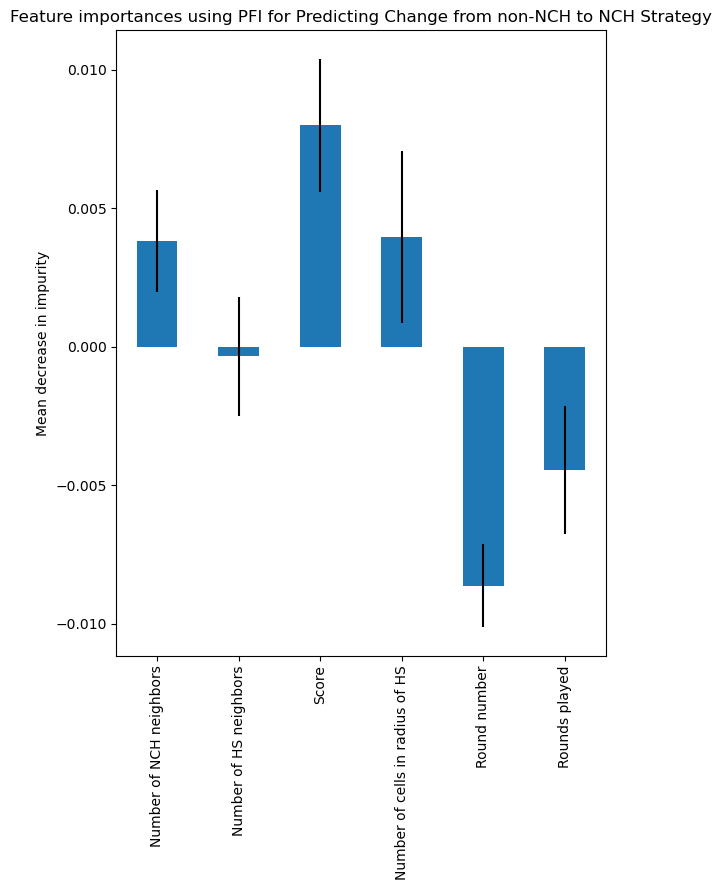

In [79]:
fig, ax = plt.subplots(figsize=(6,9))
with_sub.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using PFI for Predicting Change from non-NCH to NCH Strategy")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation=70)
fig.tight_layout()


In [86]:
# correlations
from scipy.stats import pearsonr

categories=["Number of NCH neighbors", "Number of HS neighbors", "Score", "Number of cells in radius of HS", "Round number", "Rounds played"]

for i in range(6):
    print(categories[i], pearsonr(X[:, i], Y))

Number of NCH neighbors PearsonRResult(statistic=0.23192584039944153, pvalue=4.365945448666723e-253)
Number of HS neighbors PearsonRResult(statistic=-0.18584193348067155, pvalue=1.2043407242969653e-161)
Score PearsonRResult(statistic=0.0025394110124206705, pvalue=0.7136383827614885)
Number of cells in radius of HS PearsonRResult(statistic=-0.19101490169811203, pvalue=7.992750266502534e-171)
Round number PearsonRResult(statistic=-0.0362038363524381, pvalue=1.6626063287419414e-07)
Rounds played PearsonRResult(statistic=-0.045253765076320826, pvalue=6.028479826351727e-11)


In [14]:
# UPDATED Predict whether farmer will change from non-nch to nch strategy
X=[]
Y=[]

set_country("Merged")

# defections_arr=[0]*8
# score_arr=[0]*8
# switch_round=[1]*4
# switch_score=[1]*4
# defections=0

prev_labels=[0]*4

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'][i+1] == 1:
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)

    #total nch and hs in whole plot
    num_nch=0
    num_hs=0
    for j in range(4):
        num_nch+=labels_2[(i)*4+j]==nch_2
        num_hs+=labels_2[(i)*4+j]==hs_2

    #all cells in plot covered by hs
    scores=np.array([[0]*6]*6)
    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=1

    hs_canceled=[0]*4
    for row in range(6):
        for col in range(6):
            hs_canceled[cells_map[row][col]-1]+=scores[row][col]

    for j in range(4):
        if labels_full[(i)*4+j] in nch_label:
            continue

        x_add=[]
        x_add.append(num_nch-int(labels_2[(i)*4+j]==nch_2))
        x_add.append(num_hs-int(labels_2[(i)*4+j]==hs_2))
        x_add.append(calculate_score_csv(i, curr_csv)[j])
        x_add.append(hs_canceled[j])
        x_add.append(curr_csv['Round'][i])
        x_add.append(curr_csv['roundsPlayed'][i])

        if(len(x_add)!=6):
            print("ERROR")
            break

        X.append(x_add)
        Y.append(labels_full[(i+1)*4+j] in nch_label)
X = np.array(X)
Y = np.array(Y)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print('acc: ', acc)

acc:  0.8748204882719004


In [16]:
np.count_nonzero(Y_test==False)/len(Y_test)

0.9001914791766396

In [17]:
np.count_nonzero(y_pred==False)/len(y_pred)

0.9569171852561034

In [18]:
model.feature_importances_

array([0.02626911, 0.0234866 , 0.59684874, 0.12643814, 0.06987248,
       0.15708494])

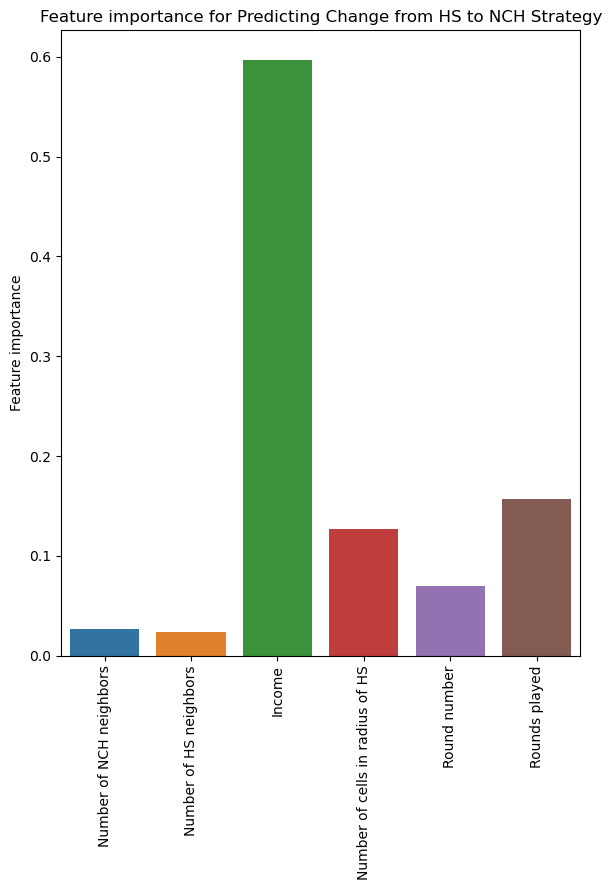

In [19]:
fig, ax = plt.subplots(figsize=(6,9))

sns.barplot(x=["Number of NCH neighbors", "Number of HS neighbors", "Income", "Number of cells in radius of HS", "Round number", "Rounds played"], 
            y=model.feature_importances_)
plt.xticks(rotation=90)
ax.set_title("Feature importance for Predicting Change from HS to NCH Strategy")
ax.set_ylabel("Feature importance")
fig.tight_layout()

# Correlations between number of consecutive rounds in the same cluster and staying with that strategy in the following round

In [18]:
# correlations - all
from scipy.stats import pearsonr

set_country("Merged")

same_arr=[1 for _ in range(4)]

X=[]
Y=[]

for i in range(len(curr_csv)):
    if curr_csv["Round"][i]==1:
        same_arr=[1 for _ in range(4)]
        continue

    for j in range(4):
        X.append(same_arr[j])
        if labels_full[i*4+j]==labels_full[(i-1)*4+j] or labels_full[i*4+j] in nch_label and labels_full[(i-1)*4+j] in nch_label:
            Y.append(1)
            same_arr[j]+=1
        else:
            Y.append(0)
            same_arr[j]=1
X=np.array(X)
Y=np.array(Y)

pearsonr(X, Y)


PearsonRResult(statistic=0.2697050640565485, pvalue=0.0)

In [17]:
# correlations - hs
from scipy.stats import pearsonr

set_country("Merged")

same_arr=[1 for _ in range(4)]

X=[]
Y=[]

for i in range(len(curr_csv)):
    if curr_csv["Round"][i]==1:
        same_arr=[1 for _ in range(4)]
        continue

    for j in range(4):
        if labels_full[(i-1)*4+j] in hs_label:
            X.append(same_arr[j])
            if labels_full[i*4+j]==labels_full[(i-1)*4+j]:
                Y.append(1)
                same_arr[j]+=1
            else:
                Y.append(0)
                same_arr[j]=1
        if labels_full[i*4+j] not in hs_label:
            same_arr[j]=1
X=np.array(X)
Y=np.array(Y)

pearsonr(X, Y)

PearsonRResult(statistic=0.2578602323950509, pvalue=3.10778476031798e-120)

In [16]:
# correlations - nch
from scipy.stats import pearsonr

set_country("Merged")

same_arr=[1 for _ in range(4)]

X=[]
Y=[]

for i in range(len(curr_csv)):
    if curr_csv["Round"][i]==1:
        same_arr=[1 for _ in range(4)]
        continue

    for j in range(4):
        if labels_full[(i-1)*4+j] in nch_label:
            X.append(same_arr[j])
            if labels_full[i*4+j] in nch_label:
                Y.append(1)
                same_arr[j]+=1
            else:
                Y.append(0)
                same_arr[j]=1
        if labels_full[i*4+j] not in nch_label:
            same_arr[j]=1
X=np.array(X)
Y=np.array(Y)

pearsonr(X, Y)

PearsonRResult(statistic=0.26907548733792735, pvalue=2.1327750158607942e-141)

In [15]:
# correlations - nch
from scipy.stats import pearsonr

set_country("Merged")

same_arr=[1 for _ in range(4)]

X=[]
Y=[]

for i in range(len(curr_csv)):
    if curr_csv["Round"][i]==1:
        same_arr=[1 for _ in range(4)]
        continue

    for j in range(4):
        if labels_full[(i-1)*4+j] in base_label:
            X.append(same_arr[j])
            if labels_full[i*4+j] in base_label:
                Y.append(1)
                same_arr[j]+=1
            else:
                Y.append(0)
                same_arr[j]=1
        if labels_full[i*4+j] not in base_label:
            same_arr[j]=1
X=np.array(X)
Y=np.array(Y)

pearsonr(X, Y)

PearsonRResult(statistic=0.2563789263911031, pvalue=1.0545834291877512e-193)

# average plot heterogeneity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


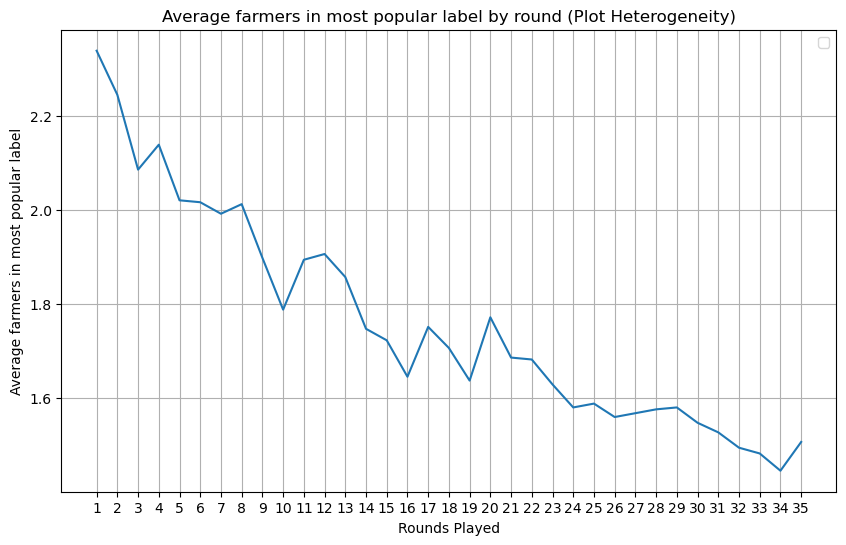

In [13]:
curr_csv = merged_csv
curr_str="Merged"
hs_label=hs_labels[curr_str]
strategy_label=strategy_labels[curr_str]
labels_full = labels_full_merged
centers = centers_merged

graph_arr=[0]*35

for round in range(1, 36):
    prev=False
    indices=[]
    label_totals = [0 for _ in range(4)]
    total = 0

    for i in range(len(curr_csv)):
        if curr_csv['roundsPlayed'].iloc[i]!=round:
            continue
        total+=1
        for j in range(4):
            label_totals[labels_full[i*4+j]]+=1

    for i in range(4):
        graph_arr[round-1]=max(label_totals)/total
graph_arr=np.array(graph_arr)

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

plt.plot([_+1 for _ in range(graph_arr.shape[0])], graph_arr)

# sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
x_ticks = np.arange(1, 36, 1)
plt.xticks(x_ticks)
plt.xlabel('Rounds Played')
plt.ylabel('Average farmers in most popular label')
plt.title('Average farmers in most popular label by round (Plot Heterogeneity)')
plt.legend()
plt.grid(True)
plt.show()

# [[2.59991019 0.90166143 5.49842838]
#  [0.13286004 8.15024631 0.71689365]
#  [0.39871758 1.07082483 7.53045759]
#  [6.48843188 0.37017995 2.14138817]]


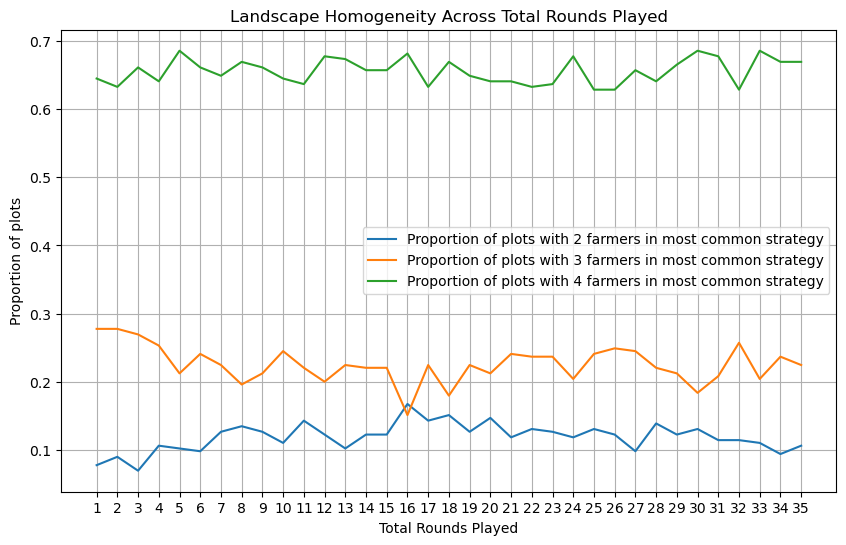

In [73]:
#with 2 clusters
set_country("Merged")

graph_arr=[[0]*35 for _ in range(5)]

for round in range(1, 36):
    prev=False
    indices=[]
    total = 0

    for i in range(len(curr_csv)):
        if curr_csv['roundsPlayed'].iloc[i]!=round:
            continue
        label_totals = [0 for _ in range(2)]
        total+=1
        for j in range(4):
            label_totals[labels_2[i*4+j]]+=1

        max_num=max(label_totals)
        graph_arr[max_num][round-1]+=1

    for i in range(5):
        graph_arr[i][round-1]/=total
graph_arr=np.array(graph_arr)

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

for row in range(2, graph_arr.shape[0]):
    sns.lineplot(x=[_+1 for _ in range(graph_arr.shape[1])], y=graph_arr[row], label=f'Proportion of plots with {row} farmers in most common strategy')

# sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
x_ticks = np.arange(1, 36, 1)
plt.xticks(x_ticks)
plt.xlabel('Total Rounds Played')
plt.ylabel('Proportion of plots')
plt.title('Landscape Homogeneity Across Total Rounds Played')
plt.legend()
plt.grid(True)
plt.show()

# plt.plot([_+1 for _ in range(graph_arr.shape[0])], graph_arr)

# # sns.lineplot(x=[_ for _ in range(1, 8)], y=defections_arr[1:])
# x_ticks = np.arange(1, 36, 1)
# plt.xticks(x_ticks)
# plt.xlabel('Rounds Played')
# plt.ylabel('Average farmers in most popular label')
# plt.title('Average farmers in most popular label by round (Plot Heterogeneity)')
# plt.legend()
# plt.grid(True)
# plt.show()

# [[2.59991019 0.90166143 5.49842838]
#  [0.13286004 8.15024631 0.71689365]
#  [0.39871758 1.07082483 7.53045759]
#  [6.48843188 0.37017995 2.14138817]]


# feature analysis on label switches

In [28]:
# Predict whether farmer will change from hs to base
X=[]
Y=[]
set_country("Merged")
prev=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'].iloc[i]==1:
        prev=0
        for j in range(4):
            prev+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    scores=np.array([[0]*6]*6)
    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=1
    hs_canceled=[0]*4
    for row in range(6):
        for col in range(6):
            hs_canceled[cells_map[row][col]-1]+=scores[row][col]

    switches=0
    num_nch=0
    for j in range(4):
        switches+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        num_nch+=labels_2[i*4+j]==nch_2

    x_add=[]
    x_add.append(prev)
    x_add.append(num_nch)
    x_add.append(sum(calculate_score_csv(i, curr_csv)))
    x_add.append(sum(hs_canceled))
    x_add.append(curr_csv['Round'][i])
    x_add.append(curr_csv['roundsPlayed'][i])

    X.append(x_add)
    Y.append(switches)
X = np.array(X)
Y = np.array(Y)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print('acc: ', acc)

acc:  0.7659863945578231


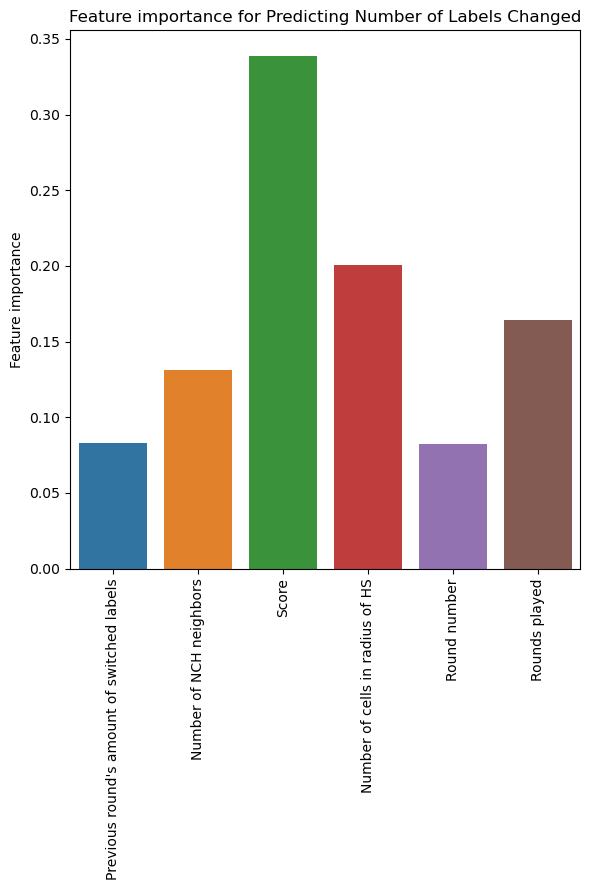

In [34]:
fig, ax = plt.subplots(figsize=(6,9))
features=["Previous round's amount of switched labels", "Number of NCH neighbors", "Score", "Number of cells in radius of HS", "Round number", "Rounds played"]
sns.barplot(x=features, 
            y=model.feature_importances_)
plt.xticks(rotation=90)
ax.set_title("Feature importance for Predicting Number of Labels Changed")
ax.set_ylabel("Feature importance")
fig.tight_layout()

In [35]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X_test, Y_test, n_repeats=10, random_state=0, n_jobs=2
)

with_sub=(pd.Series(result.importances_mean, index=features))
# pfi_importances.append(pd.Series(result.importances_mean, index=[i for i in range(len(model.feature_importances_))]))
# pfi_std.append(pd.Series(result.importances_std, index=[i for i in range(len(model.feature_importances_))]))

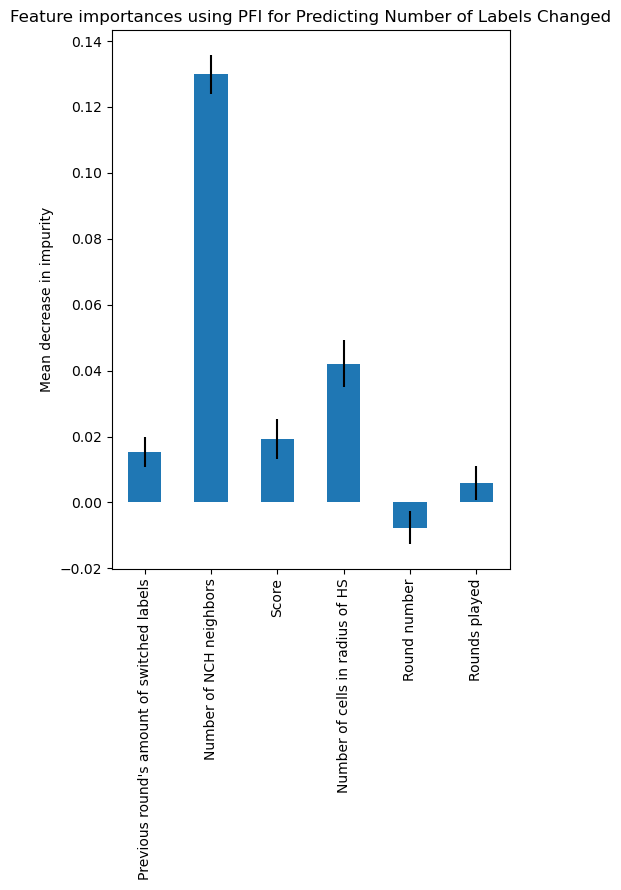

In [36]:
fig, ax = plt.subplots(figsize=(5,9))
with_sub.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using PFI for Predicting Number of Labels Changed")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation=70)
fig.tight_layout()


In [37]:
# correlations
from scipy.stats import pearsonr
categories=features

for i in range(6):
    print(categories[i], pearsonr(X[:, i], Y))

Previous round's amount of switched labels PearsonRResult(statistic=0.34934383106586425, pvalue=5.992277246889759e-210)
Number of NCH neighbors PearsonRResult(statistic=-0.2890114338611738, pvalue=2.2535893585748183e-141)
Score PearsonRResult(statistic=-0.09540545642893561, pvalue=2.48380146588675e-16)
Number of cells in radius of HS PearsonRResult(statistic=0.3595911609456035, pvalue=3.229456200473782e-223)
Round number PearsonRResult(statistic=0.0951242107554866, pvalue=3.038334764675109e-16)
Rounds played PearsonRResult(statistic=0.0581757806327967, pvalue=6.020033197272703e-07)


In [61]:
# Predict whether individual farmer will switch
X=[]
Y=[]
set_country("Merged")
prev=0

for i in range(len(curr_csv)-1):
    if curr_csv['Round'][i] == 1 and curr_csv['roundsPlayed'][i] == 1:
        i+=1
        while curr_csv['Round'][i] != 1:
            i+=1

    if curr_csv['Round'][i]==1:
        prev=0
        for j in range(4):
            prev+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        switches=0
        continue
    
    plot = np.array(curr_csv.iloc[i, 40:76]).reshape(6,6)
    scores=np.array([[0]*6]*6)
    for row in range(6):
        for col in range(6):
            if plot[row, col] == 3:
                for vert in range(max(0, row-1), min(6, row+2)):
                    # print(row, max(0, row-2), min(6, row+3))
                    for horiz in range(max(0, col-1), min(6, col+2)):
                        scores[vert, horiz]=1
    hs_canceled=[0]*4
    for row in range(6):
        for col in range(6):
            hs_canceled[cells_map[row][col]-1]+=scores[row][col]

    switches=0
    num_nch=0
    for j in range(4):
        switches+=labels_2[i*4+j]!=labels_2[(i+1)*4+j]
        num_nch+=labels_2[i*4+j]==nch_2
        
    for j in range(4):
        x_add=[]
        x_add.append(labels_2[i*4+j])
        x_add.append(num_nch-(labels_2[i*4+j]==nch_2))
        x_add.append(calculate_score_csv(i, curr_csv)[j])
        # x_add.append(sum(hs_canceled))
        # x_add.append(switches/curr_csv['Round'][i])
        x_add.append(switches-labels_2[i*4+j]!=labels_2[(i+1)*4+j])
        x_add.append(curr_csv['Round'][i])
        x_add.append(curr_csv['roundsPlayed'][i])

        X.append(x_add)
        Y.append(labels_2[i*4+j]!=labels_2[(i+1)*4+j])
X = np.array(X)
Y = np.array(Y)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=None)

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print('acc: ', acc)

acc:  0.9295918367346939


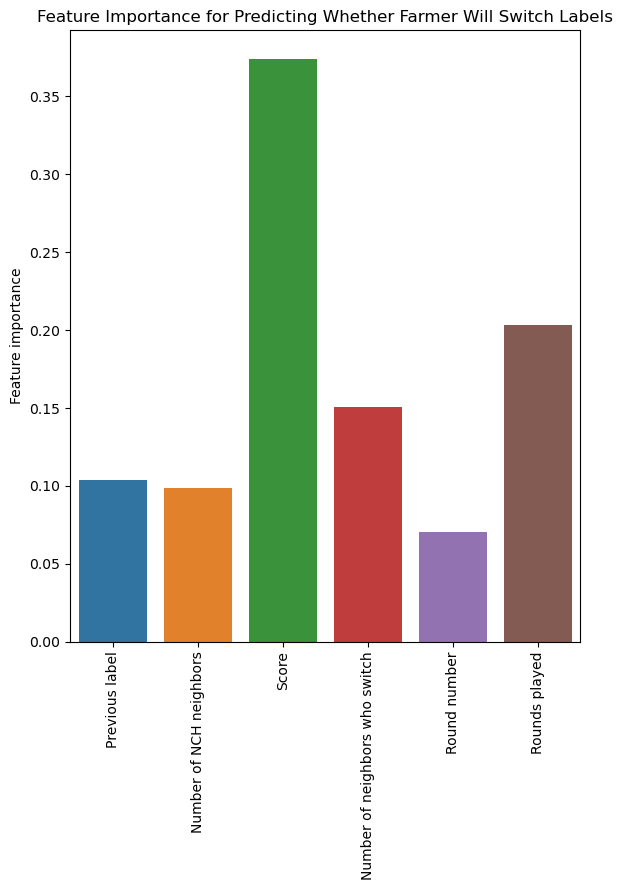

In [64]:
fig, ax = plt.subplots(figsize=(6,9))
features=["Previous label", "Number of NCH neighbors", "Score", "Number of neighbors who switch", "Round number", "Rounds played"]
sns.barplot(x=features, 
            y=model.feature_importances_)
plt.xticks(rotation=90)
ax.set_title("Feature Importance for Predicting Whether Farmer Will Switch Labels")
ax.set_ylabel("Feature importance")
fig.tight_layout()

In [65]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X_test, Y_test, n_repeats=10, random_state=0, n_jobs=2
)

with_sub=(pd.Series(result.importances_mean, index=features))
# pfi_importances.append(pd.Series(result.importances_mean, index=[i for i in range(len(model.feature_importances_))]))
# pfi_std.append(pd.Series(result.importances_std, index=[i for i in range(len(model.feature_importances_))]))

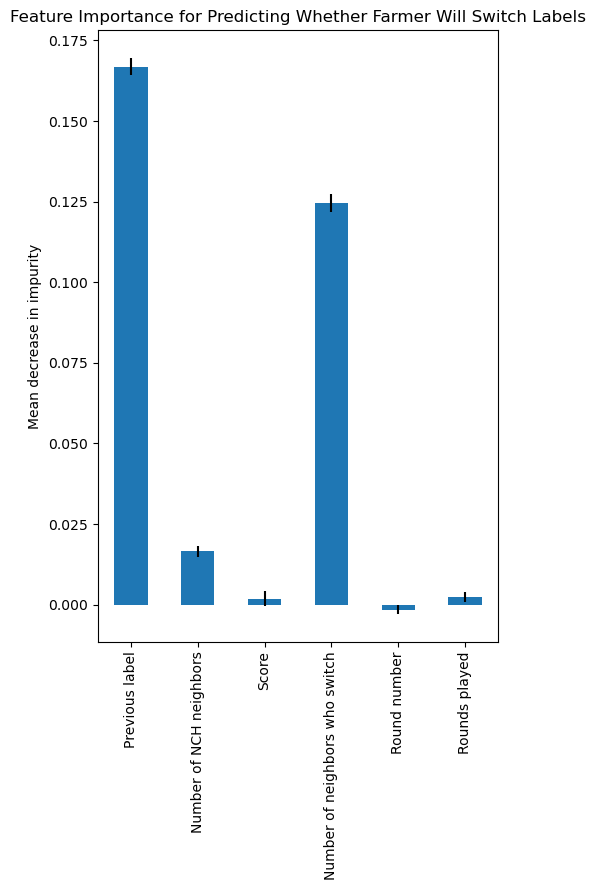

In [69]:
fig, ax = plt.subplots(figsize=(5,9))
with_sub.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importance for Predicting Whether Farmer Will Switch Labels")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation=70)
fig.tight_layout()


In [67]:
# correlations
from scipy.stats import pearsonr
categories=features

for i in range(6):
    print(categories[i], pearsonr(X[:, i], Y))

Previous label PearsonRResult(statistic=0.1537496383811983, pvalue=6.096741499323925e-155)
Number of NCH neighbors PearsonRResult(statistic=-0.16518593257779987, pvalue=7.323657547445159e-179)
Score PearsonRResult(statistic=-0.0422192816083025, pvalue=4.4366029617913246e-13)
Number of neighbors who switch PearsonRResult(statistic=0.06146579507542595, pvalue=5.189150075257674e-26)
Round number PearsonRResult(statistic=0.057787392075802906, pvalue=3.558805225102235e-23)
Rounds played PearsonRResult(statistic=0.03534144060742623, pvalue=1.3526260735322173e-09)
